# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk
from varseek.utils import make_bus_df, add_variant_type

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "32"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6", "vk_count_out_w37_k41")
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis", "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", "E_GEUV_1_HG00377_1_M_120209_6")
fastq_files = [os.path.join(fastqs_dir, "ERR204838_1.fastq.gz"), os.path.join(fastqs_dir, "ERR204838_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = True
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = "jmrich@caltech.edu"  # os.environ.get("EMAIL")  #!!! once I reload vscode this will work

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000390634:c.295T>C', 'ENST00000483158:c.199G>C', 'ENST00000390243:c.506G>C', 'ENST00000279259:c.107C>T', 'ENST00000390305:c.182C>T', 'ENST00000604930:c.355C>A', 'ENST00000390297:c.268A>G', 'ENST00000390316:c.324G>A', 'ENST00000390299:c.153G>A', 'ENST00000418724:c.2002T>G', 'ENST00000331789:c.1233C>T', 'ENST00000608019:c.319G>C', 'ENST00000483158:c.195A>G', 'ENST00000311111:c.317C>T', 'ENST00000225655:c.737G>T', 'ENST00000603423:c.266G>T', 'ENST00000334828:c.895G>A', 'ENST00000479981:c.138A>G', 'ENST00000331789:c.1209G>C', 'ENST00000376630:c.761G>A', 'ENST00000390312:c.359T>C', 'ENST00000493819:c.235G>A', 'ENST00000390243:c.354C>T', 'ENST00000604045:c.227C>A', 'ENST00000390290:c.183G>A', 'ENST00000524315:c.446A>G', 'ENST00000390243:c.359T>G', 'ENST00000579721:c.605C>T', 'ENST00000604787:c.241G>T', 'ENST00000390309:c.183G>A', 'ENST00000338970:c.137A>G', 'ENST00000603600:c.183A>C', 'ENST00000374213:c.208C>T', 'ENST00000374550:c.336C>G', 'ENST00000579721:c.414G>C', 'ENST00000495489

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,1821.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5781.0,0.0
23451,1365.0,ENST00000496168.1:c.201G>A,ENST00000496168:c.382G>A,ENST00000496168,ENSG00000243466,1365.0,3425.0,0.0
58590,722.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,267.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
23537,234.0,ENST00000468879.1:c.111A>T,ENST00000468879:c.292A>T,ENST00000468879,ENSG00000242580,234.0,7.0,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        disable_summarize=True,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,vcrs_count,gene_count,genotype
index,,,,,,,,
175115,1821.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,1821.0,5781.0,0.0
23451,1365.0,ENST00000496168.1:c.201G>A,ENST00000496168:c.382G>A,ENST00000496168,ENSG00000243466,1365.0,3425.0,0.0
58590,722.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,None,722.0,NaN,0.0
128160,267.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,267.0,NaN,0.0
23537,234.0,ENST00000468879.1:c.111A>T,ENST00000468879:c.292A>T,ENST00000468879,ENSG00000242580,234.0,7.0,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [ ]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= 2 and not true_variant
            
        if true_variant:  # >= 2 alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= 2 ref alleles and <2 alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <2 alt alleles and <2 ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

In [13]:
!cat {overall_txt_out}

Number of true variants: 221
Number of false variants: 97
Number of undetermined variants: 1
True variants list: ['ENST00000390312:c.218G>A', 'ENST00000496168:c.382G>A', 'ENST00000579721:c.142G>A', 'ENST00000603423:c.137G>A', 'ENST00000390309:c.359A>G', 'ENST00000603600:c.285G>A', 'ENST00000604412:c.415T>A', 'ENST00000483158:c.199G>C', 'ENST00000453673:c.105G>A', 'ENST00000390634:c.191C>T', 'ENST00000390309:c.195G>A', 'ENST00000603344:c.296T>G', 'ENST00000604930:c.373G>A', 'ENST00000390290:c.183G>A', 'ENST00000390319:c.261G>A', 'ENST00000390290:c.299G>A', 'ENST00000390319:c.197A>G', 'ENST00000390305:c.182C>T', 'ENST00000390299:c.228G>A', 'ENST00000496168:c.391C>T', 'ENST00000390299:c.269G>A', 'ENST00000390243:c.300A>G', 'ENST00000605716:c.222G>T', 'ENST00000468494:c.262A>G', 'ENST00000483158:c.195A>G', 'ENST00000354689:c.83C>T', 'ENST00000603600:c.205C>A', 'ENST00000483379:c.462C>T', 'ENST00000496168:c.405G>A', 'ENST00000604045:c.277C>T', 'ENST00000390319:c.99G>C', 'ENST00000390237:c.2

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/detailed_out_modified_bam.txt


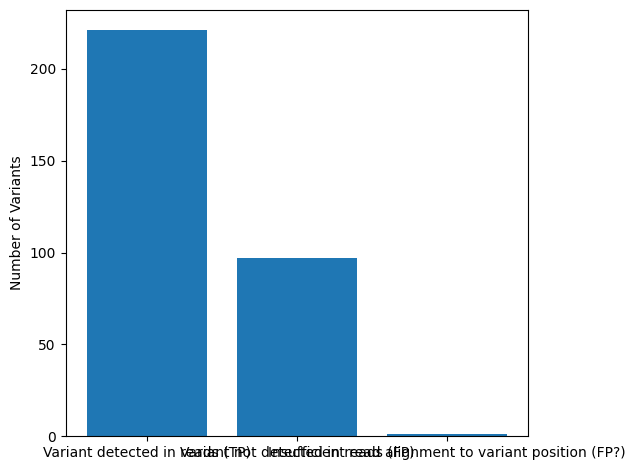

In [16]:
def plot_overall_bar_plot(overall_results, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": len(true_variants),
    "Variant not detected in reads (FP)": len(false_variants),
    "Insufficient read alignment to variant position (FP?)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, out_file=overall_txt_out.replace(".txt", ".pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

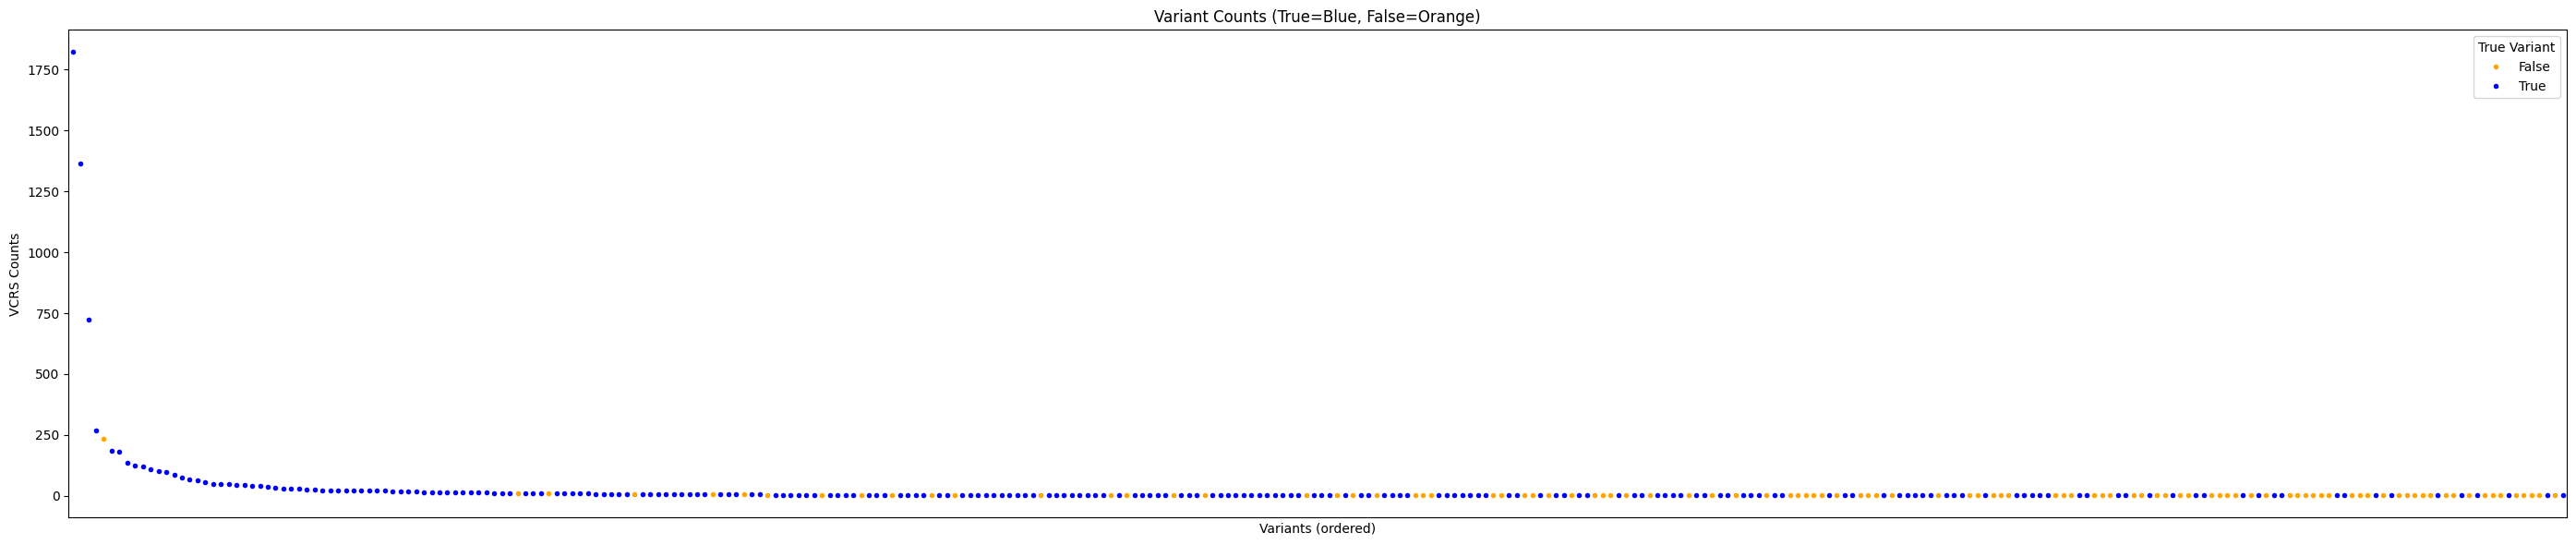

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(notebook_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [19]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [20]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [21]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [22]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [23]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis", "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [24]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [25]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [26]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs28507236,ENST00000379407,c.528A>C,+,ENST00000379407:c.528A>C,True,vcrs_0
1,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_1
2,rs3829739,ENST00000379407,c.1389A>G,+,ENST00000379407:c.1389A>G,True,vcrs_2
3,rs12184,ENST00000378567,c.425T>C,+,ENST00000378567:c.425T>C,True,vcrs_3
4,rs41315312,ENST00000294600,c.211C>T,+,ENST00000294600:c.211C>T,True,vcrs_4


In [ ]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= 2  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= 2 and not true_variant
            
        if true_variant:  # >= 2 alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= 2 ref alleles and <2 alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <2 alt alleles and <2 ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

In [28]:
!cat {overall_txt_out_fn}

Number of true variants: 156
Number of false variants: 235
Number of undetermined variants: 2746
True variants list: ['ENST00000361923:c.3205A>G', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000289893:c.6506G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000371088:c.1031T>C', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000256652:c.1822C>A', 'ENST00000581821:c.709G>C', 'ENST00000355199:c.1215G>C', 'ENST00000367079:c.619C>T', 'ENST00000367057:c.2176T>C', 'ENST00000367057:c.2201G>A', 'ENST00000238181:c.457C>T', 'ENST00000486442:c.1197T>C', 'ENST00000425361:c.39G>A', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000342518:c.1024C>T', 'ENST00000295777:c.482A>G', 'ENST00000608343:c.2645G>C', 'ENST00000389851:c.639T>C', 'ENST00000261439:c.721T>C', 'ENST00000307808:c.2676C>A', 'ENST00000296564:c.3382A>G', 'ENST00000322602:c.659T>C', 'ENST00000419065:c.381G>C', 'ENST00000419065:c.405C>T', 'ENST00000419065:c.406T>C', 'ENST

In [29]:
# !cat {detailed_txt_out_fn}

In [30]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


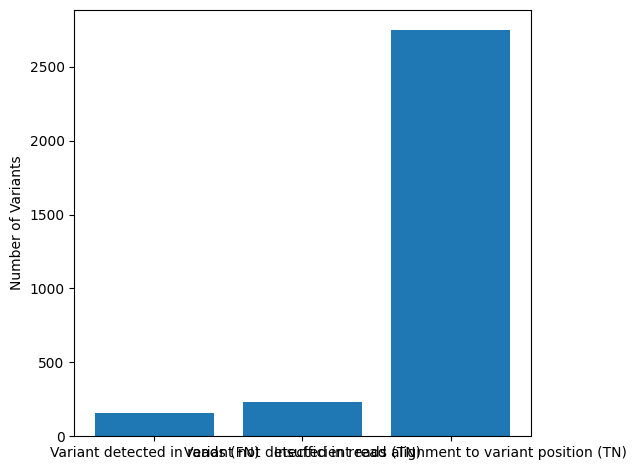

In [31]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, out_file=overall_txt_out.replace(".txt", ".pdf"))

## Analyze a FN

In [32]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")


  0%|                                                                                                                                                                                             | 0/25096 [00:00<?, ?it/s]


 29%|███████████████████████████████████████████████████▍                                                                                                                           | 7385/25096 [00:00<00:00, 72953.78it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 14681/25096 [00:00<00:00, 24130.04it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 18648/25096 [00:00<00:00, 16982.28it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21274/25096 [00:01<00:00, 16225.99it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 23785/25096 [00:01<00:00, 17569.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25096/25096 [00:01<00:00, 18441.51it/s]

Variants in vcrs_reference: 156
Variants not in vcrs_reference: 0


In [33]:
variants_in_vcrs_reference[:20]

['ENST00000361923:c.3205A>G',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000289893:c.6506G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000371088:c.1031T>C',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000256652:c.1822C>A',
 'ENST00000581821:c.709G>C',
 'ENST00000355199:c.1215G>C',
 'ENST00000367079:c.619C>T',
 'ENST00000367057:c.2176T>C',
 'ENST00000367057:c.2201G>A',
 'ENST00000238181:c.457C>T',
 'ENST00000486442:c.1197T>C',
 'ENST00000425361:c.39G>A',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A']

In [34]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000361923:c.3205A>G


In [35]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAATCCATCCCATCCTACTGCCAGCGCTCTGTCCACGGGATCGCCTCCCATGAAGAATCCATCCCATCCTACTG
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCCGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT
CAGTAGGATGGGATGGATTCTTCATGGGAGGCGATCCC
CGTGGACAGAGCGCTGGCAGTAGGATGGGATGGATTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [36]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > 2
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > 2 and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000468879:c.292A>T


GGATGACCCAGTCTCCATTCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCTGGGCCAGTCAGG
CCTGACTGGCCCAGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGAATGGAGACTGGGTCATCC


### Manually check if any read has a k-mer that matches the VCRS

In [37]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq


  0%|                                                                                                                                                                                          | 0/30247010 [00:00<?, ?it/s]


  0%|                                                                                                                                                                            | 4320/30247010 [00:00<11:40, 43195.72it/s]


  0%|                                                                                                                                                                            | 8693/30247010 [00:00<11:35, 43506.41it/s]


  0%|                                                                                                                                                                           | 13044/30247010 [00:00<11:37, 43326.30it/s]


  0%|                                                                                                                                                                           | 17427/30247010 [00:00<11:34, 43523.02it/s]


  0%|                                                                                                                                                                           | 21821/30247010 [00:00<11:32, 43669.33it/s]


  0%|▏                                                                                                                                                                          | 26213/30247010 [00:00<11:30, 43753.62it/s]


  0%|▏                                                                                                                                                                          | 30603/30247010 [00:00<11:29, 43799.95it/s]


  0%|▏                                                                                                                                                                          | 37027/30247010 [00:00<10:00, 50302.36it/s]


  0%|▏                                                                                                                                                                          | 44167/30247010 [00:00<08:50, 56892.66it/s]


  0%|▎                                                                                                                                                                          | 51828/30247010 [00:01<07:59, 62975.26it/s]


  0%|▎                                                                                                                                                                          | 58965/30247010 [00:01<07:40, 65542.68it/s]


  0%|▍                                                                                                                                                                          | 66615/30247010 [00:01<07:18, 68872.53it/s]


  0%|▍                                                                                                                                                                          | 73987/30247010 [00:01<07:08, 70336.07it/s]


  0%|▍                                                                                                                                                                          | 81873/30247010 [00:01<06:53, 72907.81it/s]


  0%|▌                                                                                                                                                                          | 90361/30247010 [00:01<06:34, 76514.71it/s]


  0%|▌                                                                                                                                                                          | 98325/30247010 [00:01<06:29, 77454.29it/s]


  0%|▌                                                                                                                                                                         | 106285/30247010 [00:01<06:25, 78097.24it/s]


  0%|▋                                                                                                                                                                         | 114129/30247010 [00:01<06:26, 77866.45it/s]


  0%|▋                                                                                                                                                                         | 122549/30247010 [00:01<06:17, 79759.84it/s]


  0%|▋                                                                                                                                                                         | 130526/30247010 [00:02<06:17, 79736.25it/s]


  0%|▊                                                                                                                                                                         | 138512/30247010 [00:02<06:17, 79772.39it/s]


  0%|▊                                                                                                                                                                         | 146991/30247010 [00:02<06:10, 81274.98it/s]


  1%|▊                                                                                                                                                                         | 155119/30247010 [00:02<06:13, 80465.49it/s]


  1%|▉                                                                                                                                                                         | 163168/30247010 [00:02<06:14, 80273.75it/s]


  1%|▉                                                                                                                                                                         | 171197/30247010 [00:02<06:15, 80174.00it/s]


  1%|█                                                                                                                                                                         | 179690/30247010 [00:02<06:08, 81589.86it/s]


  1%|█                                                                                                                                                                         | 187851/30247010 [00:02<06:11, 80839.28it/s]


  1%|█                                                                                                                                                                         | 195938/30247010 [00:02<06:14, 80167.30it/s]


  1%|█▏                                                                                                                                                                        | 203958/30247010 [00:02<06:15, 80086.27it/s]


  1%|█▏                                                                                                                                                                        | 212459/30247010 [00:03<06:08, 81547.88it/s]


  1%|█▏                                                                                                                                                                        | 220617/30247010 [00:03<06:10, 81094.43it/s]


  1%|█▎                                                                                                                                                                        | 228729/30247010 [00:03<06:12, 80527.59it/s]


  1%|█▎                                                                                                                                                                        | 236784/30247010 [00:03<06:16, 79711.22it/s]


  1%|█▍                                                                                                                                                                        | 245271/30247010 [00:03<06:09, 81234.79it/s]


  1%|█▍                                                                                                                                                                        | 253399/30247010 [00:03<06:10, 80871.50it/s]


  1%|█▍                                                                                                                                                                        | 261489/30247010 [00:03<06:12, 80597.02it/s]


  1%|█▌                                                                                                                                                                        | 269722/30247010 [00:03<06:12, 80425.36it/s]


  1%|█▌                                                                                                                                                                        | 278070/30247010 [00:03<06:08, 81328.62it/s]


  1%|█▌                                                                                                                                                                        | 286206/30247010 [00:03<06:10, 80885.18it/s]


  1%|█▋                                                                                                                                                                        | 294297/30247010 [00:04<06:11, 80531.58it/s]


  1%|█▋                                                                                                                                                                        | 302797/30247010 [00:04<06:12, 80481.03it/s]


  1%|█▋                                                                                                                                                                        | 311147/30247010 [00:04<06:07, 81367.06it/s]


  1%|█▊                                                                                                                                                                        | 319287/30247010 [00:04<06:09, 80992.65it/s]


  1%|█▊                                                                                                                                                                        | 327388/30247010 [00:04<06:10, 80759.77it/s]


  1%|█▉                                                                                                                                                                        | 335886/30247010 [00:04<06:04, 82010.27it/s]


  1%|█▉                                                                                                                                                                        | 344090/30247010 [00:04<06:07, 81359.72it/s]


  1%|█▉                                                                                                                                                                        | 352229/30247010 [00:04<06:10, 80603.13it/s]


  1%|██                                                                                                                                                                        | 360292/30247010 [00:04<06:11, 80357.35it/s]


  1%|██                                                                                                                                                                        | 368781/30247010 [00:04<06:05, 81698.64it/s]


  1%|██                                                                                                                                                                        | 376954/30247010 [00:05<06:07, 81205.31it/s]


  1%|██▏                                                                                                                                                                       | 385077/30247010 [00:05<06:09, 80894.01it/s]


  1%|██▏                                                                                                                                                                       | 393168/30247010 [00:05<06:11, 80423.55it/s]


  1%|██▎                                                                                                                                                                       | 401662/30247010 [00:05<06:05, 81761.06it/s]


  1%|██▎                                                                                                                                                                       | 409841/30247010 [00:05<06:06, 81338.51it/s]


  1%|██▎                                                                                                                                                                       | 417977/30247010 [00:05<06:29, 76631.20it/s]


  1%|██▍                                                                                                                                                                       | 425966/30247010 [00:05<06:24, 77559.45it/s]


  1%|██▍                                                                                                                                                                       | 434376/30247010 [00:05<06:15, 79453.27it/s]


  1%|██▍                                                                                                                                                                       | 442379/30247010 [00:05<06:14, 79620.28it/s]


  1%|██▌                                                                                                                                                                       | 450391/30247010 [00:05<06:13, 79766.85it/s]


  2%|██▌                                                                                                                                                                       | 458837/30247010 [00:06<06:12, 79992.33it/s]


  2%|██▋                                                                                                                                                                       | 467345/30247010 [00:06<06:05, 81487.37it/s]


  2%|██▋                                                                                                                                                                       | 475506/30247010 [00:06<06:08, 80850.29it/s]


  2%|██▋                                                                                                                                                                       | 483600/30247010 [00:06<06:09, 80601.78it/s]


  2%|██▊                                                                                                                                                                       | 491816/30247010 [00:06<06:09, 80471.05it/s]


  2%|██▊                                                                                                                                                                       | 500322/30247010 [00:06<06:03, 81825.49it/s]


  2%|██▊                                                                                                                                                                       | 508510/30247010 [00:06<06:06, 81247.20it/s]


  2%|██▉                                                                                                                                                                       | 516639/30247010 [00:06<06:08, 80586.88it/s]


  2%|██▉                                                                                                                                                                       | 524794/30247010 [00:06<06:09, 80403.41it/s]


  2%|██▉                                                                                                                                                                       | 533299/30247010 [00:06<06:03, 81776.48it/s]


  2%|███                                                                                                                                                                       | 541481/30247010 [00:07<06:05, 81206.70it/s]


  2%|███                                                                                                                                                                       | 549605/30247010 [00:07<06:07, 80837.82it/s]


  2%|███▏                                                                                                                                                                      | 557771/30247010 [00:07<06:09, 80333.92it/s]


  2%|███▏                                                                                                                                                                      | 566244/30247010 [00:07<06:03, 81630.90it/s]


  2%|███▏                                                                                                                                                                      | 574411/30247010 [00:07<06:05, 81179.70it/s]


  2%|███▎                                                                                                                                                                      | 582532/30247010 [00:07<06:06, 80856.00it/s]


  2%|███▎                                                                                                                                                                      | 590894/30247010 [00:07<06:07, 80681.33it/s]


  2%|███▎                                                                                                                                                                      | 599284/30247010 [00:07<06:03, 81630.02it/s]


  2%|███▍                                                                                                                                                                      | 607450/30247010 [00:07<06:05, 81130.21it/s]


  2%|███▍                                                                                                                                                                      | 615565/30247010 [00:08<06:06, 80860.18it/s]


  2%|███▌                                                                                                                                                                      | 624020/30247010 [00:08<06:07, 80712.08it/s]


  2%|███▌                                                                                                                                                                      | 632513/30247010 [00:08<06:01, 81953.58it/s]


  2%|███▌                                                                                                                                                                      | 640712/30247010 [00:08<06:04, 81238.66it/s]


  2%|███▋                                                                                                                                                                      | 648839/30247010 [00:08<06:05, 80893.04it/s]


  2%|███▋                                                                                                                                                                      | 657145/30247010 [00:08<06:06, 80646.96it/s]


  2%|███▋                                                                                                                                                                      | 665665/30247010 [00:08<06:00, 81988.14it/s]


  2%|███▊                                                                                                                                                                      | 673868/30247010 [00:08<06:03, 81376.27it/s]


  2%|███▊                                                                                                                                                                      | 682009/30247010 [00:08<06:17, 78227.93it/s]


  2%|███▉                                                                                                                                                                      | 690271/30247010 [00:08<06:15, 78732.67it/s]


  2%|███▉                                                                                                                                                                      | 698776/30247010 [00:09<06:06, 80563.39it/s]


  2%|███▉                                                                                                                                                                      | 706852/30247010 [00:09<06:07, 80364.28it/s]


  2%|████                                                                                                                                                                      | 714902/30247010 [00:09<06:09, 80027.89it/s]


  2%|████                                                                                                                                                                      | 723386/30247010 [00:09<06:07, 80230.66it/s]


  2%|████                                                                                                                                                                      | 731896/30247010 [00:09<06:01, 81658.51it/s]


  2%|████▏                                                                                                                                                                     | 740070/30247010 [00:09<06:03, 81221.32it/s]


  2%|████▏                                                                                                                                                                     | 748198/30247010 [00:09<06:04, 80876.29it/s]


  3%|████▎                                                                                                                                                                     | 756363/30247010 [00:09<06:07, 80324.52it/s]


  3%|████▎                                                                                                                                                                     | 764867/30247010 [00:09<06:00, 81713.47it/s]


  3%|████▎                                                                                                                                                                     | 773043/30247010 [00:09<06:03, 81152.51it/s]


  3%|████▍                                                                                                                                                                     | 781162/30247010 [00:10<06:04, 80782.26it/s]


  3%|████▍                                                                                                                                                                     | 789340/30247010 [00:10<06:05, 80579.89it/s]


  3%|████▍                                                                                                                                                                     | 797731/30247010 [00:10<06:01, 81564.54it/s]


  3%|████▌                                                                                                                                                                     | 805890/30247010 [00:10<06:02, 81220.08it/s]


  3%|████▌                                                                                                                                                                     | 814014/30247010 [00:10<06:03, 80874.99it/s]


  3%|████▌                                                                                                                                                                     | 822317/30247010 [00:10<06:04, 80713.93it/s]


  3%|████▋                                                                                                                                                                     | 830813/30247010 [00:10<05:58, 81969.36it/s]


  3%|████▋                                                                                                                                                                     | 839013/30247010 [00:10<06:02, 81230.65it/s]


  3%|████▊                                                                                                                                                                     | 847139/30247010 [00:10<06:03, 80877.02it/s]


  3%|████▊                                                                                                                                                                     | 855294/30247010 [00:10<06:04, 80607.46it/s]


  3%|████▊                                                                                                                                                                     | 863793/30247010 [00:11<05:58, 81903.93it/s]


  3%|████▉                                                                                                                                                                     | 871986/30247010 [00:11<06:01, 81332.40it/s]


  3%|████▉                                                                                                                                                                     | 880122/30247010 [00:11<06:04, 80665.66it/s]


  3%|████▉                                                                                                                                                                     | 888320/30247010 [00:11<06:04, 80492.02it/s]


  3%|█████                                                                                                                                                                     | 896822/30247010 [00:11<05:58, 81829.48it/s]


  3%|█████                                                                                                                                                                     | 905008/30247010 [00:11<06:00, 81328.13it/s]


  3%|█████▏                                                                                                                                                                    | 913144/30247010 [00:11<06:02, 80861.31it/s]


  3%|█████▏                                                                                                                                                                    | 921479/30247010 [00:11<06:05, 80338.87it/s]


  3%|█████▏                                                                                                                                                                    | 929991/30247010 [00:11<05:58, 81743.07it/s]


  3%|█████▎                                                                                                                                                                    | 938170/30247010 [00:11<06:00, 81194.29it/s]


  3%|█████▎                                                                                                                                                                    | 946293/30247010 [00:12<06:02, 80762.49it/s]


  3%|█████▎                                                                                                                                                                    | 954605/30247010 [00:12<06:03, 80546.26it/s]


  3%|█████▍                                                                                                                                                                    | 962987/30247010 [00:12<05:59, 81510.25it/s]


  3%|█████▍                                                                                                                                                                    | 971142/30247010 [00:12<06:01, 80982.72it/s]


  3%|█████▌                                                                                                                                                                    | 979243/30247010 [00:12<06:02, 80707.00it/s]


  3%|█████▌                                                                                                                                                                    | 987730/30247010 [00:12<06:03, 80554.15it/s]


  3%|█████▌                                                                                                                                                                    | 996226/30247010 [00:12<05:57, 81846.20it/s]


  3%|█████▌                                                                                                                                                                   | 1004415/30247010 [00:12<06:00, 81012.02it/s]


  3%|█████▋                                                                                                                                                                   | 1012520/30247010 [00:12<06:02, 80685.26it/s]


  3%|█████▋                                                                                                                                                                   | 1020763/30247010 [00:13<06:02, 80521.35it/s]


  3%|█████▊                                                                                                                                                                   | 1029280/30247010 [00:13<05:56, 81890.17it/s]


  3%|█████▊                                                                                                                                                                   | 1037473/30247010 [00:13<05:59, 81303.57it/s]


  3%|█████▊                                                                                                                                                                   | 1045607/30247010 [00:13<06:02, 80665.79it/s]


  3%|█████▉                                                                                                                                                                   | 1053694/30247010 [00:13<06:02, 80500.63it/s]


  4%|█████▉                                                                                                                                                                   | 1062197/30247010 [00:13<05:56, 81841.41it/s]


  4%|█████▉                                                                                                                                                                   | 1070384/30247010 [00:13<05:58, 81318.80it/s]


  4%|██████                                                                                                                                                                   | 1078519/30247010 [00:13<06:00, 80887.29it/s]


  4%|██████                                                                                                                                                                   | 1086610/30247010 [00:13<06:03, 80298.69it/s]


  4%|██████                                                                                                                                                                   | 1095115/30247010 [00:13<05:56, 81703.26it/s]


  4%|██████▏                                                                                                                                                                  | 1103289/30247010 [00:14<05:59, 81179.63it/s]


  4%|██████▏                                                                                                                                                                  | 1111410/30247010 [00:14<06:00, 80886.04it/s]


  4%|██████▎                                                                                                                                                                  | 1119501/30247010 [00:14<06:02, 80305.46it/s]


  4%|██████▎                                                                                                                                                                  | 1128002/30247010 [00:14<05:56, 81697.41it/s]


  4%|██████▎                                                                                                                                                                  | 1136175/30247010 [00:14<05:58, 81227.14it/s]


  4%|██████▍                                                                                                                                                                  | 1144300/30247010 [00:14<05:59, 80864.47it/s]


  4%|██████▍                                                                                                                                                                  | 1152388/30247010 [00:14<06:00, 80608.00it/s]


  4%|██████▍                                                                                                                                                                  | 1160784/30247010 [00:14<05:56, 81602.03it/s]


  4%|██████▌                                                                                                                                                                  | 1168946/30247010 [00:14<05:58, 81104.83it/s]


  4%|██████▌                                                                                                                                                                  | 1177059/30247010 [00:14<05:59, 80791.53it/s]


  4%|██████▌                                                                                                                                                                  | 1185140/30247010 [00:15<06:00, 80523.55it/s]


  4%|██████▋                                                                                                                                                                  | 1193644/30247010 [00:15<05:54, 81865.69it/s]


  4%|██████▋                                                                                                                                                                  | 1201833/30247010 [00:15<05:58, 81049.69it/s]


  4%|██████▊                                                                                                                                                                  | 1209941/30247010 [00:15<05:59, 80747.34it/s]


  4%|██████▊                                                                                                                                                                  | 1218018/30247010 [00:15<06:00, 80469.37it/s]


  4%|██████▊                                                                                                                                                                  | 1226505/30247010 [00:15<05:54, 81773.28it/s]


  4%|██████▉                                                                                                                                                                  | 1234685/30247010 [00:15<05:56, 81322.43it/s]


  4%|██████▉                                                                                                                                                                  | 1242819/30247010 [00:15<05:59, 80587.76it/s]


  4%|██████▉                                                                                                                                                                  | 1250907/30247010 [00:15<06:00, 80447.20it/s]


  4%|███████                                                                                                                                                                  | 1259414/30247010 [00:15<05:54, 81816.32it/s]


  4%|███████                                                                                                                                                                  | 1267599/30247010 [00:16<05:56, 81319.57it/s]


  4%|███████▏                                                                                                                                                                 | 1275734/30247010 [00:16<05:58, 80881.75it/s]


  4%|███████▏                                                                                                                                                                 | 1283884/30247010 [00:16<06:00, 80420.54it/s]


  4%|███████▏                                                                                                                                                                 | 1292387/30247010 [00:16<05:54, 81784.60it/s]


  4%|███████▎                                                                                                                                                                 | 1300569/30247010 [00:16<05:56, 81218.85it/s]


  4%|███████▎                                                                                                                                                                 | 1308694/30247010 [00:16<05:58, 80779.02it/s]


  4%|███████▎                                                                                                                                                                 | 1316862/30247010 [00:16<05:59, 80526.27it/s]


  4%|███████▍                                                                                                                                                                 | 1325263/30247010 [00:16<05:54, 81555.63it/s]


  4%|███████▍                                                                                                                                                                 | 1333421/30247010 [00:16<05:56, 81026.59it/s]


  4%|███████▍                                                                                                                                                                 | 1341526/30247010 [00:16<05:58, 80650.37it/s]


  4%|███████▌                                                                                                                                                                 | 1349839/30247010 [00:17<05:59, 80465.24it/s]


  4%|███████▌                                                                                                                                                                 | 1358340/30247010 [00:17<05:53, 81806.14it/s]


  5%|███████▋                                                                                                                                                                 | 1366524/30247010 [00:17<05:56, 80970.50it/s]


  5%|███████▋                                                                                                                                                                 | 1374625/30247010 [00:17<05:57, 80679.67it/s]


  5%|███████▋                                                                                                                                                                 | 1382799/30247010 [00:17<05:58, 80452.75it/s]


  5%|███████▊                                                                                                                                                                 | 1391299/30247010 [00:17<05:52, 81794.80it/s]


  5%|███████▊                                                                                                                                                                 | 1399482/30247010 [00:17<05:55, 81243.27it/s]


  5%|███████▊                                                                                                                                                                 | 1407609/30247010 [00:17<05:57, 80584.09it/s]


  5%|███████▉                                                                                                                                                                 | 1415670/30247010 [00:17<05:58, 80342.85it/s]


  5%|███████▉                                                                                                                                                                 | 1424185/30247010 [00:17<05:52, 81765.65it/s]


  5%|████████                                                                                                                                                                 | 1432365/30247010 [00:18<05:55, 81155.98it/s]


  5%|████████                                                                                                                                                                 | 1440484/30247010 [00:18<05:56, 80772.21it/s]


  5%|████████                                                                                                                                                                 | 1448563/30247010 [00:18<05:59, 80210.32it/s]


  5%|████████▏                                                                                                                                                                | 1457064/30247010 [00:18<05:52, 81631.00it/s]


  5%|████████▏                                                                                                                                                                | 1465230/30247010 [00:18<05:54, 81116.54it/s]


  5%|████████▏                                                                                                                                                                | 1473344/30247010 [00:18<05:56, 80738.61it/s]


  5%|████████▎                                                                                                                                                                | 1481420/30247010 [00:18<05:57, 80443.36it/s]


  5%|████████▎                                                                                                                                                                | 1489466/30247010 [00:18<06:08, 78004.09it/s]


  5%|████████▎                                                                                                                                                                | 1497418/30247010 [00:18<06:06, 78443.93it/s]


  5%|████████▍                                                                                                                                                                | 1505382/30247010 [00:19<06:04, 78793.43it/s]


  5%|████████▍                                                                                                                                                                | 1513866/30247010 [00:19<05:56, 80580.00it/s]


  5%|████████▌                                                                                                                                                                | 1521933/30247010 [00:19<05:57, 80342.22it/s]


  5%|████████▌                                                                                                                                                                | 1529974/30247010 [00:19<05:59, 79899.50it/s]


  5%|████████▌                                                                                                                                                                | 1538004/30247010 [00:19<05:58, 80016.25it/s]


  5%|████████▋                                                                                                                                                                | 1546511/30247010 [00:19<05:52, 81520.19it/s]


  5%|████████▋                                                                                                                                                                | 1554667/30247010 [00:19<05:54, 81025.11it/s]


  5%|████████▋                                                                                                                                                                | 1562773/30247010 [00:19<05:55, 80616.93it/s]


  5%|████████▊                                                                                                                                                                | 1570837/30247010 [00:19<05:58, 80027.43it/s]


  5%|████████▊                                                                                                                                                                | 1579367/30247010 [00:19<05:51, 81590.10it/s]


  5%|████████▊                                                                                                                                                                | 1587530/30247010 [00:20<05:53, 81045.23it/s]


  5%|████████▉                                                                                                                                                                | 1595638/30247010 [00:20<05:55, 80672.98it/s]


  5%|████████▉                                                                                                                                                                | 1603708/30247010 [00:20<05:56, 80387.51it/s]


  5%|█████████                                                                                                                                                                | 1612088/30247010 [00:20<05:51, 81399.50it/s]


  5%|█████████                                                                                                                                                                | 1620230/30247010 [00:20<05:53, 80998.87it/s]


  5%|█████████                                                                                                                                                                | 1628332/30247010 [00:20<05:54, 80616.39it/s]


  5%|█████████▏                                                                                                                                                               | 1636486/30247010 [00:20<05:55, 80378.70it/s]


  5%|█████████▏                                                                                                                                                               | 1644947/30247010 [00:20<05:51, 81445.99it/s]


  5%|█████████▏                                                                                                                                                               | 1653093/30247010 [00:20<05:53, 80928.38it/s]


  5%|█████████▎                                                                                                                                                               | 1661188/30247010 [00:20<05:54, 80670.15it/s]


  6%|█████████▎                                                                                                                                                               | 1669463/30247010 [00:21<05:55, 80472.92it/s]


  6%|█████████▍                                                                                                                                                               | 1677970/30247010 [00:21<05:49, 81829.48it/s]


  6%|█████████▍                                                                                                                                                               | 1686156/30247010 [00:21<05:52, 80940.70it/s]


  6%|█████████▍                                                                                                                                                               | 1694254/30247010 [00:21<05:53, 80664.50it/s]


  6%|█████████▌                                                                                                                                                               | 1702441/30247010 [00:21<05:55, 80404.12it/s]


  6%|█████████▌                                                                                                                                                               | 1710946/30247010 [00:21<05:48, 81775.98it/s]


  6%|█████████▌                                                                                                                                                               | 1719127/30247010 [00:21<05:51, 81211.08it/s]


  6%|█████████▋                                                                                                                                                               | 1727251/30247010 [00:21<05:54, 80511.48it/s]


  6%|█████████▋                                                                                                                                                               | 1735390/30247010 [00:21<05:55, 80234.92it/s]


  6%|█████████▋                                                                                                                                                               | 1743876/30247010 [00:21<05:49, 81599.77it/s]


  6%|█████████▊                                                                                                                                                               | 1752040/30247010 [00:22<05:51, 81098.23it/s]


  6%|█████████▊                                                                                                                                                               | 1760153/30247010 [00:22<05:53, 80696.97it/s]


  6%|█████████▉                                                                                                                                                               | 1768225/30247010 [00:22<05:55, 80154.65it/s]


  6%|█████████▉                                                                                                                                                               | 1776736/30247010 [00:22<05:48, 81620.83it/s]


  6%|█████████▉                                                                                                                                                               | 1784902/30247010 [00:22<05:50, 81094.44it/s]


  6%|██████████                                                                                                                                                               | 1793014/30247010 [00:22<05:52, 80709.43it/s]


  6%|██████████                                                                                                                                                               | 1801087/30247010 [00:22<05:53, 80471.44it/s]


  6%|██████████                                                                                                                                                               | 1809488/30247010 [00:22<05:48, 81519.90it/s]


  6%|██████████▏                                                                                                                                                              | 1817642/30247010 [00:22<05:50, 81025.81it/s]


  6%|██████████▏                                                                                                                                                              | 1825747/30247010 [00:22<05:52, 80638.93it/s]


  6%|██████████▏                                                                                                                                                              | 1833881/30247010 [00:23<05:53, 80385.90it/s]


  6%|██████████▎                                                                                                                                                              | 1842402/30247010 [00:23<05:47, 81816.16it/s]


  6%|██████████▎                                                                                                                                                              | 1850586/30247010 [00:23<05:50, 80960.69it/s]


  6%|██████████▍                                                                                                                                                              | 1858686/30247010 [00:23<05:52, 80572.33it/s]


  6%|██████████▍                                                                                                                                                              | 1866746/30247010 [00:23<05:53, 80349.04it/s]


  6%|██████████▍                                                                                                                                                              | 1875246/30247010 [00:23<05:47, 81728.06it/s]


  6%|██████████▌                                                                                                                                                              | 1883422/30247010 [00:23<05:49, 81147.45it/s]


  6%|██████████▌                                                                                                                                                              | 1891539/30247010 [00:23<05:52, 80463.45it/s]


  6%|██████████▌                                                                                                                                                              | 1899588/30247010 [00:23<05:53, 80207.86it/s]


  6%|██████████▋                                                                                                                                                              | 1908094/30247010 [00:23<05:47, 81644.79it/s]


  6%|██████████▋                                                                                                                                                              | 1916262/30247010 [00:24<06:09, 76717.13it/s]


  6%|██████████▊                                                                                                                                                              | 1924183/30247010 [00:24<06:05, 77425.76it/s]


  6%|██████████▊                                                                                                                                                              | 1932523/30247010 [00:24<06:03, 77906.12it/s]


  6%|██████████▊                                                                                                                                                              | 1941005/30247010 [00:24<05:54, 79905.23it/s]


  6%|██████████▉                                                                                                                                                              | 1949026/30247010 [00:24<05:54, 79851.62it/s]


  6%|██████████▉                                                                                                                                                              | 1957032/30247010 [00:24<05:54, 79721.04it/s]


  6%|██████████▉                                                                                                                                                              | 1965500/30247010 [00:24<05:54, 79745.57it/s]


  7%|███████████                                                                                                                                                              | 1973868/30247010 [00:24<05:49, 80896.11it/s]


  7%|███████████                                                                                                                                                              | 1981968/30247010 [00:24<05:51, 80497.95it/s]


  7%|███████████                                                                                                                                                              | 1990025/30247010 [00:25<05:52, 80223.97it/s]


  7%|███████████▏                                                                                                                                                             | 1998477/30247010 [00:25<05:52, 80119.32it/s]


  7%|███████████▏                                                                                                                                                             | 2006969/30247010 [00:25<05:46, 81527.14it/s]


  7%|███████████▎                                                                                                                                                             | 2015128/30247010 [00:25<05:49, 80671.89it/s]


  7%|███████████▎                                                                                                                                                             | 2023200/30247010 [00:25<05:51, 80324.87it/s]


  7%|███████████▎                                                                                                                                                             | 2031455/30247010 [00:25<05:52, 80145.24it/s]


  7%|███████████▍                                                                                                                                                             | 2039943/30247010 [00:25<05:45, 81537.44it/s]


  7%|███████████▍                                                                                                                                                             | 2048101/30247010 [00:25<05:49, 80673.13it/s]


  7%|███████████▍                                                                                                                                                             | 2056173/30247010 [00:25<05:50, 80395.69it/s]


  7%|███████████▌                                                                                                                                                             | 2064432/30247010 [00:25<05:51, 80274.53it/s]


  7%|███████████▌                                                                                                                                                             | 2072912/30247010 [00:26<05:45, 81607.03it/s]


  7%|███████████▋                                                                                                                                                             | 2081077/30247010 [00:26<05:47, 81014.52it/s]


  7%|███████████▋                                                                                                                                                             | 2089182/30247010 [00:26<05:50, 80282.15it/s]


  7%|███████████▋                                                                                                                                                             | 2097351/30247010 [00:26<05:50, 80209.05it/s]


  7%|███████████▊                                                                                                                                                             | 2105850/30247010 [00:26<05:44, 81619.80it/s]


  7%|███████████▊                                                                                                                                                             | 2114016/30247010 [00:26<05:47, 81032.00it/s]


  7%|███████████▊                                                                                                                                                             | 2122122/30247010 [00:26<05:49, 80575.28it/s]


  7%|███████████▉                                                                                                                                                             | 2130182/30247010 [00:26<05:51, 79978.78it/s]


  7%|███████████▉                                                                                                                                                             | 2138655/30247010 [00:26<05:45, 81382.90it/s]


  7%|███████████▉                                                                                                                                                             | 2146797/30247010 [00:26<05:47, 80837.82it/s]


  7%|████████████                                                                                                                                                             | 2154884/30247010 [00:27<05:49, 80443.25it/s]


  7%|████████████                                                                                                                                                             | 2163011/30247010 [00:27<05:50, 80181.38it/s]


  7%|████████████▏                                                                                                                                                            | 2171391/30247010 [00:27<05:45, 81251.84it/s]


  7%|████████████▏                                                                                                                                                            | 2179519/30247010 [00:27<05:47, 80756.24it/s]


  7%|████████████▏                                                                                                                                                            | 2187597/30247010 [00:27<05:48, 80499.67it/s]


  7%|████████████▎                                                                                                                                                            | 2195841/30247010 [00:27<05:49, 80261.59it/s]


  7%|████████████▎                                                                                                                                                            | 2204310/30247010 [00:27<05:43, 81568.98it/s]


  7%|████████████▎                                                                                                                                                            | 2212470/30247010 [00:27<05:47, 80686.64it/s]


  7%|████████████▍                                                                                                                                                            | 2220542/30247010 [00:27<05:48, 80350.19it/s]


  7%|████████████▍                                                                                                                                                            | 2228671/30247010 [00:27<05:49, 80213.83it/s]


  7%|████████████▍                                                                                                                                                            | 2237167/30247010 [00:28<05:43, 81617.45it/s]


  7%|████████████▌                                                                                                                                                            | 2245332/30247010 [00:28<05:45, 81090.78it/s]


  7%|████████████▌                                                                                                                                                            | 2253444/30247010 [00:28<05:48, 80358.35it/s]


  7%|████████████▋                                                                                                                                                            | 2261524/30247010 [00:28<05:49, 80139.97it/s]


  8%|████████████▋                                                                                                                                                            | 2270009/30247010 [00:28<05:43, 81531.88it/s]


  8%|████████████▋                                                                                                                                                            | 2278166/30247010 [00:28<05:45, 80969.76it/s]


  8%|████████████▊                                                                                                                                                            | 2286266/30247010 [00:28<05:46, 80633.49it/s]


  8%|████████████▊                                                                                                                                                            | 2294557/30247010 [00:28<05:49, 80092.27it/s]


  8%|████████████▊                                                                                                                                                            | 2303037/30247010 [00:28<05:42, 81476.36it/s]


  8%|████████████▉                                                                                                                                                            | 2311189/30247010 [00:29<05:45, 80882.44it/s]


  8%|████████████▉                                                                                                                                                            | 2319281/30247010 [00:29<05:47, 80453.02it/s]


  8%|█████████████                                                                                                                                                            | 2327535/30247010 [00:29<05:48, 80156.83it/s]


  8%|█████████████                                                                                                                                                            | 2335912/30247010 [00:29<05:43, 81219.44it/s]


  8%|█████████████                                                                                                                                                            | 2344038/30247010 [00:29<05:45, 80665.19it/s]


  8%|█████████████▏                                                                                                                                                           | 2352108/30247010 [00:29<05:47, 80249.39it/s]


  8%|█████████████▏                                                                                                                                                           | 2360513/30247010 [00:29<05:48, 80075.30it/s]


  8%|█████████████▏                                                                                                                                                           | 2368989/30247010 [00:29<05:42, 81451.25it/s]


  8%|█████████████▎                                                                                                                                                           | 2377139/30247010 [00:29<05:45, 80601.01it/s]


  8%|█████████████▎                                                                                                                                                           | 2385203/30247010 [00:29<05:47, 80234.88it/s]


  8%|█████████████▎                                                                                                                                                           | 2393491/30247010 [00:30<05:47, 80060.02it/s]


  8%|█████████████▍                                                                                                                                                           | 2401974/30247010 [00:30<05:41, 81462.12it/s]


  8%|█████████████▍                                                                                                                                                           | 2410125/30247010 [00:30<05:44, 80911.81it/s]


  8%|█████████████▌                                                                                                                                                           | 2418220/30247010 [00:30<05:47, 80126.02it/s]


  8%|█████████████▌                                                                                                                                                           | 2426468/30247010 [00:30<05:47, 79959.62it/s]


  8%|█████████████▌                                                                                                                                                           | 2434934/30247010 [00:30<05:41, 81340.23it/s]


  8%|█████████████▋                                                                                                                                                           | 2443073/30247010 [00:30<05:44, 80730.36it/s]


  8%|█████████████▋                                                                                                                                                           | 2451150/30247010 [00:30<05:47, 79992.79it/s]


  8%|█████████████▋                                                                                                                                                           | 2459360/30247010 [00:30<05:48, 79767.13it/s]


  8%|█████████████▊                                                                                                                                                           | 2467858/30247010 [00:30<05:41, 81299.84it/s]


  8%|█████████████▊                                                                                                                                                           | 2475993/30247010 [00:31<05:44, 80704.87it/s]


  8%|█████████████▉                                                                                                                                                           | 2484067/30247010 [00:31<05:46, 80235.75it/s]


  8%|█████████████▉                                                                                                                                                           | 2492192/30247010 [00:31<05:48, 79653.48it/s]


  8%|█████████████▉                                                                                                                                                           | 2500696/30247010 [00:31<05:41, 81238.03it/s]


  8%|██████████████                                                                                                                                                           | 2508825/30247010 [00:31<05:44, 80628.88it/s]


  8%|██████████████                                                                                                                                                           | 2516892/30247010 [00:31<05:45, 80184.13it/s]


  8%|██████████████                                                                                                                                                           | 2525023/30247010 [00:31<05:46, 79988.38it/s]


  8%|██████████████▏                                                                                                                                                          | 2533389/30247010 [00:31<05:41, 81073.30it/s]


  8%|██████████████▏                                                                                                                                                          | 2541500/30247010 [00:31<05:44, 80535.68it/s]


  8%|██████████████▏                                                                                                                                                          | 2549556/30247010 [00:31<05:45, 80149.15it/s]


  8%|██████████████▎                                                                                                                                                          | 2557854/30247010 [00:32<05:46, 79969.21it/s]


  8%|██████████████▎                                                                                                                                                          | 2566321/30247010 [00:32<05:40, 81354.02it/s]


  9%|██████████████▍                                                                                                                                                          | 2574460/30247010 [00:32<05:43, 80465.98it/s]


  9%|██████████████▍                                                                                                                                                          | 2582511/30247010 [00:32<05:45, 80094.21it/s]


  9%|██████████████▍                                                                                                                                                          | 2590685/30247010 [00:32<05:45, 79941.16it/s]


  9%|██████████████▌                                                                                                                                                          | 2599151/30247010 [00:32<05:39, 81333.46it/s]


  9%|██████████████▌                                                                                                                                                          | 2607288/30247010 [00:32<05:42, 80719.87it/s]


  9%|██████████████▌                                                                                                                                                          | 2615363/30247010 [00:32<05:44, 80108.60it/s]


  9%|██████████████▋                                                                                                                                                          | 2623596/30247010 [00:32<05:44, 80075.81it/s]


  9%|██████████████▋                                                                                                                                                          | 2632115/30247010 [00:32<05:38, 81582.58it/s]


  9%|██████████████▊                                                                                                                                                          | 2640277/30247010 [00:33<05:40, 81150.96it/s]


  9%|██████████████▊                                                                                                                                                          | 2648395/30247010 [00:33<05:41, 80817.27it/s]


  9%|██████████████▊                                                                                                                                                          | 2656582/30247010 [00:33<05:43, 80337.89it/s]


  9%|██████████████▉                                                                                                                                                          | 2665096/30247010 [00:33<05:37, 81755.84it/s]


  9%|██████████████▉                                                                                                                                                          | 2673275/30247010 [00:33<05:39, 81333.30it/s]


  9%|██████████████▉                                                                                                                                                          | 2681411/30247010 [00:33<05:40, 80970.48it/s]


  9%|███████████████                                                                                                                                                          | 2689560/30247010 [00:33<05:41, 80715.85it/s]


  9%|███████████████                                                                                                                                                          | 2697961/30247010 [00:33<05:37, 81692.05it/s]


  9%|███████████████                                                                                                                                                          | 2706133/30247010 [00:33<05:53, 77997.40it/s]


  9%|███████████████▏                                                                                                                                                         | 2714120/30247010 [00:34<05:50, 78535.34it/s]


  9%|███████████████▏                                                                                                                                                         | 2722537/30247010 [00:34<05:47, 79158.94it/s]


  9%|███████████████▎                                                                                                                                                         | 2731041/30247010 [00:34<05:40, 80873.44it/s]


  9%|███████████████▎                                                                                                                                                         | 2739146/30247010 [00:34<05:42, 80335.59it/s]


  9%|███████████████▎                                                                                                                                                         | 2747192/30247010 [00:34<05:42, 80309.73it/s]


  9%|███████████████▍                                                                                                                                                         | 2755514/30247010 [00:34<05:41, 80397.25it/s]


  9%|███████████████▍                                                                                                                                                         | 2764031/30247010 [00:34<05:35, 81804.43it/s]


  9%|███████████████▍                                                                                                                                                         | 2772218/30247010 [00:34<05:37, 81357.40it/s]


  9%|███████████████▌                                                                                                                                                         | 2780359/30247010 [00:34<05:40, 80724.04it/s]


  9%|███████████████▌                                                                                                                                                         | 2788436/30247010 [00:34<05:40, 80527.65it/s]


  9%|███████████████▋                                                                                                                                                         | 2796961/30247010 [00:35<05:35, 81926.15it/s]


  9%|███████████████▋                                                                                                                                                         | 2805157/30247010 [00:35<05:36, 81442.80it/s]


  9%|███████████████▋                                                                                                                                                         | 2813304/30247010 [00:35<05:38, 81153.23it/s]


  9%|███████████████▊                                                                                                                                                         | 2821422/30247010 [00:35<05:40, 80561.27it/s]


  9%|███████████████▊                                                                                                                                                         | 2829948/30247010 [00:35<05:34, 81953.42it/s]


  9%|███████████████▊                                                                                                                                                         | 2838147/30247010 [00:35<05:36, 81479.22it/s]


  9%|███████████████▉                                                                                                                                                         | 2846298/30247010 [00:35<05:37, 81113.44it/s]


  9%|███████████████▉                                                                                                                                                         | 2854411/30247010 [00:35<05:40, 80523.86it/s]


  9%|███████████████▉                                                                                                                                                         | 2862932/30247010 [00:35<05:34, 81911.62it/s]


  9%|████████████████                                                                                                                                                         | 2871126/30247010 [00:35<05:35, 81484.44it/s]


 10%|████████████████                                                                                                                                                         | 2879277/30247010 [00:36<05:37, 81165.88it/s]


 10%|████████████████▏                                                                                                                                                        | 2887396/30247010 [00:36<05:38, 80894.47it/s]


 10%|████████████████▏                                                                                                                                                        | 2895806/30247010 [00:36<05:34, 81844.60it/s]


 10%|████████████████▏                                                                                                                                                        | 2903993/30247010 [00:36<05:35, 81412.62it/s]


 10%|████████████████▎                                                                                                                                                        | 2912136/30247010 [00:36<05:37, 81040.66it/s]


 10%|████████████████▎                                                                                                                                                        | 2920242/30247010 [00:36<05:38, 80764.10it/s]


 10%|████████████████▎                                                                                                                                                        | 2928747/30247010 [00:36<05:33, 82035.34it/s]


 10%|████████████████▍                                                                                                                                                        | 2936953/30247010 [00:36<05:35, 81313.63it/s]


 10%|████████████████▍                                                                                                                                                        | 2945087/30247010 [00:36<05:36, 81038.85it/s]


 10%|████████████████▌                                                                                                                                                        | 2953193/30247010 [00:36<05:38, 80711.96it/s]


 10%|████████████████▌                                                                                                                                                        | 2961708/30247010 [00:37<05:32, 82027.76it/s]


 10%|████████████████▌                                                                                                                                                        | 2969913/30247010 [00:37<05:34, 81480.17it/s]


 10%|████████████████▋                                                                                                                                                        | 2978063/30247010 [00:37<05:37, 80914.42it/s]


 10%|████████████████▋                                                                                                                                                        | 2986157/30247010 [00:37<05:37, 80670.13it/s]


 10%|████████████████▋                                                                                                                                                        | 2994676/30247010 [00:37<05:32, 82009.09it/s]


 10%|████████████████▊                                                                                                                                                        | 3002880/30247010 [00:37<05:34, 81490.84it/s]


 10%|████████████████▊                                                                                                                                                        | 3011031/30247010 [00:37<05:35, 81259.57it/s]


 10%|████████████████▊                                                                                                                                                        | 3019159/30247010 [00:37<05:37, 80700.95it/s]


 10%|████████████████▉                                                                                                                                                        | 3027691/30247010 [00:37<05:31, 82069.40it/s]


 10%|████████████████▉                                                                                                                                                        | 3035901/30247010 [00:37<05:32, 81722.07it/s]


 10%|█████████████████                                                                                                                                                        | 3044075/30247010 [00:38<05:33, 81505.46it/s]


 10%|█████████████████                                                                                                                                                        | 3052227/30247010 [00:38<05:34, 81204.96it/s]


 10%|█████████████████                                                                                                                                                        | 3060645/30247010 [00:38<05:31, 82087.29it/s]


 10%|█████████████████▏                                                                                                                                                       | 3068856/30247010 [00:38<05:32, 81676.05it/s]


 10%|█████████████████▏                                                                                                                                                       | 3077025/30247010 [00:38<05:34, 81307.04it/s]


 10%|█████████████████▏                                                                                                                                                       | 3085157/30247010 [00:38<05:35, 81016.81it/s]


 10%|█████████████████▎                                                                                                                                                       | 3093683/30247010 [00:38<05:30, 82276.87it/s]


 10%|█████████████████▎                                                                                                                                                       | 3101913/30247010 [00:38<05:32, 81525.23it/s]


 10%|█████████████████▍                                                                                                                                                       | 3110068/30247010 [00:38<05:34, 81139.64it/s]


 10%|█████████████████▍                                                                                                                                                       | 3118184/30247010 [00:38<05:35, 80850.94it/s]


 10%|█████████████████▍                                                                                                                                                       | 3126667/30247010 [00:39<05:35, 80783.39it/s]


 10%|█████████████████▌                                                                                                                                                       | 3135199/30247010 [00:39<05:30, 82117.01it/s]


 10%|█████████████████▌                                                                                                                                                       | 3143414/30247010 [00:39<05:33, 81305.80it/s]


 10%|█████████████████▌                                                                                                                                                       | 3151548/30247010 [00:39<05:34, 81010.99it/s]


 10%|█████████████████▋                                                                                                                                                       | 3159651/30247010 [00:39<05:35, 80808.63it/s]


 10%|█████████████████▋                                                                                                                                                       | 3168178/30247010 [00:39<05:29, 82129.03it/s]


 11%|█████████████████▋                                                                                                                                                       | 3176394/30247010 [00:39<05:31, 81621.25it/s]


 11%|█████████████████▊                                                                                                                                                       | 3184559/30247010 [00:39<05:34, 80939.62it/s]


 11%|█████████████████▊                                                                                                                                                       | 3192655/30247010 [00:39<05:35, 80676.50it/s]


 11%|█████████████████▉                                                                                                                                                       | 3201170/30247010 [00:39<05:29, 82001.55it/s]


 11%|█████████████████▉                                                                                                                                                       | 3209373/30247010 [00:40<05:31, 81474.06it/s]


 11%|█████████████████▉                                                                                                                                                       | 3217523/30247010 [00:40<05:33, 81080.84it/s]


 11%|██████████████████                                                                                                                                                       | 3225633/30247010 [00:40<05:35, 80463.95it/s]


 11%|██████████████████                                                                                                                                                       | 3234132/30247010 [00:40<05:30, 81802.89it/s]


 11%|██████████████████                                                                                                                                                       | 3242316/30247010 [00:40<05:32, 81253.91it/s]


 11%|██████████████████▏                                                                                                                                                      | 3250444/30247010 [00:40<05:33, 80895.13it/s]


 11%|██████████████████▏                                                                                                                                                      | 3258536/30247010 [00:40<05:34, 80676.02it/s]


 11%|██████████████████▎                                                                                                                                                      | 3266978/30247010 [00:40<05:29, 81786.32it/s]


 11%|██████████████████▎                                                                                                                                                      | 3275159/30247010 [00:40<05:31, 81330.66it/s]


 11%|██████████████████▎                                                                                                                                                      | 3283294/30247010 [00:41<05:33, 80898.67it/s]


 11%|██████████████████▍                                                                                                                                                      | 3291386/30247010 [00:41<05:34, 80617.34it/s]


 11%|██████████████████▍                                                                                                                                                      | 3299889/30247010 [00:41<05:28, 81928.00it/s]


 11%|██████████████████▍                                                                                                                                                      | 3308084/30247010 [00:41<05:32, 81084.28it/s]


 11%|██████████████████▌                                                                                                                                                      | 3316196/30247010 [00:41<05:33, 80732.18it/s]


 11%|██████████████████▌                                                                                                                                                      | 3324356/30247010 [00:41<05:34, 80525.71it/s]


 11%|██████████████████▌                                                                                                                                                      | 3332865/30247010 [00:41<05:28, 81875.67it/s]


 11%|██████████████████▋                                                                                                                                                      | 3341056/30247010 [00:41<05:30, 81379.99it/s]


 11%|██████████████████▋                                                                                                                                                      | 3349197/30247010 [00:41<05:33, 80716.74it/s]


 11%|██████████████████▊                                                                                                                                                      | 3357271/30247010 [00:41<05:34, 80466.77it/s]


 11%|██████████████████▊                                                                                                                                                      | 3365790/30247010 [00:42<05:28, 81866.18it/s]


 11%|██████████████████▊                                                                                                                                                      | 3373980/30247010 [00:42<05:29, 81452.29it/s]


 11%|██████████████████▉                                                                                                                                                      | 3382128/30247010 [00:42<05:31, 81057.08it/s]


 11%|██████████████████▉                                                                                                                                                      | 3390236/30247010 [00:42<05:33, 80494.74it/s]


 11%|██████████████████▉                                                                                                                                                      | 3398754/30247010 [00:42<05:27, 81881.73it/s]


 11%|███████████████████                                                                                                                                                      | 3406945/30247010 [00:42<05:29, 81361.51it/s]


 11%|███████████████████                                                                                                                                                      | 3415084/30247010 [00:42<05:31, 80978.16it/s]


 11%|███████████████████▏                                                                                                                                                     | 3423184/30247010 [00:42<05:33, 80424.14it/s]


 11%|███████████████████▏                                                                                                                                                     | 3431706/30247010 [00:42<05:27, 81844.34it/s]


 11%|███████████████████▏                                                                                                                                                     | 3439894/30247010 [00:42<05:29, 81315.98it/s]


 11%|███████████████████▎                                                                                                                                                     | 3448028/30247010 [00:43<05:31, 80907.77it/s]


 11%|███████████████████▎                                                                                                                                                     | 3456121/30247010 [00:43<05:32, 80659.53it/s]


 11%|███████████████████▎                                                                                                                                                     | 3464532/30247010 [00:43<05:27, 81682.87it/s]


 11%|███████████████████▍                                                                                                                                                     | 3472703/30247010 [00:43<05:29, 81314.49it/s]


 12%|███████████████████▍                                                                                                                                                     | 3480836/30247010 [00:43<05:30, 81048.88it/s]


 12%|███████████████████▍                                                                                                                                                     | 3488942/30247010 [00:43<05:31, 80760.50it/s]


 12%|███████████████████▌                                                                                                                                                     | 3497435/30247010 [00:43<05:26, 81999.37it/s]


 12%|███████████████████▌                                                                                                                                                     | 3505637/30247010 [00:43<05:29, 81120.14it/s]


 12%|███████████████████▋                                                                                                                                                     | 3513752/30247010 [00:43<05:30, 80778.03it/s]


 12%|███████████████████▋                                                                                                                                                     | 3521832/30247010 [00:43<05:31, 80583.38it/s]


 12%|███████████████████▋                                                                                                                                                     | 3530357/30247010 [00:44<05:25, 81968.42it/s]


 12%|███████████████████▊                                                                                                                                                     | 3538557/30247010 [00:44<05:28, 81388.13it/s]


 12%|███████████████████▊                                                                                                                                                     | 3546698/30247010 [00:44<05:31, 80653.74it/s]


 12%|███████████████████▊                                                                                                                                                     | 3554766/30247010 [00:44<05:32, 80362.22it/s]


 12%|███████████████████▉                                                                                                                                                     | 3563268/30247010 [00:44<05:26, 81741.14it/s]


 12%|███████████████████▉                                                                                                                                                     | 3571445/30247010 [00:44<05:28, 81200.48it/s]


 12%|████████████████████                                                                                                                                                     | 3579568/30247010 [00:44<05:29, 80827.84it/s]


 12%|████████████████████                                                                                                                                                     | 3587653/30247010 [00:44<05:31, 80331.55it/s]


 12%|████████████████████                                                                                                                                                     | 3596188/30247010 [00:44<05:25, 81816.83it/s]


 12%|████████████████████▏                                                                                                                                                    | 3604373/30247010 [00:44<05:28, 81195.70it/s]


 12%|████████████████████▏                                                                                                                                                    | 3612496/30247010 [00:45<05:29, 80795.24it/s]


 12%|████████████████████▏                                                                                                                                                    | 3620578/30247010 [00:45<05:30, 80498.15it/s]


 12%|████████████████████▎                                                                                                                                                    | 3628980/30247010 [00:45<05:26, 81540.23it/s]


 12%|████████████████████▎                                                                                                                                                    | 3637136/30247010 [00:45<05:28, 81118.40it/s]


 12%|████████████████████▎                                                                                                                                                    | 3645250/30247010 [00:45<05:29, 80728.73it/s]


 12%|████████████████████▍                                                                                                                                                    | 3653457/30247010 [00:45<05:30, 80456.36it/s]


 12%|████████████████████▍                                                                                                                                                    | 3661972/30247010 [00:45<05:24, 81844.22it/s]


 12%|████████████████████▌                                                                                                                                                    | 3670159/30247010 [00:45<05:27, 81032.90it/s]


 12%|████████████████████▌                                                                                                                                                    | 3678266/30247010 [00:45<05:29, 80726.38it/s]


 12%|████████████████████▌                                                                                                                                                    | 3686341/30247010 [00:45<05:29, 80486.95it/s]


 12%|████████████████████▋                                                                                                                                                    | 3694849/30247010 [00:46<05:24, 81847.37it/s]


 12%|████████████████████▋                                                                                                                                                    | 3703037/30247010 [00:46<05:26, 81321.58it/s]


 12%|████████████████████▋                                                                                                                                                    | 3711172/30247010 [00:46<05:29, 80619.29it/s]


 12%|████████████████████▊                                                                                                                                                    | 3719237/30247010 [00:46<05:29, 80422.14it/s]


 12%|████████████████████▊                                                                                                                                                    | 3727752/30247010 [00:46<05:24, 81822.15it/s]


 12%|████████████████████▊                                                                                                                                                    | 3735937/30247010 [00:46<05:26, 81257.77it/s]


 12%|████████████████████▉                                                                                                                                                    | 3744066/30247010 [00:46<05:27, 80971.65it/s]


 12%|████████████████████▉                                                                                                                                                    | 3752165/30247010 [00:46<05:29, 80383.59it/s]


 12%|█████████████████████                                                                                                                                                    | 3760720/30247010 [00:46<05:23, 81913.88it/s]


 12%|█████████████████████                                                                                                                                                    | 3768915/30247010 [00:46<05:25, 81364.38it/s]


 12%|█████████████████████                                                                                                                                                    | 3777054/30247010 [00:47<05:26, 80961.70it/s]


 13%|█████████████████████▏                                                                                                                                                   | 3785152/30247010 [00:47<05:28, 80637.34it/s]


 13%|█████████████████████▏                                                                                                                                                   | 3793562/30247010 [00:47<05:23, 81663.55it/s]


 13%|█████████████████████▏                                                                                                                                                   | 3801731/30247010 [00:47<05:25, 81151.10it/s]


 13%|█████████████████████▎                                                                                                                                                   | 3809848/30247010 [00:47<05:27, 80817.10it/s]


 13%|█████████████████████▎                                                                                                                                                   | 3817931/30247010 [00:47<05:28, 80553.25it/s]


 13%|█████████████████████▍                                                                                                                                                   | 3826457/30247010 [00:47<05:22, 81950.08it/s]


 13%|█████████████████████▍                                                                                                                                                   | 3834654/30247010 [00:47<05:25, 81065.22it/s]


 13%|█████████████████████▍                                                                                                                                                   | 3842764/30247010 [00:47<05:27, 80720.05it/s]


 13%|█████████████████████▌                                                                                                                                                   | 3850838/30247010 [00:48<05:28, 80442.66it/s]


 13%|█████████████████████▌                                                                                                                                                   | 3859259/30247010 [00:48<05:23, 81557.69it/s]


 13%|█████████████████████▌                                                                                                                                                   | 3867417/30247010 [00:48<05:26, 80881.98it/s]


 13%|█████████████████████▋                                                                                                                                                   | 3875508/30247010 [00:48<05:29, 80001.78it/s]


 13%|█████████████████████▋                                                                                                                                                   | 3883600/30247010 [00:48<05:30, 79760.54it/s]


 13%|█████████████████████▋                                                                                                                                                   | 3892024/30247010 [00:48<05:25, 81081.12it/s]


 13%|█████████████████████▊                                                                                                                                                   | 3900136/30247010 [00:48<05:27, 80443.78it/s]


 13%|█████████████████████▊                                                                                                                                                   | 3908184/30247010 [00:48<05:28, 80117.09it/s]


 13%|█████████████████████▉                                                                                                                                                   | 3916467/30247010 [00:48<05:25, 80918.22it/s]


 13%|█████████████████████▉                                                                                                                                                   | 3924562/30247010 [00:48<05:27, 80361.54it/s]


 13%|█████████████████████▉                                                                                                                                                   | 3932601/30247010 [00:49<05:29, 79921.30it/s]


 13%|██████████████████████                                                                                                                                                   | 3940595/30247010 [00:49<05:30, 79646.79it/s]


 13%|██████████████████████                                                                                                                                                   | 3948995/30247010 [00:49<05:24, 80937.32it/s]


 13%|██████████████████████                                                                                                                                                   | 3957091/30247010 [00:49<05:28, 80126.32it/s]


 13%|██████████████████████▏                                                                                                                                                  | 3965107/30247010 [00:49<05:29, 79774.73it/s]


 13%|██████████████████████▏                                                                                                                                                  | 3973110/30247010 [00:49<05:30, 79534.60it/s]


 13%|██████████████████████▏                                                                                                                                                  | 3981535/30247010 [00:49<05:24, 80932.55it/s]


 13%|██████████████████████▎                                                                                                                                                  | 3989631/30247010 [00:49<05:27, 80189.57it/s]


 13%|██████████████████████▎                                                                                                                                                  | 3997653/30247010 [00:49<05:28, 79856.50it/s]


 13%|██████████████████████▍                                                                                                                                                  | 4006017/30247010 [00:49<05:28, 79774.81it/s]


 13%|██████████████████████▍                                                                                                                                                  | 4014424/30247010 [00:50<05:23, 81038.16it/s]


 13%|██████████████████████▍                                                                                                                                                  | 4022532/30247010 [00:50<05:25, 80461.34it/s]


 13%|██████████████████████▌                                                                                                                                                  | 4030581/30247010 [00:50<05:28, 79805.99it/s]


 13%|██████████████████████▌                                                                                                                                                  | 4038846/30247010 [00:50<05:29, 79657.67it/s]


 13%|██████████████████████▌                                                                                                                                                  | 4047289/30247010 [00:50<05:23, 81059.95it/s]


 13%|██████████████████████▋                                                                                                                                                  | 4055399/30247010 [00:50<05:25, 80551.08it/s]


 13%|██████████████████████▋                                                                                                                                                  | 4063457/30247010 [00:50<05:27, 80063.04it/s]


 13%|██████████████████████▋                                                                                                                                                  | 4071675/30247010 [00:50<05:29, 79476.83it/s]


 13%|██████████████████████▊                                                                                                                                                  | 4080083/30247010 [00:50<05:23, 80826.67it/s]


 14%|██████████████████████▊                                                                                                                                                  | 4088171/30247010 [00:50<05:25, 80330.52it/s]


 14%|██████████████████████▉                                                                                                                                                  | 4096208/30247010 [00:51<05:27, 79900.48it/s]


 14%|██████████████████████▉                                                                                                                                                  | 4104506/30247010 [00:51<05:28, 79696.17it/s]


 14%|██████████████████████▉                                                                                                                                                  | 4112830/30247010 [00:51<05:23, 80735.89it/s]


 14%|███████████████████████                                                                                                                                                  | 4120907/30247010 [00:51<05:25, 80201.32it/s]


 14%|███████████████████████                                                                                                                                                  | 4128930/30247010 [00:51<05:27, 79852.53it/s]


 14%|███████████████████████                                                                                                                                                  | 4137330/30247010 [00:51<05:22, 81079.31it/s]


 14%|███████████████████████▏                                                                                                                                                 | 4145441/30247010 [00:51<05:24, 80520.90it/s]


 14%|███████████████████████▏                                                                                                                                                 | 4153496/30247010 [00:51<05:27, 79765.16it/s]


 14%|███████████████████████▎                                                                                                                                                 | 4161475/30247010 [00:51<05:28, 79501.11it/s]


 14%|███████████████████████▎                                                                                                                                                 | 4169878/30247010 [00:51<05:22, 80839.21it/s]


 14%|███████████████████████▎                                                                                                                                                 | 4177965/30247010 [00:52<05:24, 80261.07it/s]


 14%|███████████████████████▍                                                                                                                                                 | 4185994/30247010 [00:52<05:26, 79851.88it/s]


 14%|███████████████████████▍                                                                                                                                                 | 4193981/30247010 [00:52<05:28, 79304.20it/s]


 14%|███████████████████████▍                                                                                                                                                 | 4202371/30247010 [00:52<05:22, 80661.87it/s]


 14%|███████████████████████▌                                                                                                                                                 | 4210440/30247010 [00:52<05:24, 80217.94it/s]


 14%|███████████████████████▌                                                                                                                                                 | 4218464/30247010 [00:52<05:26, 79823.17it/s]


 14%|███████████████████████▌                                                                                                                                                 | 4226783/30247010 [00:52<05:26, 79609.90it/s]


 14%|███████████████████████▋                                                                                                                                                 | 4235063/30247010 [00:52<05:22, 80546.56it/s]


 14%|███████████████████████▋                                                                                                                                                 | 4243121/30247010 [00:52<05:24, 80093.17it/s]


 14%|███████████████████████▊                                                                                                                                                 | 4251133/30247010 [00:53<05:26, 79725.49it/s]


 14%|███████████████████████▊                                                                                                                                                 | 4259579/30247010 [00:53<05:20, 81125.42it/s]


 14%|███████████████████████▊                                                                                                                                                 | 4267695/30247010 [00:53<05:22, 80503.98it/s]


 14%|███████████████████████▉                                                                                                                                                 | 4275748/30247010 [00:53<05:25, 79683.87it/s]


 14%|███████████████████████▉                                                                                                                                                 | 4283720/30247010 [00:53<05:26, 79451.04it/s]


 14%|███████████████████████▉                                                                                                                                                 | 4292105/30247010 [00:53<05:21, 80750.94it/s]


 14%|████████████████████████                                                                                                                                                 | 4300183/30247010 [00:53<05:22, 80419.78it/s]


 14%|████████████████████████                                                                                                                                                 | 4308228/30247010 [00:53<05:24, 80046.04it/s]


 14%|████████████████████████                                                                                                                                                 | 4316293/30247010 [00:53<05:26, 79437.74it/s]


 14%|████████████████████████▏                                                                                                                                                | 4324688/30247010 [00:53<05:20, 80771.23it/s]


 14%|████████████████████████▏                                                                                                                                                | 4332769/30247010 [00:54<05:23, 80218.10it/s]


 14%|████████████████████████▎                                                                                                                                                | 4340794/30247010 [00:54<05:24, 79790.12it/s]


 14%|████████████████████████▎                                                                                                                                                | 4349203/30247010 [00:54<05:19, 81061.96it/s]


 14%|████████████████████████▎                                                                                                                                                | 4357313/30247010 [00:54<05:23, 80136.02it/s]


 14%|████████████████████████▍                                                                                                                                                | 4365331/30247010 [00:54<05:24, 79862.05it/s]


 14%|████████████████████████▍                                                                                                                                                | 4373320/30247010 [00:54<05:25, 79572.26it/s]


 14%|████████████████████████▍                                                                                                                                                | 4381768/30247010 [00:54<05:19, 81025.12it/s]


 15%|████████████████████████▌                                                                                                                                                | 4389874/30247010 [00:54<05:21, 80366.50it/s]


 15%|████████████████████████▌                                                                                                                                                | 4397914/30247010 [00:54<05:24, 79662.12it/s]


 15%|████████████████████████▌                                                                                                                                                | 4405883/30247010 [00:54<05:25, 79419.95it/s]


 15%|████████████████████████▋                                                                                                                                                | 4414343/30247010 [00:55<05:19, 80952.98it/s]


 15%|████████████████████████▋                                                                                                                                                | 4422442/30247010 [00:55<05:19, 80714.17it/s]


 15%|████████████████████████▊                                                                                                                                                | 4430516/30247010 [00:55<05:22, 80172.86it/s]


 15%|████████████████████████▊                                                                                                                                                | 4438536/30247010 [00:55<05:22, 80033.49it/s]


 15%|████████████████████████▊                                                                                                                                                | 4447006/30247010 [00:55<05:16, 81418.13it/s]


 15%|████████████████████████▉                                                                                                                                                | 4455150/30247010 [00:55<05:19, 80824.98it/s]


 15%|████████████████████████▉                                                                                                                                                | 4463235/30247010 [00:55<05:20, 80486.47it/s]


 15%|████████████████████████▉                                                                                                                                                | 4471286/30247010 [00:55<05:22, 79982.31it/s]


 15%|█████████████████████████                                                                                                                                                | 4479783/30247010 [00:55<05:16, 81458.86it/s]


 15%|█████████████████████████                                                                                                                                                | 4487932/30247010 [00:55<05:18, 80937.68it/s]


 15%|█████████████████████████                                                                                                                                                | 4496028/30247010 [00:56<06:02, 71106.14it/s]


 15%|█████████████████████████▏                                                                                                                                               | 4503988/30247010 [00:56<05:50, 73398.52it/s]


 15%|█████████████████████████▏                                                                                                                                               | 4512378/30247010 [00:56<05:37, 76331.84it/s]


 15%|█████████████████████████▎                                                                                                                                               | 4520321/30247010 [00:56<05:33, 77213.23it/s]


 15%|█████████████████████████▎                                                                                                                                               | 4528247/30247010 [00:56<05:30, 77804.49it/s]


 15%|█████████████████████████▎                                                                                                                                               | 4536720/30247010 [00:56<05:22, 79829.08it/s]


 15%|█████████████████████████▍                                                                                                                                               | 4544761/30247010 [00:56<05:22, 79724.62it/s]


 15%|█████████████████████████▍                                                                                                                                               | 4552774/30247010 [00:56<05:23, 79373.12it/s]


 15%|█████████████████████████▍                                                                                                                                               | 4560740/30247010 [00:56<05:23, 79431.65it/s]


 15%|█████████████████████████▌                                                                                                                                               | 4569223/30247010 [00:56<05:16, 81033.65it/s]


 15%|█████████████████████████▌                                                                                                                                               | 4577342/30247010 [00:57<05:18, 80588.19it/s]


 15%|█████████████████████████▌                                                                                                                                               | 4585413/30247010 [00:57<05:19, 80217.67it/s]


 15%|█████████████████████████▋                                                                                                                                               | 4593507/30247010 [00:57<05:21, 79835.79it/s]


 15%|█████████████████████████▋                                                                                                                                               | 4601990/30247010 [00:57<05:15, 81313.06it/s]


 15%|█████████████████████████▊                                                                                                                                               | 4610128/30247010 [00:57<05:17, 80786.73it/s]


 15%|█████████████████████████▊                                                                                                                                               | 4618212/30247010 [00:57<05:18, 80412.08it/s]


 15%|█████████████████████████▊                                                                                                                                               | 4626486/30247010 [00:57<05:19, 80152.28it/s]


 15%|█████████████████████████▉                                                                                                                                               | 4634843/30247010 [00:57<05:15, 81160.60it/s]


 15%|█████████████████████████▉                                                                                                                                               | 4642963/30247010 [00:57<05:17, 80680.55it/s]


 15%|█████████████████████████▉                                                                                                                                               | 4651034/30247010 [00:58<05:18, 80317.73it/s]


 15%|██████████████████████████                                                                                                                                               | 4659464/30247010 [00:58<05:19, 80162.50it/s]


 15%|██████████████████████████                                                                                                                                               | 4667942/30247010 [00:58<05:13, 81517.41it/s]


 15%|██████████████████████████▏                                                                                                                                              | 4676098/30247010 [00:58<05:17, 80592.29it/s]


 15%|██████████████████████████▏                                                                                                                                              | 4684162/30247010 [00:58<05:18, 80228.68it/s]


 16%|██████████████████████████▏                                                                                                                                              | 4692427/30247010 [00:58<05:19, 80041.42it/s]


 16%|██████████████████████████▎                                                                                                                                              | 4700913/30247010 [00:58<05:13, 81458.01it/s]


 16%|██████████████████████████▎                                                                                                                                              | 4709063/30247010 [00:58<05:15, 80894.19it/s]


 16%|██████████████████████████▎                                                                                                                                              | 4717156/30247010 [00:58<05:18, 80194.21it/s]


 16%|██████████████████████████▍                                                                                                                                              | 4725255/30247010 [00:58<05:19, 80003.83it/s]


 16%|██████████████████████████▍                                                                                                                                              | 4733733/30247010 [00:59<05:13, 81412.49it/s]


 16%|██████████████████████████▍                                                                                                                                              | 4741878/30247010 [00:59<05:15, 80810.77it/s]


 16%|██████████████████████████▌                                                                                                                                              | 4749962/30247010 [00:59<05:18, 80129.85it/s]


 16%|██████████████████████████▌                                                                                                                                              | 4758086/30247010 [00:59<05:18, 79944.80it/s]


 16%|██████████████████████████▋                                                                                                                                              | 4766553/30247010 [00:59<05:13, 81339.06it/s]


 16%|██████████████████████████▋                                                                                                                                              | 4774691/30247010 [00:59<05:15, 80803.83it/s]


 16%|██████████████████████████▋                                                                                                                                              | 4782774/30247010 [00:59<05:16, 80383.67it/s]


 16%|██████████████████████████▊                                                                                                                                              | 4790916/30247010 [00:59<05:18, 79853.59it/s]


 16%|██████████████████████████▊                                                                                                                                              | 4799393/30247010 [00:59<05:12, 81303.33it/s]


 16%|██████████████████████████▊                                                                                                                                              | 4807527/30247010 [00:59<05:14, 80763.22it/s]


 16%|██████████████████████████▉                                                                                                                                              | 4815607/30247010 [01:00<05:16, 80401.40it/s]


 16%|██████████████████████████▉                                                                                                                                              | 4823746/30247010 [01:00<05:17, 80161.62it/s]


 16%|██████████████████████████▉                                                                                                                                              | 4832126/30247010 [01:00<05:12, 81235.69it/s]


 16%|███████████████████████████                                                                                                                                              | 4840252/30247010 [01:00<05:14, 80769.46it/s]


 16%|███████████████████████████                                                                                                                                              | 4848331/30247010 [01:00<05:15, 80419.92it/s]


 16%|███████████████████████████▏                                                                                                                                             | 4856576/30247010 [01:00<05:16, 80211.78it/s]


 16%|███████████████████████████▏                                                                                                                                             | 4865062/30247010 [01:00<05:11, 81583.10it/s]


 16%|███████████████████████████▏                                                                                                                                             | 4873224/30247010 [01:00<05:14, 80685.76it/s]


 16%|███████████████████████████▎                                                                                                                                             | 4881296/30247010 [01:00<05:15, 80295.67it/s]


 16%|███████████████████████████▎                                                                                                                                             | 4889586/30247010 [01:00<05:16, 80111.73it/s]


 16%|███████████████████████████▎                                                                                                                                             | 4898067/30247010 [01:01<05:11, 81493.73it/s]


 16%|███████████████████████████▍                                                                                                                                             | 4906221/30247010 [01:01<05:13, 80904.14it/s]


 16%|███████████████████████████▍                                                                                                                                             | 4914315/30247010 [01:01<05:15, 80176.76it/s]


 16%|███████████████████████████▌                                                                                                                                             | 4922564/30247010 [01:01<05:16, 79961.07it/s]


 16%|███████████████████████████▌                                                                                                                                             | 4931033/30247010 [01:01<05:11, 81351.74it/s]


 16%|███████████████████████████▌                                                                                                                                             | 4939173/30247010 [01:01<05:13, 80808.02it/s]


 16%|███████████████████████████▋                                                                                                                                             | 4947257/30247010 [01:01<05:14, 80420.44it/s]


 16%|███████████████████████████▋                                                                                                                                             | 4955543/30247010 [01:01<05:16, 79842.79it/s]


 16%|███████████████████████████▋                                                                                                                                             | 4964013/30247010 [01:01<05:11, 81265.76it/s]


 16%|███████████████████████████▊                                                                                                                                             | 4972145/30247010 [01:01<05:13, 80712.54it/s]


 16%|███████████████████████████▊                                                                                                                                             | 4980220/30247010 [01:02<05:14, 80265.48it/s]


 16%|███████████████████████████▊                                                                                                                                             | 4988522/30247010 [01:02<05:15, 79998.52it/s]


 17%|███████████████████████████▉                                                                                                                                             | 4996848/30247010 [01:02<05:11, 80956.57it/s]


 17%|███████████████████████████▉                                                                                                                                             | 5004948/30247010 [01:02<05:14, 80344.17it/s]


 17%|████████████████████████████                                                                                                                                             | 5012986/30247010 [01:02<05:16, 79827.46it/s]


 17%|████████████████████████████                                                                                                                                             | 5021414/30247010 [01:02<05:10, 81140.44it/s]


 17%|████████████████████████████                                                                                                                                             | 5029532/30247010 [01:02<05:13, 80378.30it/s]


 17%|████████████████████████████▏                                                                                                                                            | 5037574/30247010 [01:02<05:16, 79693.63it/s]


 17%|████████████████████████████▏                                                                                                                                            | 5045547/30247010 [01:02<05:17, 79488.84it/s]


 17%|████████████████████████████▏                                                                                                                                            | 5054061/30247010 [01:03<05:10, 81160.03it/s]


 17%|████████████████████████████▎                                                                                                                                            | 5062181/30247010 [01:03<05:12, 80540.35it/s]


 17%|████████████████████████████▎                                                                                                                                            | 5070238/30247010 [01:03<05:14, 80092.32it/s]


 17%|████████████████████████████▎                                                                                                                                            | 5078250/30247010 [01:03<05:16, 79475.89it/s]


 17%|████████████████████████████▍                                                                                                                                            | 5086715/30247010 [01:03<05:10, 81004.63it/s]


 17%|████████████████████████████▍                                                                                                                                            | 5094819/30247010 [01:03<05:12, 80455.05it/s]


 17%|████████████████████████████▌                                                                                                                                            | 5102868/30247010 [01:03<05:13, 80097.11it/s]


 17%|████████████████████████████▌                                                                                                                                            | 5110880/30247010 [01:03<05:15, 79714.63it/s]


 17%|████████████████████████████▌                                                                                                                                            | 5119233/30247010 [01:03<05:10, 80845.17it/s]


 17%|████████████████████████████▋                                                                                                                                            | 5127320/30247010 [01:03<05:12, 80379.25it/s]


 17%|████████████████████████████▋                                                                                                                                            | 5135360/30247010 [01:04<05:14, 79951.72it/s]


 17%|████████████████████████████▋                                                                                                                                            | 5143442/30247010 [01:04<05:15, 79642.70it/s]


 17%|████████████████████████████▊                                                                                                                                            | 5151960/30247010 [01:04<05:08, 81281.44it/s]


 17%|████████████████████████████▊                                                                                                                                            | 5160092/30247010 [01:04<05:10, 80671.48it/s]


 17%|████████████████████████████▉                                                                                                                                            | 5168162/30247010 [01:04<05:11, 80570.81it/s]


 17%|████████████████████████████▉                                                                                                                                            | 5176443/30247010 [01:04<05:11, 80517.83it/s]


 17%|████████████████████████████▉                                                                                                                                            | 5184958/30247010 [01:04<05:06, 81887.30it/s]


 17%|█████████████████████████████                                                                                                                                            | 5193150/30247010 [01:04<05:08, 81128.00it/s]


 17%|█████████████████████████████                                                                                                                                            | 5201266/30247010 [01:04<05:09, 80818.37it/s]


 17%|█████████████████████████████                                                                                                                                            | 5209423/30247010 [01:04<05:10, 80653.61it/s]


 17%|█████████████████████████████▏                                                                                                                                           | 5217949/30247010 [01:05<05:05, 82018.77it/s]


 17%|█████████████████████████████▏                                                                                                                                           | 5226154/30247010 [01:05<05:07, 81467.40it/s]


 17%|█████████████████████████████▏                                                                                                                                           | 5234303/30247010 [01:05<05:09, 80771.72it/s]


 17%|█████████████████████████████▎                                                                                                                                           | 5242403/30247010 [01:05<05:10, 80591.75it/s]


 17%|█████████████████████████████▎                                                                                                                                           | 5250926/30247010 [01:05<05:04, 81964.23it/s]


 17%|█████████████████████████████▍                                                                                                                                           | 5259126/30247010 [01:05<05:06, 81553.58it/s]


 17%|█████████████████████████████▍                                                                                                                                           | 5267284/30247010 [01:05<05:07, 81158.89it/s]


 17%|█████████████████████████████▍                                                                                                                                           | 5275402/30247010 [01:05<05:09, 80558.50it/s]


 17%|█████████████████████████████▌                                                                                                                                           | 5283911/30247010 [01:05<05:04, 81900.08it/s]


 17%|█████████████████████████████▌                                                                                                                                           | 5292104/30247010 [01:05<05:06, 81390.38it/s]


 18%|█████████████████████████████▌                                                                                                                                           | 5300246/30247010 [01:06<05:07, 81079.22it/s]


 18%|█████████████████████████████▋                                                                                                                                           | 5308356/30247010 [01:06<05:08, 80811.97it/s]


 18%|█████████████████████████████▋                                                                                                                                           | 5316787/30247010 [01:06<05:04, 81849.81it/s]


 18%|█████████████████████████████▊                                                                                                                                           | 5324974/30247010 [01:06<05:06, 81371.88it/s]


 18%|█████████████████████████████▊                                                                                                                                           | 5333113/30247010 [01:06<05:07, 81150.96it/s]


 18%|█████████████████████████████▊                                                                                                                                           | 5341230/30247010 [01:06<05:07, 80874.07it/s]


 18%|█████████████████████████████▉                                                                                                                                           | 5349800/30247010 [01:06<05:02, 82308.88it/s]


 18%|█████████████████████████████▉                                                                                                                                           | 5358033/30247010 [01:06<05:05, 81445.28it/s]


 18%|█████████████████████████████▉                                                                                                                                           | 5366181/30247010 [01:06<05:06, 81165.71it/s]


 18%|██████████████████████████████                                                                                                                                           | 5374300/30247010 [01:06<05:07, 80900.40it/s]


 18%|██████████████████████████████                                                                                                                                           | 5382833/30247010 [01:07<05:02, 82215.70it/s]


 18%|██████████████████████████████                                                                                                                                           | 5391057/30247010 [01:07<05:04, 81621.98it/s]


 18%|██████████████████████████████▏                                                                                                                                          | 5399222/30247010 [01:07<05:06, 80943.72it/s]


 18%|██████████████████████████████▏                                                                                                                                          | 5407319/30247010 [01:07<05:07, 80759.19it/s]


 18%|██████████████████████████████▎                                                                                                                                          | 5415848/30247010 [01:07<05:02, 82101.57it/s]


 18%|██████████████████████████████▎                                                                                                                                          | 5424061/30247010 [01:07<05:04, 81573.83it/s]


 18%|██████████████████████████████▎                                                                                                                                          | 5432221/30247010 [01:07<05:05, 81278.16it/s]


 18%|██████████████████████████████▍                                                                                                                                          | 5440351/30247010 [01:07<05:07, 80605.51it/s]


 18%|██████████████████████████████▍                                                                                                                                          | 5448864/30247010 [01:07<05:02, 81944.86it/s]


 18%|██████████████████████████████▍                                                                                                                                          | 5457062/30247010 [01:07<05:04, 81396.61it/s]


 18%|██████████████████████████████▌                                                                                                                                          | 5465205/30247010 [01:08<05:05, 81007.68it/s]


 18%|██████████████████████████████▌                                                                                                                                          | 5473308/30247010 [01:08<05:06, 80729.79it/s]


 18%|██████████████████████████████▋                                                                                                                                          | 5481729/30247010 [01:08<05:02, 81761.73it/s]


 18%|██████████████████████████████▋                                                                                                                                          | 5489908/30247010 [01:08<05:04, 81430.29it/s]


 18%|██████████████████████████████▋                                                                                                                                          | 5498053/30247010 [01:08<05:05, 81113.41it/s]


 18%|██████████████████████████████▊                                                                                                                                          | 5506166/30247010 [01:08<05:06, 80839.25it/s]


 18%|██████████████████████████████▊                                                                                                                                          | 5514686/30247010 [01:08<05:01, 82133.94it/s]


 18%|██████████████████████████████▊                                                                                                                                          | 5522901/30247010 [01:08<05:03, 81425.30it/s]


 18%|██████████████████████████████▉                                                                                                                                          | 5531046/30247010 [01:08<05:04, 81107.02it/s]


 18%|██████████████████████████████▉                                                                                                                                          | 5539159/30247010 [01:08<05:05, 80864.48it/s]


 18%|██████████████████████████████▉                                                                                                                                          | 5547696/30247010 [01:09<05:00, 82200.81it/s]


 18%|███████████████████████████████                                                                                                                                          | 5555918/30247010 [01:09<05:02, 81685.20it/s]


 18%|███████████████████████████████                                                                                                                                          | 5564089/30247010 [01:09<05:04, 81132.03it/s]


 18%|███████████████████████████████▏                                                                                                                                         | 5572204/30247010 [01:09<05:04, 80937.64it/s]


 18%|███████████████████████████████▏                                                                                                                                         | 5580743/30247010 [01:09<04:59, 82258.77it/s]


 18%|███████████████████████████████▏                                                                                                                                         | 5588971/30247010 [01:09<05:01, 81739.43it/s]


 19%|███████████████████████████████▎                                                                                                                                         | 5597147/30247010 [01:09<05:02, 81366.71it/s]


 19%|███████████████████████████████▎                                                                                                                                         | 5605286/30247010 [01:09<05:04, 80804.99it/s]


 19%|███████████████████████████████▎                                                                                                                                         | 5613785/30247010 [01:09<05:04, 80768.12it/s]


 19%|███████████████████████████████▍                                                                                                                                         | 5622321/30247010 [01:10<04:59, 82117.62it/s]


 19%|███████████████████████████████▍                                                                                                                                         | 5630537/30247010 [01:10<05:01, 81588.21it/s]


 19%|███████████████████████████████▌                                                                                                                                         | 5638699/30247010 [01:10<05:03, 81212.55it/s]


 19%|███████████████████████████████▌                                                                                                                                         | 5646822/30247010 [01:10<05:04, 80660.31it/s]


 19%|███████████████████████████████▌                                                                                                                                         | 5655326/30247010 [01:10<05:00, 81954.11it/s]


 19%|███████████████████████████████▋                                                                                                                                         | 5663525/30247010 [01:10<05:01, 81477.62it/s]


 19%|███████████████████████████████▋                                                                                                                                         | 5671675/30247010 [01:10<05:02, 81142.05it/s]


 19%|███████████████████████████████▋                                                                                                                                         | 5679791/30247010 [01:10<05:03, 80974.36it/s]


 19%|███████████████████████████████▊                                                                                                                                         | 5688216/30247010 [01:10<04:59, 81946.88it/s]


 19%|███████████████████████████████▊                                                                                                                                         | 5696413/30247010 [01:10<05:01, 81491.78it/s]


 19%|███████████████████████████████▊                                                                                                                                         | 5704564/30247010 [01:11<05:02, 81216.47it/s]


 19%|███████████████████████████████▉                                                                                                                                         | 5712687/30247010 [01:11<05:03, 80906.66it/s]


 19%|███████████████████████████████▉                                                                                                                                         | 5721204/30247010 [01:11<04:58, 82171.64it/s]


 19%|████████████████████████████████                                                                                                                                         | 5729423/30247010 [01:11<05:01, 81409.66it/s]


 19%|████████████████████████████████                                                                                                                                         | 5737567/30247010 [01:11<05:02, 81111.36it/s]


 19%|████████████████████████████████                                                                                                                                         | 5745680/30247010 [01:11<05:03, 80802.74it/s]


 19%|████████████████████████████████▏                                                                                                                                        | 5754196/30247010 [01:11<04:58, 82096.36it/s]


 19%|████████████████████████████████▏                                                                                                                                        | 5762408/30247010 [01:11<05:00, 81358.01it/s]


 19%|████████████████████████████████▏                                                                                                                                        | 5770547/30247010 [01:11<05:02, 81038.71it/s]


 19%|████████████████████████████████▎                                                                                                                                        | 5778653/30247010 [01:11<05:03, 80735.70it/s]


 19%|████████████████████████████████▎                                                                                                                                        | 5787162/30247010 [01:12<04:58, 82026.05it/s]


 19%|████████████████████████████████▍                                                                                                                                        | 5795367/30247010 [01:12<04:59, 81616.60it/s]


 19%|████████████████████████████████▍                                                                                                                                        | 5803531/30247010 [01:12<05:02, 80881.59it/s]


 19%|████████████████████████████████▍                                                                                                                                        | 5811622/30247010 [01:12<05:02, 80707.53it/s]


 19%|████████████████████████████████▌                                                                                                                                        | 5820147/30247010 [01:12<04:57, 82054.68it/s]


 19%|████████████████████████████████▌                                                                                                                                        | 5828355/30247010 [01:12<04:59, 81477.49it/s]


 19%|████████████████████████████████▌                                                                                                                                        | 5836505/30247010 [01:12<05:01, 81060.55it/s]


 19%|████████████████████████████████▋                                                                                                                                        | 5844613/30247010 [01:12<05:29, 74152.63it/s]


 19%|████████████████████████████████▋                                                                                                                                        | 5853129/30247010 [01:12<05:15, 77227.49it/s]


 19%|████████████████████████████████▋                                                                                                                                        | 5861143/30247010 [01:12<05:12, 78056.31it/s]


 19%|████████████████████████████████▊                                                                                                                                        | 5869138/30247010 [01:13<05:10, 78602.06it/s]


 19%|████████████████████████████████▊                                                                                                                                        | 5877149/30247010 [01:13<05:08, 79009.53it/s]


 19%|████████████████████████████████▉                                                                                                                                        | 5885567/30247010 [01:13<05:02, 80530.62it/s]


 19%|████████████████████████████████▉                                                                                                                                        | 5893650/30247010 [01:13<05:02, 80417.18it/s]


 20%|████████████████████████████████▉                                                                                                                                        | 5901713/30247010 [01:13<05:02, 80425.50it/s]


 20%|█████████████████████████████████                                                                                                                                        | 5909981/30247010 [01:13<05:02, 80398.45it/s]


 20%|█████████████████████████████████                                                                                                                                        | 5918508/30247010 [01:13<04:57, 81841.12it/s]


 20%|█████████████████████████████████                                                                                                                                        | 5926701/30247010 [01:13<05:00, 81060.52it/s]


 20%|█████████████████████████████████▏                                                                                                                                       | 5934815/30247010 [01:13<05:00, 80844.22it/s]


 20%|█████████████████████████████████▏                                                                                                                                       | 5942905/30247010 [01:13<05:01, 80651.68it/s]


 20%|█████████████████████████████████▎                                                                                                                                       | 5951439/30247010 [01:14<04:56, 82042.45it/s]


 20%|█████████████████████████████████▎                                                                                                                                       | 5959647/30247010 [01:14<04:58, 81471.34it/s]


 20%|█████████████████████████████████▎                                                                                                                                       | 5967798/30247010 [01:14<05:00, 80877.52it/s]


 20%|█████████████████████████████████▍                                                                                                                                       | 5975889/30247010 [01:14<05:00, 80658.14it/s]


 20%|█████████████████████████████████▍                                                                                                                                       | 5983957/30247010 [01:14<05:07, 78856.45it/s]


 20%|█████████████████████████████████▍                                                                                                                                       | 5991963/30247010 [01:14<05:06, 79207.40it/s]


 20%|█████████████████████████████████▌                                                                                                                                       | 5999974/30247010 [01:14<05:05, 79472.57it/s]


 20%|█████████████████████████████████▌                                                                                                                                       | 6008373/30247010 [01:14<04:59, 80811.19it/s]


 20%|█████████████████████████████████▌                                                                                                                                       | 6016460/30247010 [01:14<05:01, 80498.82it/s]


 20%|█████████████████████████████████▋                                                                                                                                       | 6024514/30247010 [01:15<05:01, 80354.15it/s]


 20%|█████████████████████████████████▋                                                                                                                                       | 6032552/30247010 [01:15<05:01, 80248.94it/s]


 20%|█████████████████████████████████▊                                                                                                                                       | 6041065/30247010 [01:15<04:56, 81702.41it/s]


 20%|█████████████████████████████████▊                                                                                                                                       | 6049238/30247010 [01:15<04:58, 80952.72it/s]


 20%|█████████████████████████████████▊                                                                                                                                       | 6057337/30247010 [01:15<04:59, 80670.86it/s]


 20%|█████████████████████████████████▉                                                                                                                                       | 6065406/30247010 [01:15<05:00, 80490.45it/s]


 20%|█████████████████████████████████▉                                                                                                                                       | 6073958/30247010 [01:15<04:54, 81984.71it/s]


 20%|█████████████████████████████████▉                                                                                                                                       | 6082159/30247010 [01:15<04:56, 81429.55it/s]


 20%|██████████████████████████████████                                                                                                                                       | 6090304/30247010 [01:15<04:59, 80746.06it/s]


 20%|██████████████████████████████████                                                                                                                                       | 6098381/30247010 [01:15<04:59, 80504.99it/s]


 20%|██████████████████████████████████                                                                                                                                       | 6106888/30247010 [01:16<04:54, 81858.91it/s]


 20%|██████████████████████████████████▏                                                                                                                                      | 6115077/30247010 [01:16<04:56, 81325.32it/s]


 20%|██████████████████████████████████▏                                                                                                                                      | 6123212/30247010 [01:16<04:58, 80911.80it/s]


 20%|██████████████████████████████████▎                                                                                                                                      | 6131305/30247010 [01:16<05:00, 80333.69it/s]


 20%|██████████████████████████████████▎                                                                                                                                      | 6139816/30247010 [01:16<04:54, 81746.29it/s]


 20%|██████████████████████████████████▎                                                                                                                                      | 6147994/30247010 [01:16<04:57, 81022.60it/s]


 20%|██████████████████████████████████▍                                                                                                                                      | 6156100/30247010 [01:16<05:00, 80272.82it/s]


 20%|██████████████████████████████████▍                                                                                                                                      | 6164130/30247010 [01:16<05:00, 80245.38it/s]


 20%|██████████████████████████████████▍                                                                                                                                      | 6172518/30247010 [01:16<04:56, 81321.49it/s]


 20%|██████████████████████████████████▌                                                                                                                                      | 6180653/30247010 [01:16<04:57, 80965.24it/s]


 20%|██████████████████████████████████▌                                                                                                                                      | 6188752/30247010 [01:17<04:58, 80709.59it/s]


 20%|██████████████████████████████████▌                                                                                                                                      | 6196847/30247010 [01:17<04:58, 80610.57it/s]


 21%|██████████████████████████████████▋                                                                                                                                      | 6205255/30247010 [01:17<04:54, 81612.25it/s]


 21%|██████████████████████████████████▋                                                                                                                                      | 6213418/30247010 [01:17<04:56, 81091.79it/s]


 21%|██████████████████████████████████▊                                                                                                                                      | 6221529/30247010 [01:17<04:57, 80775.28it/s]


 21%|██████████████████████████████████▊                                                                                                                                      | 6229679/30247010 [01:17<04:57, 80603.27it/s]


 21%|██████████████████████████████████▊                                                                                                                                      | 6238201/30247010 [01:17<04:52, 81972.20it/s]


 21%|██████████████████████████████████▉                                                                                                                                      | 6246401/30247010 [01:17<04:55, 81087.53it/s]


 21%|██████████████████████████████████▉                                                                                                                                      | 6254513/30247010 [01:17<04:56, 80791.35it/s]


 21%|██████████████████████████████████▉                                                                                                                                      | 6262595/30247010 [01:17<04:57, 80605.37it/s]


 21%|███████████████████████████████████                                                                                                                                      | 6271086/30247010 [01:18<04:52, 81880.07it/s]


 21%|███████████████████████████████████                                                                                                                                      | 6279277/30247010 [01:18<04:54, 81272.37it/s]


 21%|███████████████████████████████████▏                                                                                                                                     | 6287407/30247010 [01:18<04:57, 80627.64it/s]


 21%|███████████████████████████████████▏                                                                                                                                     | 6295472/30247010 [01:18<04:57, 80564.59it/s]


 21%|███████████████████████████████████▏                                                                                                                                     | 6303972/30247010 [01:18<04:52, 81881.28it/s]


 21%|███████████████████████████████████▎                                                                                                                                     | 6312163/30247010 [01:18<04:54, 81387.54it/s]


 21%|███████████████████████████████████▎                                                                                                                                     | 6320304/30247010 [01:18<04:55, 80992.42it/s]


 21%|███████████████████████████████████▎                                                                                                                                     | 6328405/30247010 [01:18<04:57, 80476.51it/s]


 21%|███████████████████████████████████▍                                                                                                                                     | 6336910/30247010 [01:18<04:52, 81830.43it/s]


 21%|███████████████████████████████████▍                                                                                                                                     | 6345096/30247010 [01:18<04:54, 81281.21it/s]


 21%|███████████████████████████████████▍                                                                                                                                     | 6353227/30247010 [01:19<04:56, 80671.81it/s]


 21%|███████████████████████████████████▌                                                                                                                                     | 6361297/30247010 [01:19<04:57, 80416.72it/s]


 21%|███████████████████████████████████▌                                                                                                                                     | 6369691/30247010 [01:19<04:53, 81460.82it/s]


 21%|███████████████████████████████████▋                                                                                                                                     | 6377840/30247010 [01:19<04:54, 81021.96it/s]


 21%|███████████████████████████████████▋                                                                                                                                     | 6385944/30247010 [01:19<04:55, 80692.46it/s]


 21%|███████████████████████████████████▋                                                                                                                                     | 6394165/30247010 [01:19<04:56, 80486.97it/s]


 21%|███████████████████████████████████▊                                                                                                                                     | 6402674/30247010 [01:19<04:51, 81848.00it/s]


 21%|███████████████████████████████████▊                                                                                                                                     | 6410862/30247010 [01:19<04:54, 81008.40it/s]


 21%|███████████████████████████████████▊                                                                                                                                     | 6418966/30247010 [01:19<04:55, 80648.51it/s]


 21%|███████████████████████████████████▉                                                                                                                                     | 6427144/30247010 [01:19<04:56, 80470.16it/s]


 21%|███████████████████████████████████▉                                                                                                                                     | 6435630/30247010 [01:20<04:51, 81765.83it/s]


 21%|████████████████████████████████████                                                                                                                                     | 6443810/30247010 [01:20<04:53, 81210.64it/s]


 21%|████████████████████████████████████                                                                                                                                     | 6451934/30247010 [01:20<04:55, 80542.43it/s]


 21%|████████████████████████████████████                                                                                                                                     | 6460122/30247010 [01:20<04:55, 80377.91it/s]


 21%|████████████████████████████████████▏                                                                                                                                    | 6468630/30247010 [01:20<04:50, 81766.84it/s]


 21%|████████████████████████████████████▏                                                                                                                                    | 6476810/30247010 [01:20<04:52, 81203.05it/s]


 21%|████████████████████████████████████▏                                                                                                                                    | 6484933/30247010 [01:20<04:53, 80830.89it/s]


 21%|████████████████████████████████████▎                                                                                                                                    | 6493101/30247010 [01:20<04:55, 80359.79it/s]


 21%|████████████████████████████████████▎                                                                                                                                    | 6501603/30247010 [01:20<04:50, 81734.57it/s]


 22%|████████████████████████████████████▎                                                                                                                                    | 6509780/30247010 [01:20<04:52, 81279.20it/s]


 22%|████████████████████████████████████▍                                                                                                                                    | 6517911/30247010 [01:21<04:52, 81004.64it/s]


 22%|████████████████████████████████████▍                                                                                                                                    | 6526014/30247010 [01:21<04:53, 80722.07it/s]


 22%|████████████████████████████████████▌                                                                                                                                    | 6534433/30247010 [01:21<04:50, 81750.75it/s]


 22%|████████████████████████████████████▌                                                                                                                                    | 6542610/30247010 [01:21<04:51, 81296.76it/s]


 22%|████████████████████████████████████▌                                                                                                                                    | 6550742/30247010 [01:21<04:52, 80955.34it/s]


 22%|████████████████████████████████████▋                                                                                                                                    | 6558839/30247010 [01:21<04:53, 80672.47it/s]


 22%|████████████████████████████████████▋                                                                                                                                    | 6567353/30247010 [01:21<04:48, 81999.87it/s]


 22%|████████████████████████████████████▋                                                                                                                                    | 6575555/30247010 [01:21<04:51, 81241.28it/s]


 22%|████████████████████████████████████▊                                                                                                                                    | 6583682/30247010 [01:21<04:52, 80850.98it/s]


 22%|████████████████████████████████████▊                                                                                                                                    | 6591769/30247010 [01:22<04:53, 80555.06it/s]


 22%|████████████████████████████████████▉                                                                                                                                    | 6600282/30247010 [01:22<04:48, 81910.35it/s]


 22%|████████████████████████████████████▉                                                                                                                                    | 6608476/30247010 [01:22<04:49, 81547.37it/s]


 22%|████████████████████████████████████▉                                                                                                                                    | 6616633/30247010 [01:22<04:52, 80920.16it/s]


 22%|█████████████████████████████████████                                                                                                                                    | 6624727/30247010 [01:22<04:52, 80659.97it/s]


 22%|█████████████████████████████████████                                                                                                                                    | 6633245/30247010 [01:22<04:47, 82001.35it/s]


 22%|█████████████████████████████████████                                                                                                                                    | 6641448/30247010 [01:22<04:49, 81447.60it/s]


 22%|█████████████████████████████████████▏                                                                                                                                   | 6649595/30247010 [01:22<04:51, 81040.35it/s]


 22%|█████████████████████████████████████▏                                                                                                                                   | 6657701/30247010 [01:22<04:53, 80456.64it/s]


 22%|█████████████████████████████████████▏                                                                                                                                   | 6666199/30247010 [01:22<04:48, 81795.44it/s]


 22%|█████████████████████████████████████▎                                                                                                                                   | 6674382/30247010 [01:23<04:50, 81263.62it/s]


 22%|█████████████████████████████████████▎                                                                                                                                   | 6682511/30247010 [01:23<04:51, 80838.49it/s]


 22%|█████████████████████████████████████▍                                                                                                                                   | 6690597/30247010 [01:23<04:52, 80536.99it/s]


 22%|█████████████████████████████████████▍                                                                                                                                   | 6698985/30247010 [01:23<04:48, 81526.08it/s]


 22%|█████████████████████████████████████▍                                                                                                                                   | 6707140/30247010 [01:23<04:50, 81097.17it/s]


 22%|█████████████████████████████████████▌                                                                                                                                   | 6715252/30247010 [01:23<04:51, 80698.81it/s]


 22%|█████████████████████████████████████▌                                                                                                                                   | 6723324/30247010 [01:23<04:52, 80437.54it/s]


 22%|█████████████████████████████████████▌                                                                                                                                   | 6731834/30247010 [01:23<04:47, 81820.44it/s]


 22%|█████████████████████████████████████▋                                                                                                                                   | 6740018/30247010 [01:23<04:50, 81024.46it/s]


 22%|█████████████████████████████████████▋                                                                                                                                   | 6748123/30247010 [01:23<04:51, 80677.96it/s]


 22%|█████████████████████████████████████▋                                                                                                                                   | 6756220/30247010 [01:24<04:52, 80353.24it/s]


 22%|█████████████████████████████████████▊                                                                                                                                   | 6764697/30247010 [01:24<04:47, 81661.90it/s]


 22%|█████████████████████████████████████▊                                                                                                                                   | 6772866/30247010 [01:24<04:49, 81021.40it/s]


 22%|█████████████████████████████████████▉                                                                                                                                   | 6780971/30247010 [01:24<04:50, 80659.55it/s]


 22%|█████████████████████████████████████▉                                                                                                                                   | 6789198/30247010 [01:24<04:51, 80479.51it/s]


 22%|█████████████████████████████████████▉                                                                                                                                   | 6797706/30247010 [01:24<04:46, 81840.32it/s]


 23%|██████████████████████████████████████                                                                                                                                   | 6805893/30247010 [01:24<04:48, 81274.47it/s]


 23%|██████████████████████████████████████                                                                                                                                   | 6814023/30247010 [01:24<04:50, 80578.03it/s]


 23%|██████████████████████████████████████                                                                                                                                   | 6822178/30247010 [01:24<04:51, 80360.01it/s]


 23%|██████████████████████████████████████▏                                                                                                                                  | 6830679/30247010 [01:24<04:46, 81731.80it/s]


 23%|██████████████████████████████████████▏                                                                                                                                  | 6838856/30247010 [01:25<04:48, 81182.33it/s]


 23%|██████████████████████████████████████▎                                                                                                                                  | 6846977/30247010 [01:25<04:49, 80846.97it/s]


 23%|██████████████████████████████████████▎                                                                                                                                  | 6855089/30247010 [01:25<04:51, 80301.44it/s]


 23%|██████████████████████████████████████▎                                                                                                                                  | 6863592/30247010 [01:25<04:46, 81699.32it/s]


 23%|██████████████████████████████████████▍                                                                                                                                  | 6871765/30247010 [01:25<04:47, 81170.03it/s]


 23%|██████████████████████████████████████▍                                                                                                                                  | 6879885/30247010 [01:25<04:48, 80881.89it/s]


 23%|██████████████████████████████████████▍                                                                                                                                  | 6887975/30247010 [01:25<04:49, 80587.88it/s]


 23%|██████████████████████████████████████▌                                                                                                                                  | 6896372/30247010 [01:25<04:46, 81590.65it/s]


 23%|██████████████████████████████████████▌                                                                                                                                  | 6904533/30247010 [01:25<04:47, 81161.43it/s]


 23%|██████████████████████████████████████▌                                                                                                                                  | 6912651/30247010 [01:25<04:48, 80882.96it/s]


 23%|██████████████████████████████████████▋                                                                                                                                  | 6920752/30247010 [01:26<04:49, 80631.77it/s]


 23%|██████████████████████████████████████▋                                                                                                                                  | 6929262/30247010 [01:26<04:44, 81959.37it/s]


 23%|██████████████████████████████████████▊                                                                                                                                  | 6937460/30247010 [01:26<04:47, 81142.78it/s]


 23%|██████████████████████████████████████▊                                                                                                                                  | 6945577/30247010 [01:26<04:48, 80795.80it/s]


 23%|██████████████████████████████████████▊                                                                                                                                  | 6953659/30247010 [01:26<04:49, 80516.77it/s]


 23%|██████████████████████████████████████▉                                                                                                                                  | 6962160/30247010 [01:26<04:44, 81849.42it/s]


 23%|██████████████████████████████████████▉                                                                                                                                  | 6970348/30247010 [01:26<04:45, 81437.41it/s]


 23%|██████████████████████████████████████▉                                                                                                                                  | 6978494/30247010 [01:26<04:47, 80808.45it/s]


 23%|███████████████████████████████████████                                                                                                                                  | 6986577/30247010 [01:26<04:48, 80525.41it/s]


 23%|███████████████████████████████████████                                                                                                                                  | 6995114/30247010 [01:26<04:43, 81962.63it/s]


 23%|███████████████████████████████████████▏                                                                                                                                 | 7003313/30247010 [01:27<04:45, 81415.75it/s]


 23%|███████████████████████████████████████▏                                                                                                                                 | 7011457/30247010 [01:27<04:46, 81089.41it/s]


 23%|███████████████████████████████████████▏                                                                                                                                 | 7019568/30247010 [01:27<05:00, 77233.12it/s]


 23%|███████████████████████████████████████▎                                                                                                                                 | 7028054/30247010 [01:27<04:52, 79426.09it/s]


 23%|███████████████████████████████████████▎                                                                                                                                 | 7036032/30247010 [01:27<04:51, 79491.29it/s]


 23%|███████████████████████████████████████▎                                                                                                                                 | 7044006/30247010 [01:27<05:04, 76149.27it/s]


 23%|███████████████████████████████████████▍                                                                                                                                 | 7052303/30247010 [01:27<05:00, 77187.02it/s]


 23%|███████████████████████████████████████▍                                                                                                                                 | 7060696/30247010 [01:27<04:53, 79126.76it/s]


 23%|███████████████████████████████████████▍                                                                                                                                 | 7068640/30247010 [01:27<04:52, 79215.95it/s]


 23%|███████████████████████████████████████▌                                                                                                                                 | 7076588/30247010 [01:28<04:52, 79290.50it/s]


 23%|███████████████████████████████████████▌                                                                                                                                 | 7085093/30247010 [01:28<04:45, 80993.01it/s]


 23%|███████████████████████████████████████▋                                                                                                                                 | 7093206/30247010 [01:28<04:47, 80589.66it/s]


 23%|███████████████████████████████████████▋                                                                                                                                 | 7101275/30247010 [01:28<04:48, 80090.01it/s]


 24%|███████████████████████████████████████▋                                                                                                                                 | 7109291/30247010 [01:28<04:57, 77698.32it/s]


 24%|███████████████████████████████████████▊                                                                                                                                 | 7117780/30247010 [01:28<04:49, 79790.92it/s]


 24%|███████████████████████████████████████▊                                                                                                                                 | 7125778/30247010 [01:28<04:50, 79713.91it/s]


 24%|███████████████████████████████████████▊                                                                                                                                 | 7133763/30247010 [01:28<04:50, 79680.19it/s]


 24%|███████████████████████████████████████▉                                                                                                                                 | 7141815/30247010 [01:28<04:51, 79272.30it/s]


 24%|███████████████████████████████████████▉                                                                                                                                 | 7150348/30247010 [01:28<04:44, 81061.04it/s]


 24%|███████████████████████████████████████▉                                                                                                                                 | 7158462/30247010 [01:29<04:46, 80686.42it/s]


 24%|████████████████████████████████████████                                                                                                                                 | 7166536/30247010 [01:29<04:47, 80361.57it/s]


 24%|████████████████████████████████████████                                                                                                                                 | 7174793/30247010 [01:29<04:48, 79955.19it/s]


 24%|████████████████████████████████████████▏                                                                                                                                | 7183286/30247010 [01:29<04:43, 81420.82it/s]


 24%|████████████████████████████████████████▏                                                                                                                                | 7191433/30247010 [01:29<04:53, 78637.23it/s]


 24%|████████████████████████████████████████▏                                                                                                                                | 7199381/30247010 [01:29<04:52, 78879.35it/s]


 24%|████████████████████████████████████████▎                                                                                                                                | 7207678/30247010 [01:29<04:50, 79186.21it/s]


 24%|████████████████████████████████████████▎                                                                                                                                | 7216077/30247010 [01:29<04:45, 80591.59it/s]


 24%|████████████████████████████████████████▎                                                                                                                                | 7224148/30247010 [01:29<04:46, 80306.50it/s]


 24%|████████████████████████████████████████▍                                                                                                                                | 7232187/30247010 [01:29<04:46, 80215.48it/s]


 24%|████████████████████████████████████████▍                                                                                                                                | 7240507/30247010 [01:30<04:47, 80131.34it/s]


 24%|████████████████████████████████████████▌                                                                                                                                | 7249008/30247010 [01:30<04:41, 81567.98it/s]


 24%|████████████████████████████████████████▌                                                                                                                                | 7257170/30247010 [01:30<04:44, 80754.95it/s]


 24%|████████████████████████████████████████▌                                                                                                                                | 7265250/30247010 [01:30<04:45, 80450.02it/s]


 24%|████████████████████████████████████████▋                                                                                                                                | 7273337/30247010 [01:30<04:46, 80246.81it/s]


 24%|████████████████████████████████████████▋                                                                                                                                | 7281841/30247010 [01:30<04:41, 81664.75it/s]


 24%|████████████████████████████████████████▋                                                                                                                                | 7290011/30247010 [01:30<04:42, 81133.09it/s]


 24%|████████████████████████████████████████▊                                                                                                                                | 7298127/30247010 [01:30<04:45, 80467.11it/s]


 24%|████████████████████████████████████████▊                                                                                                                                | 7306177/30247010 [01:30<04:46, 80191.86it/s]


 24%|████████████████████████████████████████▊                                                                                                                                | 7314739/30247010 [01:30<04:40, 81798.70it/s]


 24%|████████████████████████████████████████▉                                                                                                                                | 7322922/30247010 [01:31<04:42, 81214.64it/s]


 24%|████████████████████████████████████████▉                                                                                                                                | 7331047/30247010 [01:31<04:43, 80794.19it/s]


 24%|█████████████████████████████████████████                                                                                                                                | 7339129/30247010 [01:31<04:45, 80187.27it/s]


 24%|█████████████████████████████████████████                                                                                                                                | 7347622/30247010 [01:31<04:40, 81589.35it/s]


 24%|█████████████████████████████████████████                                                                                                                                | 7355785/30247010 [01:31<04:42, 81122.93it/s]


 24%|█████████████████████████████████████████▏                                                                                                                               | 7363900/30247010 [01:31<04:43, 80704.56it/s]


 24%|█████████████████████████████████████████▏                                                                                                                               | 7371973/30247010 [01:31<04:44, 80358.33it/s]


 24%|█████████████████████████████████████████▏                                                                                                                               | 7380342/30247010 [01:31<04:41, 81344.95it/s]


 24%|█████████████████████████████████████████▎                                                                                                                               | 7388479/30247010 [01:31<04:42, 80965.90it/s]


 24%|█████████████████████████████████████████▎                                                                                                                               | 7396578/30247010 [01:31<04:43, 80652.85it/s]


 24%|█████████████████████████████████████████▎                                                                                                                               | 7404915/30247010 [01:32<04:44, 80403.18it/s]


 25%|█████████████████████████████████████████▍                                                                                                                               | 7413401/30247010 [01:32<04:39, 81719.14it/s]


 25%|█████████████████████████████████████████▍                                                                                                                               | 7421576/30247010 [01:32<04:42, 80786.21it/s]


 25%|█████████████████████████████████████████▌                                                                                                                               | 7429659/30247010 [01:32<04:43, 80488.38it/s]


 25%|█████████████████████████████████████████▌                                                                                                                               | 7437895/30247010 [01:32<04:44, 80226.30it/s]


 25%|█████████████████████████████████████████▌                                                                                                                               | 7446378/30247010 [01:32<04:39, 81581.30it/s]


 25%|█████████████████████████████████████████▋                                                                                                                               | 7454540/30247010 [01:32<04:41, 81054.80it/s]


 25%|█████████████████████████████████████████▋                                                                                                                               | 7462649/30247010 [01:32<04:43, 80233.90it/s]


 25%|█████████████████████████████████████████▋                                                                                                                               | 7470873/30247010 [01:32<04:44, 80050.80it/s]


 25%|█████████████████████████████████████████▊                                                                                                                               | 7479351/30247010 [01:33<04:39, 81441.88it/s]


 25%|█████████████████████████████████████████▊                                                                                                                               | 7487500/30247010 [01:33<04:41, 80991.58it/s]


 25%|█████████████████████████████████████████▉                                                                                                                               | 7495602/30247010 [01:33<04:42, 80573.49it/s]


 25%|█████████████████████████████████████████▉                                                                                                                               | 7503852/30247010 [01:33<04:44, 80056.23it/s]


 25%|█████████████████████████████████████████▉                                                                                                                               | 7512329/30247010 [01:33<04:39, 81443.25it/s]


 25%|██████████████████████████████████████████                                                                                                                               | 7520478/30247010 [01:33<04:40, 80879.41it/s]


 25%|██████████████████████████████████████████                                                                                                                               | 7528570/30247010 [01:33<04:42, 80489.16it/s]


 25%|██████████████████████████████████████████                                                                                                                               | 7536622/30247010 [01:33<04:50, 78200.83it/s]


 25%|██████████████████████████████████████████▏                                                                                                                              | 7544526/30247010 [01:33<04:49, 78442.91it/s]


 25%|██████████████████████████████████████████▏                                                                                                                              | 7552442/30247010 [01:33<04:48, 78652.38it/s]


 25%|██████████████████████████████████████████▏                                                                                                                              | 7560315/30247010 [01:34<05:15, 71849.90it/s]


 25%|██████████████████████████████████████████▎                                                                                                                              | 7568776/30247010 [01:34<05:00, 75399.86it/s]


 25%|██████████████████████████████████████████▎                                                                                                                              | 7576423/30247010 [01:34<05:10, 73049.98it/s]


 25%|██████████████████████████████████████████▍                                                                                                                              | 7584346/30247010 [01:34<05:03, 74790.15it/s]


 25%|██████████████████████████████████████████▍                                                                                                                              | 7592838/30247010 [01:34<04:51, 77695.52it/s]


 25%|██████████████████████████████████████████▍                                                                                                                              | 7600760/30247010 [01:34<04:49, 78136.87it/s]


 25%|██████████████████████████████████████████▌                                                                                                                              | 7608698/30247010 [01:34<04:48, 78499.98it/s]


 25%|██████████████████████████████████████████▌                                                                                                                              | 7616580/30247010 [01:34<04:48, 78397.10it/s]


 25%|██████████████████████████████████████████▌                                                                                                                              | 7625063/30247010 [01:34<04:41, 80301.13it/s]


 25%|██████████████████████████████████████████▋                                                                                                                              | 7633112/30247010 [01:34<04:42, 80006.34it/s]


 25%|██████████████████████████████████████████▋                                                                                                                              | 7641126/30247010 [01:35<04:42, 79884.75it/s]


 25%|██████████████████████████████████████████▋                                                                                                                              | 7649379/30247010 [01:35<04:43, 79848.46it/s]


 25%|██████████████████████████████████████████▊                                                                                                                              | 7657737/30247010 [01:35<04:39, 80952.02it/s]


 25%|██████████████████████████████████████████▊                                                                                                                              | 7665838/30247010 [01:35<04:40, 80401.11it/s]


 25%|██████████████████████████████████████████▉                                                                                                                              | 7673883/30247010 [01:35<04:41, 80066.47it/s]


 25%|██████████████████████████████████████████▉                                                                                                                              | 7682208/30247010 [01:35<04:42, 79937.04it/s]


 25%|██████████████████████████████████████████▉                                                                                                                              | 7690669/30247010 [01:35<04:37, 81314.66it/s]


 25%|███████████████████████████████████████████                                                                                                                              | 7698805/30247010 [01:35<04:40, 80424.27it/s]


 25%|███████████████████████████████████████████                                                                                                                              | 7706852/30247010 [01:35<04:41, 80151.77it/s]


 26%|███████████████████████████████████████████                                                                                                                              | 7715114/30247010 [01:36<04:40, 80215.61it/s]


 26%|███████████████████████████████████████████▏                                                                                                                             | 7723663/30247010 [01:36<04:35, 81772.09it/s]


 26%|███████████████████████████████████████████▏                                                                                                                             | 7731844/30247010 [01:36<04:36, 81312.86it/s]


 26%|███████████████████████████████████████████▏                                                                                                                             | 7739979/30247010 [01:36<04:38, 80766.31it/s]


 26%|███████████████████████████████████████████▎                                                                                                                             | 7748103/30247010 [01:36<04:39, 80547.83it/s]


 26%|███████████████████████████████████████████▎                                                                                                                             | 7756654/30247010 [01:36<04:34, 82017.05it/s]


 26%|███████████████████████████████████████████▍                                                                                                                             | 7764859/30247010 [01:36<04:35, 81532.49it/s]


 26%|███████████████████████████████████████████▍                                                                                                                             | 7773015/30247010 [01:36<04:36, 81144.60it/s]


 26%|███████████████████████████████████████████▍                                                                                                                             | 7781132/30247010 [01:36<04:38, 80554.05it/s]


 26%|███████████████████████████████████████████▌                                                                                                                             | 7789643/30247010 [01:36<04:34, 81902.22it/s]


 26%|███████████████████████████████████████████▌                                                                                                                             | 7797836/30247010 [01:37<04:35, 81358.36it/s]


 26%|███████████████████████████████████████████▌                                                                                                                             | 7805975/30247010 [01:37<04:37, 80981.07it/s]


 26%|███████████████████████████████████████████▋                                                                                                                             | 7814075/30247010 [01:37<04:37, 80829.87it/s]


 26%|███████████████████████████████████████████▋                                                                                                                             | 7822472/30247010 [01:37<04:34, 81760.61it/s]


 26%|███████████████████████████████████████████▊                                                                                                                             | 7830650/30247010 [01:37<04:35, 81331.23it/s]


 26%|███████████████████████████████████████████▊                                                                                                                             | 7838785/30247010 [01:37<04:36, 81013.68it/s]


 26%|███████████████████████████████████████████▊                                                                                                                             | 7847034/30247010 [01:37<04:37, 80802.22it/s]


 26%|███████████████████████████████████████████▉                                                                                                                             | 7855552/30247010 [01:37<04:32, 82097.83it/s]


 26%|███████████████████████████████████████████▉                                                                                                                             | 7863764/30247010 [01:37<04:35, 81299.41it/s]


 26%|███████████████████████████████████████████▉                                                                                                                             | 7871897/30247010 [01:37<04:36, 80997.98it/s]


 26%|████████████████████████████████████████████                                                                                                                             | 7879999/30247010 [01:38<04:36, 80791.30it/s]


 26%|████████████████████████████████████████████                                                                                                                             | 7888535/30247010 [01:38<04:32, 82145.20it/s]


 26%|████████████████████████████████████████████                                                                                                                             | 7896752/30247010 [01:38<04:44, 78688.06it/s]


 26%|████████████████████████████████████████████▏                                                                                                                            | 7904781/30247010 [01:38<04:42, 79149.85it/s]


 26%|████████████████████████████████████████████▏                                                                                                                            | 7912720/30247010 [01:38<04:51, 76523.27it/s]


 26%|████████████████████████████████████████████▎                                                                                                                            | 7921240/30247010 [01:38<04:42, 79016.90it/s]


 26%|████████████████████████████████████████████▎                                                                                                                            | 7929174/30247010 [01:38<04:54, 75802.06it/s]


 26%|████████████████████████████████████████████▎                                                                                                                            | 7936798/30247010 [01:38<05:00, 74293.05it/s]


 26%|████████████████████████████████████████████▍                                                                                                                            | 7945322/30247010 [01:38<04:48, 77410.37it/s]


 26%|████████████████████████████████████████████▍                                                                                                                            | 7953349/30247010 [01:38<04:44, 78236.57it/s]


 26%|████████████████████████████████████████████▍                                                                                                                            | 7961372/30247010 [01:39<04:42, 78817.67it/s]


 26%|████████████████████████████████████████████▌                                                                                                                            | 7969339/30247010 [01:39<04:41, 79067.10it/s]


 26%|████████████████████████████████████████████▌                                                                                                                            | 7977656/30247010 [01:39<04:37, 80280.00it/s]


 26%|████████████████████████████████████████████▌                                                                                                                            | 7985697/30247010 [01:39<04:38, 80073.96it/s]


 26%|████████████████████████████████████████████▋                                                                                                                            | 7993714/30247010 [01:39<04:38, 79896.67it/s]


 26%|████████████████████████████████████████████▋                                                                                                                            | 8001870/30247010 [01:39<04:39, 79711.58it/s]


 26%|████████████████████████████████████████████▊                                                                                                                            | 8010308/30247010 [01:39<04:34, 81095.46it/s]


 27%|████████████████████████████████████████████▊                                                                                                                            | 8018423/30247010 [01:39<04:37, 80239.62it/s]


 27%|████████████████████████████████████████████▊                                                                                                                            | 8026452/30247010 [01:39<04:45, 77960.95it/s]


 27%|████████████████████████████████████████████▉                                                                                                                            | 8034852/30247010 [01:40<04:38, 79718.76it/s]


 27%|████████████████████████████████████████████▉                                                                                                                            | 8042840/30247010 [01:40<04:38, 79602.50it/s]


 27%|████████████████████████████████████████████▉                                                                                                                            | 8050812/30247010 [01:40<04:51, 76205.14it/s]


 27%|█████████████████████████████████████████████                                                                                                                            | 8058564/30247010 [01:40<04:49, 76582.36it/s]


 27%|█████████████████████████████████████████████                                                                                                                            | 8067002/30247010 [01:40<04:41, 78851.74it/s]


 27%|█████████████████████████████████████████████                                                                                                                            | 8074935/30247010 [01:40<04:40, 78991.03it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                           | 8082871/30247010 [01:40<04:40, 79098.39it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                           | 8091326/30247010 [01:40<04:34, 80714.29it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                           | 8099408/30247010 [01:40<04:36, 80098.97it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                           | 8107426/30247010 [01:40<04:36, 79985.28it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                           | 8115431/30247010 [01:41<04:36, 79919.39it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                           | 8123897/30247010 [01:41<04:32, 81329.86it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                           | 8132034/30247010 [01:41<04:33, 80914.17it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                           | 8140129/30247010 [01:41<04:35, 80317.49it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                           | 8148164/30247010 [01:41<04:35, 80276.24it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                           | 8156661/30247010 [01:41<04:30, 81672.40it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                           | 8164831/30247010 [01:41<04:32, 81128.60it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                           | 8172947/30247010 [01:41<04:33, 80805.24it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                           | 8181030/30247010 [01:41<04:35, 80198.63it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                           | 8189495/30247010 [01:41<04:30, 81518.02it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                           | 8197650/30247010 [01:42<04:32, 80987.90it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                           | 8205752/30247010 [01:42<04:33, 80567.77it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                           | 8213811/30247010 [01:42<04:35, 79958.11it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                           | 8222291/30247010 [01:42<04:30, 81390.18it/s]


 27%|█████████████████████████████████████████████▉                                                                                                                           | 8230434/30247010 [01:42<04:32, 80930.29it/s]


 27%|██████████████████████████████████████████████                                                                                                                           | 8238530/30247010 [01:42<04:32, 80624.77it/s]


 27%|██████████████████████████████████████████████                                                                                                                           | 8246595/30247010 [01:42<04:33, 80293.79it/s]


 27%|██████████████████████████████████████████████                                                                                                                           | 8254947/30247010 [01:42<04:30, 81248.89it/s]


 27%|██████████████████████████████████████████████▏                                                                                                                          | 8263074/30247010 [01:42<04:32, 80778.97it/s]


 27%|██████████████████████████████████████████████▏                                                                                                                          | 8271154/30247010 [01:42<04:33, 80415.44it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                          | 8279262/30247010 [01:43<04:34, 80147.63it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                          | 8287712/30247010 [01:43<04:29, 81436.35it/s]


 27%|██████████████████████████████████████████████▎                                                                                                                          | 8295858/30247010 [01:43<04:32, 80582.48it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                          | 8303920/30247010 [01:43<04:33, 80341.94it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                          | 8312246/30247010 [01:43<04:33, 80165.03it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                          | 8320703/30247010 [01:43<04:29, 81462.71it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                          | 8328853/30247010 [01:43<04:31, 80832.93it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                          | 8336940/30247010 [01:43<04:32, 80340.79it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                          | 8345223/30247010 [01:43<04:32, 80324.16it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                          | 8353750/30247010 [01:43<04:27, 81780.45it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                          | 8361932/30247010 [01:44<04:29, 81318.69it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                          | 8370067/30247010 [01:44<04:30, 80944.05it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                          | 8378200/30247010 [01:44<04:31, 80421.63it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                          | 8386715/30247010 [01:44<04:27, 81817.55it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                          | 8394900/30247010 [01:44<04:28, 81332.30it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                          | 8403036/30247010 [01:44<04:29, 80948.32it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                          | 8411178/30247010 [01:44<04:30, 80656.30it/s]


 28%|███████████████████████████████████████████████                                                                                                                          | 8419595/30247010 [01:44<04:27, 81695.22it/s]


 28%|███████████████████████████████████████████████                                                                                                                          | 8427767/30247010 [01:44<04:28, 81378.61it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                         | 8435907/30247010 [01:44<04:29, 81031.29it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                         | 8444046/30247010 [01:45<04:29, 80808.32it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                         | 8452590/30247010 [01:45<04:25, 82182.46it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                         | 8460811/30247010 [01:45<04:27, 81347.20it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                         | 8468949/30247010 [01:45<04:28, 81020.13it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                         | 8477053/30247010 [01:45<04:29, 80776.49it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                         | 8485587/30247010 [01:45<04:24, 82129.32it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                         | 8493803/30247010 [01:45<04:26, 81520.47it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                         | 8501958/30247010 [01:45<04:28, 80856.30it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                         | 8510046/30247010 [01:45<04:29, 80661.57it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                         | 8518574/30247010 [01:45<04:24, 82030.57it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                         | 8526780/30247010 [01:46<04:26, 81519.39it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                         | 8534935/30247010 [01:46<04:27, 81149.00it/s]


 28%|███████████████████████████████████████████████▋                                                                                                                         | 8543052/30247010 [01:46<04:29, 80609.92it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                         | 8551579/30247010 [01:46<04:24, 81988.76it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                         | 8559781/30247010 [01:46<04:26, 81469.84it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                         | 8567931/30247010 [01:46<04:27, 81124.04it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                         | 8576045/30247010 [01:46<04:27, 80916.92it/s]


 28%|███████████████████████████████████████████████▉                                                                                                                         | 8584445/30247010 [01:46<04:24, 81830.95it/s]


 28%|████████████████████████████████████████████████                                                                                                                         | 8592630/30247010 [01:46<04:26, 81313.60it/s]


 28%|████████████████████████████████████████████████                                                                                                                         | 8600763/30247010 [01:47<04:27, 80968.90it/s]


 28%|████████████████████████████████████████████████                                                                                                                         | 8608861/30247010 [01:47<04:27, 80752.77it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                        | 8617383/30247010 [01:47<04:23, 82080.54it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                        | 8625593/30247010 [01:47<04:26, 81196.75it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                        | 8633716/30247010 [01:47<04:27, 80847.29it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                        | 8641803/30247010 [01:47<04:38, 77483.01it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                        | 8650297/30247010 [01:47<04:31, 79633.77it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                        | 8658289/30247010 [01:47<04:30, 79664.64it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                        | 8666276/30247010 [01:47<04:31, 79455.90it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                        | 8674329/30247010 [01:47<04:30, 79662.30it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                        | 8682846/30247010 [01:48<04:25, 81291.72it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                        | 8690984/30247010 [01:48<04:26, 80905.53it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                        | 8699081/30247010 [01:48<04:27, 80637.36it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                        | 8707306/30247010 [01:48<04:28, 80191.07it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                        | 8715825/30247010 [01:48<04:23, 81666.90it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                        | 8723997/30247010 [01:48<04:25, 81196.76it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                        | 8732121/30247010 [01:48<04:26, 80848.04it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                        | 8740284/30247010 [01:48<04:27, 80362.95it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                        | 8748809/30247010 [01:48<04:22, 81806.19it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                        | 8756994/30247010 [01:48<04:24, 81352.64it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                        | 8765132/30247010 [01:49<04:25, 80978.94it/s]


 29%|█████████████████████████████████████████████████                                                                                                                        | 8773232/30247010 [01:49<04:25, 80757.37it/s]


 29%|█████████████████████████████████████████████████                                                                                                                        | 8781638/30247010 [01:49<04:22, 81735.98it/s]


 29%|█████████████████████████████████████████████████                                                                                                                        | 8789814/30247010 [01:49<04:24, 81256.31it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 8797942/30247010 [01:49<04:25, 80916.35it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 8806035/30247010 [01:49<04:25, 80623.62it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 8814563/30247010 [01:49<04:21, 82004.66it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 8822766/30247010 [01:49<04:23, 81207.42it/s]


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 8830890/30247010 [01:49<04:24, 80886.56it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                       | 8838981/30247010 [01:49<04:25, 80688.53it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                       | 8847500/30247010 [01:50<04:20, 82024.44it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                       | 8855705/30247010 [01:50<04:22, 81494.60it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 8863857/30247010 [01:50<04:24, 80806.34it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 8871940/30247010 [01:50<04:24, 80666.25it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 8880462/30247010 [01:50<04:20, 82017.11it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 8888666/30247010 [01:50<04:22, 81454.18it/s]


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 8896814/30247010 [01:50<04:23, 81130.67it/s]


 29%|█████████████████████████████████████████████████▊                                                                                                                       | 8904929/30247010 [01:50<04:24, 80553.54it/s]


 29%|█████████████████████████████████████████████████▊                                                                                                                       | 8913495/30247010 [01:50<04:19, 82065.28it/s]


 29%|█████████████████████████████████████████████████▊                                                                                                                       | 8921705/30247010 [01:50<04:21, 81460.80it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                       | 8929854/30247010 [01:51<04:23, 81032.05it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                       | 8937960/30247010 [01:51<04:23, 80719.35it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                       | 8946351/30247010 [01:51<04:20, 81663.97it/s]


 30%|██████████████████████████████████████████████████                                                                                                                       | 8954520/30247010 [01:51<04:22, 81148.52it/s]


 30%|██████████████████████████████████████████████████                                                                                                                       | 8962637/30247010 [01:51<04:23, 80810.91it/s]


 30%|██████████████████████████████████████████████████                                                                                                                       | 8970720/30247010 [01:51<04:24, 80500.71it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 8979223/30247010 [01:51<04:19, 81843.09it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 8987410/30247010 [01:51<04:22, 80997.82it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 8995513/30247010 [01:51<04:23, 80692.18it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 9003585/30247010 [01:51<04:24, 80456.12it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 9012099/30247010 [01:52<04:19, 81846.53it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9020286/30247010 [01:52<05:08, 68884.71it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9028248/30247010 [01:52<04:55, 71713.77it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                      | 9036392/30247010 [01:52<04:46, 74024.69it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 9044877/30247010 [01:52<04:35, 77054.15it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 9052838/30247010 [01:52<04:32, 77783.45it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9060742/30247010 [01:52<04:31, 78067.23it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9069245/30247010 [01:52<04:24, 80102.76it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 9077323/30247010 [01:52<04:24, 80061.81it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9085376/30247010 [01:53<04:24, 80024.99it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9093412/30247010 [01:53<04:24, 79971.47it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 9101819/30247010 [01:53<04:20, 81186.73it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9109955/30247010 [01:53<04:21, 80716.63it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9118040/30247010 [01:53<04:22, 80466.37it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                      | 9126096/30247010 [01:53<04:23, 80277.19it/s]


 30%|███████████████████████████████████████████████████                                                                                                                      | 9134610/30247010 [01:53<04:18, 81721.15it/s]


 30%|███████████████████████████████████████████████████                                                                                                                      | 9142788/30247010 [01:53<04:20, 81012.70it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9150895/30247010 [01:53<04:21, 80692.88it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9158968/30247010 [01:53<04:22, 80474.58it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 9167407/30247010 [01:54<04:18, 81636.26it/s]


 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9175574/30247010 [01:54<04:19, 81094.62it/s]


 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9183686/30247010 [01:54<04:21, 80485.78it/s]


 30%|███████████████████████████████████████████████████▎                                                                                                                     | 9191737/30247010 [01:54<04:22, 80346.18it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9200178/30247010 [01:54<04:18, 81552.61it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9208336/30247010 [01:54<04:19, 80926.91it/s]


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 9216431/30247010 [01:54<04:20, 80628.10it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 9224496/30247010 [01:54<04:31, 77422.63it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                     | 9233024/30247010 [01:54<04:23, 79694.87it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9241020/30247010 [01:54<04:23, 79724.53it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9249011/30247010 [01:55<04:23, 79695.00it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 9257070/30247010 [01:55<04:23, 79643.67it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9265434/30247010 [01:55<04:19, 80826.07it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9273525/30247010 [01:55<04:20, 80531.47it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                     | 9281584/30247010 [01:55<04:21, 80219.08it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9290064/30247010 [01:55<04:21, 80110.20it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9298546/30247010 [01:55<04:17, 81494.43it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 9306701/30247010 [01:55<04:19, 80695.09it/s]


 31%|████████████████████████████████████████████████████                                                                                                                     | 9314775/30247010 [01:55<04:20, 80330.89it/s]


 31%|████████████████████████████████████████████████████                                                                                                                     | 9323042/30247010 [01:56<04:21, 80146.81it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9331573/30247010 [01:56<04:16, 81665.20it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9339744/30247010 [01:56<04:17, 81076.72it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 9347855/30247010 [01:56<04:19, 80389.38it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9356019/30247010 [01:56<04:20, 80168.53it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9364511/30247010 [01:56<04:16, 81569.34it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                    | 9372672/30247010 [01:56<04:17, 81010.57it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 9380776/30247010 [01:56<04:18, 80703.08it/s]


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 9388996/30247010 [01:56<04:20, 80140.93it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9397480/30247010 [01:56<04:15, 81523.67it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9405637/30247010 [01:57<04:17, 81069.58it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 9413747/30247010 [01:57<04:18, 80743.76it/s]


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9421949/30247010 [01:57<04:18, 80484.31it/s]


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9430331/30247010 [01:57<04:15, 81469.61it/s]


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 9438481/30247010 [01:57<04:16, 81042.47it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9446588/30247010 [01:57<04:17, 80739.34it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9454779/30247010 [01:57<04:18, 80497.73it/s]


 31%|████████████████████████████████████████████████████▊                                                                                                                    | 9463281/30247010 [01:57<04:13, 81834.80it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 9471467/30247010 [01:57<04:16, 80978.13it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 9479568/30247010 [01:57<04:17, 80690.41it/s]


 31%|█████████████████████████████████████████████████████                                                                                                                    | 9487640/30247010 [01:58<04:18, 80407.64it/s]


 31%|█████████████████████████████████████████████████████                                                                                                                    | 9496142/30247010 [01:58<04:13, 81775.62it/s]


 31%|█████████████████████████████████████████████████████                                                                                                                    | 9504322/30247010 [01:58<04:36, 74934.09it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                   | 9512263/30247010 [01:58<04:32, 76185.81it/s]


 31%|█████████████████████████████████████████████████████▏                                                                                                                   | 9520440/30247010 [01:58<04:28, 77210.67it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 9528928/30247010 [01:58<04:20, 79422.47it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                   | 9536924/30247010 [01:58<04:20, 79482.98it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                   | 9544910/30247010 [01:58<04:21, 79238.03it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 9553269/30247010 [01:58<04:20, 79424.38it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 9561759/30247010 [01:58<04:15, 81029.56it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 9569878/30247010 [01:59<04:16, 80685.63it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 9577958/30247010 [01:59<04:17, 80346.15it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 9586100/30247010 [01:59<04:18, 79852.26it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 9594592/30247010 [01:59<04:13, 81346.08it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 9602734/30247010 [01:59<04:15, 80732.68it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 9610813/30247010 [01:59<04:16, 80433.21it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 9618860/30247010 [01:59<04:26, 77426.31it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                   | 9626663/30247010 [01:59<04:25, 77599.92it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                   | 9634592/30247010 [01:59<04:23, 78092.88it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 9642658/30247010 [02:00<04:22, 78439.40it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 9651125/30247010 [02:00<04:16, 80278.10it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 9659163/30247010 [02:00<04:17, 80027.79it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                   | 9667173/30247010 [02:00<04:18, 79640.53it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                   | 9675635/30247010 [02:00<04:17, 79751.44it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                   | 9684095/30247010 [02:00<04:13, 81176.52it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 9692218/30247010 [02:00<04:14, 80793.55it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 9700301/30247010 [02:00<04:15, 80396.30it/s]


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 9708613/30247010 [02:00<04:16, 79950.61it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                  | 9717101/30247010 [02:00<04:12, 81398.33it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                  | 9725246/30247010 [02:01<04:13, 80865.69it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 9733336/30247010 [02:01<04:14, 80456.00it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 9741590/30247010 [02:01<04:15, 80228.46it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 9749984/30247010 [02:01<04:12, 81321.69it/s]


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 9758120/30247010 [02:01<04:13, 80784.08it/s]


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 9766201/30247010 [02:01<04:14, 80362.41it/s]


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 9774528/30247010 [02:01<04:15, 80169.14it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                  | 9782887/30247010 [02:01<04:12, 81176.00it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                  | 9791008/30247010 [02:01<04:13, 80630.81it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 9799074/30247010 [02:01<04:14, 80228.76it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 9807358/30247010 [02:02<04:15, 79980.33it/s]


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 9815827/30247010 [02:02<04:11, 81365.34it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 9823968/30247010 [02:02<04:13, 80451.91it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                                  | 9832017/30247010 [02:02<04:14, 80092.32it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                                  | 9840188/30247010 [02:02<04:15, 79842.12it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                  | 9848649/30247010 [02:02<04:11, 81246.11it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                  | 9856778/30247010 [02:02<04:12, 80729.46it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                  | 9864854/30247010 [02:02<04:14, 80063.17it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 9873018/30247010 [02:02<04:14, 79910.96it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 9881468/30247010 [02:02<04:10, 81263.25it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 9889598/30247010 [02:03<04:12, 80714.49it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 9897673/30247010 [02:03<04:13, 80324.83it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 9905847/30247010 [02:03<04:14, 79795.08it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 9914324/30247010 [02:03<04:10, 81260.14it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 9922454/30247010 [02:03<04:11, 80791.72it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 9930537/30247010 [02:03<04:12, 80378.30it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 9938676/30247010 [02:03<04:13, 80088.20it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 9947032/30247010 [02:03<04:10, 81113.51it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 9955146/30247010 [02:03<04:11, 80568.72it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                 | 9963205/30247010 [02:03<04:13, 80138.98it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                 | 9971659/30247010 [02:04<04:08, 81440.63it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 9979806/30247010 [02:04<04:10, 80805.50it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 9987890/30247010 [02:04<04:12, 80090.15it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 9995902/30247010 [02:04<04:13, 79900.03it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                | 10004397/30247010 [02:04<04:08, 81394.78it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                                | 10012540/30247010 [02:04<04:10, 80791.07it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10020622/30247010 [02:04<04:11, 80350.35it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10028659/30247010 [02:04<04:13, 79749.60it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                | 10037126/30247010 [02:04<04:08, 81204.14it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                | 10045250/30247010 [02:04<04:10, 80658.52it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                | 10053319/30247010 [02:05<04:11, 80220.23it/s]


 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10061343/30247010 [02:05<04:12, 79870.38it/s]


 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10069681/30247010 [02:05<04:09, 80909.28it/s]


 33%|███████████████████████████████████████████████████████▉                                                                                                                | 10077775/30247010 [02:05<04:10, 80477.54it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                | 10085825/30247010 [02:05<04:11, 80101.28it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                | 10093837/30247010 [02:05<04:12, 79840.57it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                | 10102314/30247010 [02:05<04:07, 81302.99it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10110447/30247010 [02:05<04:10, 80425.96it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10118493/30247010 [02:05<04:11, 80126.13it/s]


 33%|████████████████████████████████████████████████████████▏                                                                                                               | 10126546/30247010 [02:06<04:12, 79800.91it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                               | 10134985/30247010 [02:06<04:07, 81158.67it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                               | 10143104/30247010 [02:06<04:09, 80541.14it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10151161/30247010 [02:06<04:11, 79788.56it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10159236/30247010 [02:06<04:12, 79484.93it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                               | 10167698/30247010 [02:06<04:07, 81000.41it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10175802/30247010 [02:06<04:09, 80423.97it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10183848/30247010 [02:06<04:10, 80007.45it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                               | 10191926/30247010 [02:06<04:12, 79464.42it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10200388/30247010 [02:06<04:07, 80985.22it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10208491/30247010 [02:07<04:09, 80417.58it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                               | 10216536/30247010 [02:07<04:10, 80018.10it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10224614/30247010 [02:07<04:11, 79477.90it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                               | 10233042/30247010 [02:07<04:07, 80895.29it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10241136/30247010 [02:07<04:09, 80341.26it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10249173/30247010 [02:07<04:10, 79983.84it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                               | 10257303/30247010 [02:07<04:10, 79770.73it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                               | 10265644/30247010 [02:07<04:07, 80846.09it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                               | 10273732/30247010 [02:07<04:08, 80467.15it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                               | 10281781/30247010 [02:07<04:08, 80311.96it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10290114/30247010 [02:08<04:08, 80365.62it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10298646/30247010 [02:08<04:03, 81830.32it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                              | 10306832/30247010 [02:08<04:06, 81053.24it/s]


 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10314941/30247010 [02:08<04:06, 80767.56it/s]


 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 10323020/30247010 [02:08<04:07, 80557.25it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10331526/30247010 [02:08<04:03, 81893.21it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10339718/30247010 [02:08<04:04, 81390.11it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                              | 10347859/30247010 [02:08<04:06, 80739.09it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10355935/30247010 [02:08<04:06, 80530.76it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10364460/30247010 [02:08<04:02, 81928.97it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                              | 10372656/30247010 [02:09<04:04, 81379.75it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 10380797/30247010 [02:09<04:05, 81021.67it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 10388901/30247010 [02:09<04:06, 80464.04it/s]


 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 10397428/30247010 [02:09<04:02, 81887.39it/s]


 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 10405620/30247010 [02:09<04:03, 81385.76it/s]


 34%|█████████████████████████████████████████████████████████▊                                                                                                              | 10413761/30247010 [02:09<04:04, 81028.11it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                              | 10421866/30247010 [02:09<04:05, 80739.50it/s]


 34%|█████████████████████████████████████████████████████████▉                                                                                                              | 10430283/30247010 [02:09<04:02, 81756.90it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                              | 10438461/30247010 [02:09<04:03, 81267.42it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                              | 10446590/30247010 [02:09<04:04, 80895.74it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                              | 10454681/30247010 [02:10<04:05, 80642.82it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                              | 10462747/30247010 [02:10<04:13, 78119.26it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 10470632/30247010 [02:10<04:12, 78329.23it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 10478644/30247010 [02:10<04:10, 78853.28it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 10486774/30247010 [02:10<04:09, 79223.82it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 10495323/30247010 [02:10<04:03, 81077.93it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                             | 10503438/30247010 [02:10<04:04, 80828.20it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 10511526/30247010 [02:10<04:05, 80439.51it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 10519574/30247010 [02:10<04:05, 80313.55it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                             | 10528089/30247010 [02:10<04:01, 81751.03it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 10536267/30247010 [02:11<04:02, 81288.55it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 10544399/30247010 [02:11<04:03, 80951.91it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                             | 10552496/30247010 [02:11<04:04, 80452.18it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 10561015/30247010 [02:11<04:00, 81858.00it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 10569204/30247010 [02:11<04:02, 81275.17it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 10577334/30247010 [02:11<04:03, 80928.60it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 10585429/30247010 [02:11<04:03, 80667.58it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 10593824/30247010 [02:11<04:00, 81641.63it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 10601990/30247010 [02:11<04:02, 81157.06it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 10610108/30247010 [02:12<04:02, 80856.66it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                             | 10618195/30247010 [02:12<04:03, 80607.28it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                             | 10626707/30247010 [02:12<03:59, 81948.40it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                             | 10634904/30247010 [02:12<04:01, 81120.31it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                             | 10643019/30247010 [02:12<04:02, 80787.89it/s]


 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 10651100/30247010 [02:12<04:02, 80698.27it/s]


 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 10659624/30247010 [02:12<03:58, 82047.37it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 10667831/30247010 [02:12<04:00, 81573.33it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 10675991/30247010 [02:12<04:01, 80940.15it/s]


 35%|███████████████████████████████████████████████████████████▎                                                                                                            | 10684087/30247010 [02:12<04:02, 80785.30it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 10692608/30247010 [02:13<03:58, 82098.32it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 10700820/30247010 [02:13<03:59, 81588.20it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                            | 10708981/30247010 [02:13<04:00, 81222.28it/s]


 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 10717105/30247010 [02:13<04:02, 80651.78it/s]


 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 10725533/30247010 [02:13<04:02, 80614.66it/s]


 35%|███████████████████████████████████████████████████████████▌                                                                                                            | 10734060/30247010 [02:13<03:58, 81985.66it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 10742262/30247010 [02:13<03:59, 81538.38it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                            | 10750419/30247010 [02:13<04:00, 81147.71it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 10758536/30247010 [02:13<04:01, 80560.97it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 10767077/30247010 [02:13<03:57, 81994.71it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                            | 10775280/30247010 [02:14<03:59, 81441.61it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 10783427/30247010 [02:14<04:00, 80984.18it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 10791528/30247010 [02:14<04:02, 80385.48it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                            | 10800026/30247010 [02:14<03:57, 81743.63it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                            | 10808204/30247010 [02:14<03:59, 81231.03it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                            | 10816330/30247010 [02:14<04:00, 80866.95it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                            | 10824419/30247010 [02:14<04:00, 80644.96it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 10832818/30247010 [02:14<03:57, 81636.02it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                           | 10840984/30247010 [02:14<03:58, 81224.89it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 10849108/30247010 [02:14<03:59, 80957.30it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 10857205/30247010 [02:15<04:00, 80692.31it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                           | 10865695/30247010 [02:15<03:56, 81941.85it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 10873891/30247010 [02:15<03:58, 81154.00it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 10882009/30247010 [02:15<03:59, 80872.94it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 10890098/30247010 [02:15<04:00, 80626.61it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 10898602/30247010 [02:15<03:56, 81935.18it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 10906798/30247010 [02:15<03:57, 81351.34it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 10914936/30247010 [02:15<03:59, 80632.87it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 10923002/30247010 [02:15<04:00, 80443.13it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                           | 10931461/30247010 [02:15<04:00, 80443.98it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 10939997/30247010 [02:16<03:55, 81891.23it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 10948190/30247010 [02:16<03:57, 81341.47it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                           | 10956327/30247010 [02:16<03:59, 80657.11it/s]


 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 10964395/30247010 [02:16<03:59, 80454.18it/s]


 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 10972906/30247010 [02:16<03:55, 81830.89it/s]


 36%|████████████████████████████████████████████████████████████▉                                                                                                           | 10981092/30247010 [02:16<03:57, 81206.97it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                           | 10989216/30247010 [02:16<03:58, 80845.11it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                           | 10997303/30247010 [02:16<03:59, 80255.70it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11005808/30247010 [02:16<03:55, 81672.34it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11013979/30247010 [02:16<03:56, 81182.56it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                          | 11022100/30247010 [02:17<03:57, 80854.35it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11030188/30247010 [02:17<03:58, 80601.34it/s]


 36%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11038571/30247010 [02:17<03:55, 81558.69it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                          | 11046729/30247010 [02:17<03:56, 81123.15it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11054843/30247010 [02:17<03:57, 80890.87it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11062934/30247010 [02:17<03:57, 80649.21it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                          | 11071442/30247010 [02:17<03:53, 81965.18it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 11079640/30247010 [02:17<03:56, 81194.81it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 11087762/30247010 [02:17<03:56, 80922.13it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11095856/30247010 [02:17<03:57, 80646.37it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11104363/30247010 [02:18<03:53, 81958.74it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                          | 11112561/30247010 [02:18<03:54, 81434.58it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11120707/30247010 [02:18<03:56, 80762.15it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11128786/30247010 [02:18<03:57, 80522.16it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                          | 11137146/30247010 [02:18<03:57, 80395.24it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11145642/30247010 [02:18<03:53, 81741.32it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11153820/30247010 [02:18<03:54, 81257.29it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 11161948/30247010 [02:18<03:56, 80664.20it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11170017/30247010 [02:18<03:57, 80448.68it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                          | 11178561/30247010 [02:19<03:52, 81927.30it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 11186757/30247010 [02:19<03:54, 81356.06it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 11194895/30247010 [02:19<03:55, 80880.67it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 11202985/30247010 [02:19<03:57, 80271.20it/s]


 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11211461/30247010 [02:19<03:53, 81597.84it/s]


 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11219624/30247010 [02:19<03:54, 81077.93it/s]


 37%|██████████████████████████████████████████████████████████████▎                                                                                                         | 11227735/30247010 [02:19<03:55, 80646.92it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11235802/30247010 [02:19<03:56, 80363.43it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11244179/30247010 [02:19<03:53, 81373.56it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 11252319/30247010 [02:19<03:54, 80958.88it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11260417/30247010 [02:20<03:55, 80727.92it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                         | 11268491/30247010 [02:20<03:55, 80435.42it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11276983/30247010 [02:20<03:51, 81768.84it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11285162/30247010 [02:20<03:54, 80935.26it/s]


 37%|██████████████████████████████████████████████████████████████▋                                                                                                         | 11293259/30247010 [02:20<03:55, 80649.36it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11301326/30247010 [02:20<03:55, 80422.71it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11309831/30247010 [02:20<03:51, 81794.99it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 11318013/30247010 [02:20<03:52, 81262.32it/s]


 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 11326142/30247010 [02:20<03:54, 80590.18it/s]


 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 11334204/30247010 [02:20<03:55, 80396.17it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                         | 11342698/30247010 [02:21<03:51, 81742.75it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                         | 11350875/30247010 [02:21<03:52, 81228.38it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                         | 11359000/30247010 [02:21<03:54, 80564.77it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 11367059/30247010 [02:21<03:54, 80377.20it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 11375558/30247010 [02:21<03:50, 81744.36it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                        | 11383735/30247010 [02:21<03:52, 81156.18it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 11391853/30247010 [02:21<03:53, 80813.90it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 11399936/30247010 [02:21<03:54, 80272.98it/s]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                        | 11408435/30247010 [02:21<03:50, 81668.85it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 11416605/30247010 [02:21<03:51, 81175.40it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 11424725/30247010 [02:22<03:52, 80819.85it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 11432809/30247010 [02:22<03:53, 80524.81it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 11441213/30247010 [02:22<03:50, 81567.95it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                        | 11449372/30247010 [02:22<03:51, 81090.75it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 11457483/30247010 [02:22<03:52, 80771.59it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 11465562/30247010 [02:22<03:53, 80510.21it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                        | 11474067/30247010 [02:22<03:49, 81859.05it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 11482255/30247010 [02:22<03:51, 81118.89it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 11490370/30247010 [02:22<03:52, 80702.02it/s]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 11498442/30247010 [02:22<03:52, 80471.57it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 11506936/30247010 [02:23<03:49, 81798.02it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 11515118/30247010 [02:23<03:50, 81291.51it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 11523249/30247010 [02:23<03:52, 80657.04it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 11531317/30247010 [02:23<03:52, 80422.22it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                        | 11539801/30247010 [02:23<03:52, 80393.37it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 11548302/30247010 [02:23<03:48, 81750.41it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 11556481/30247010 [02:23<03:50, 81237.56it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                       | 11564608/30247010 [02:23<03:51, 80579.39it/s]


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 11572668/30247010 [02:23<03:52, 80348.70it/s]


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 11581168/30247010 [02:23<03:48, 81724.94it/s]


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 11589344/30247010 [02:24<03:49, 81184.33it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 11597465/30247010 [02:24<03:50, 80751.70it/s]


 38%|████████████████████████████████████████████████████████████████▍                                                                                                       | 11605542/30247010 [02:24<03:52, 80139.59it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 11614022/30247010 [02:24<03:48, 81516.20it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 11622177/30247010 [02:24<03:49, 81006.03it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                       | 11630280/30247010 [02:24<03:50, 80610.17it/s]


 38%|████████████████████████████████████████████████████████████████▋                                                                                                       | 11638343/30247010 [02:24<03:51, 80288.35it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                       | 11646749/30247010 [02:24<03:48, 81405.56it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                       | 11654892/30247010 [02:24<03:49, 80880.02it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 11662982/30247010 [02:24<03:50, 80625.10it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 11671046/30247010 [02:25<03:51, 80297.00it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 11679522/30247010 [02:25<03:47, 81622.27it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                       | 11687687/30247010 [02:25<03:49, 80843.34it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                       | 11695774/30247010 [02:25<03:50, 80597.42it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 11703836/30247010 [02:25<03:50, 80392.25it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 11712340/30247010 [02:25<03:46, 81771.83it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                       | 11720520/30247010 [02:25<03:47, 81301.11it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 11728652/30247010 [02:25<03:49, 80569.91it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 11736712/30247010 [02:25<03:50, 80277.77it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                      | 11745178/30247010 [02:26<03:46, 81576.10it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 11753339/30247010 [02:26<03:47, 81288.23it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 11761470/30247010 [02:26<03:48, 80841.98it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 11769556/30247010 [02:26<03:50, 80185.15it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 11778041/30247010 [02:26<03:46, 81563.97it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                      | 11786201/30247010 [02:26<03:47, 81011.84it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 11794305/30247010 [02:26<03:48, 80594.79it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 11802367/30247010 [02:26<03:49, 80284.54it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 11810753/30247010 [02:26<03:46, 81342.46it/s]


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 11818890/30247010 [02:26<03:47, 81006.13it/s]


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 11826993/30247010 [02:27<03:48, 80672.54it/s]


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 11835062/30247010 [02:27<03:49, 80295.87it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 11843512/30247010 [02:27<03:45, 81543.20it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 11851669/30247010 [02:27<03:48, 80592.71it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 11859732/30247010 [02:27<03:48, 80338.60it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                      | 11867768/30247010 [02:27<03:49, 80096.05it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                      | 11876251/30247010 [02:27<03:45, 81500.42it/s]


 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 11884404/30247010 [02:27<03:46, 80912.01it/s]


 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 11892498/30247010 [02:27<03:48, 80217.28it/s]


 39%|██████████████████████████████████████████████████████████████████                                                                                                      | 11900523/30247010 [02:27<03:49, 80030.30it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 11909014/30247010 [02:28<03:45, 81475.75it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 11917165/30247010 [02:28<03:46, 80966.61it/s]


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                     | 11925264/30247010 [02:28<03:48, 80331.18it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 11933300/30247010 [02:28<03:48, 80102.00it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 11941792/30247010 [02:28<03:44, 81529.75it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 11949948/30247010 [02:28<03:45, 81114.56it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 11958062/30247010 [02:28<03:46, 80686.00it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                     | 11966133/30247010 [02:28<03:48, 80109.19it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 11974624/30247010 [02:28<03:44, 81530.85it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 11982780/30247010 [02:28<03:45, 81025.96it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                     | 11990885/30247010 [02:29<03:46, 80643.14it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 11998951/30247010 [02:29<03:46, 80388.14it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 12007330/30247010 [02:29<03:44, 81396.83it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 12015472/30247010 [02:29<03:45, 80928.96it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12023567/30247010 [02:29<03:46, 80580.67it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12031627/30247010 [02:29<03:46, 80332.90it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                     | 12040146/30247010 [02:29<03:42, 81774.16it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12048326/30247010 [02:29<03:44, 80889.47it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                     | 12056418/30247010 [02:29<03:46, 80478.13it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12064468/30247010 [02:29<03:46, 80204.48it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12072947/30247010 [02:30<03:42, 81564.16it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                     | 12081106/30247010 [02:30<03:44, 80991.66it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12089208/30247010 [02:30<03:46, 80268.67it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12097238/30247010 [02:30<03:46, 80025.41it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 12105699/30247010 [02:30<03:42, 81382.14it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12113840/30247010 [02:30<04:02, 74688.19it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12121763/30247010 [02:30<03:58, 75960.21it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                    | 12129614/30247010 [02:30<03:56, 76686.85it/s]


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12138090/30247010 [02:30<03:49, 79028.66it/s]


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                    | 12146045/30247010 [02:31<03:48, 79180.13it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12154000/30247010 [02:31<03:48, 79267.27it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12162111/30247010 [02:31<03:47, 79417.19it/s]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                    | 12170509/30247010 [02:31<03:43, 80768.96it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12178600/30247010 [02:31<03:44, 80428.01it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12186653/30247010 [02:31<03:45, 80261.18it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                    | 12194931/30247010 [02:31<03:45, 80154.32it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12203357/30247010 [02:31<03:41, 81369.14it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12211500/30247010 [02:31<03:43, 80557.97it/s]


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                    | 12219561/30247010 [02:31<03:44, 80240.00it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12227762/30247010 [02:32<03:45, 80046.28it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                    | 12236246/30247010 [02:32<03:41, 81461.61it/s]


 40%|████████████████████████████████████████████████████████████████████                                                                                                    | 12244396/30247010 [02:32<03:42, 80909.40it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                    | 12252490/30247010 [02:32<03:44, 80037.98it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                    | 12260593/30247010 [02:32<03:50, 78098.47it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 12269054/30247010 [02:32<03:44, 79990.48it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 12277068/30247010 [02:32<03:45, 79814.20it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 12285059/30247010 [02:32<03:46, 79444.26it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 12293010/30247010 [02:32<03:53, 76825.58it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 12300947/30247010 [02:32<03:51, 77561.18it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                   | 12308829/30247010 [02:33<03:50, 77927.93it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 12316873/30247010 [02:33<03:59, 74963.95it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                   | 12325216/30247010 [02:33<03:51, 77387.67it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 12333130/30247010 [02:33<03:49, 77895.05it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 12340946/30247010 [02:33<04:02, 73744.20it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 12349355/30247010 [02:33<03:53, 76676.67it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 12357251/30247010 [02:33<03:51, 77332.68it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 12365051/30247010 [02:33<03:50, 77525.43it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                   | 12372987/30247010 [02:33<03:49, 77943.37it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 12381444/30247010 [02:33<03:43, 79899.63it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 12389453/30247010 [02:34<03:44, 79640.31it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                   | 12397430/30247010 [02:34<03:44, 79460.54it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 12405671/30247010 [02:34<03:45, 79120.50it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 12414177/30247010 [02:34<03:40, 80871.35it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 12422273/30247010 [02:34<03:41, 80438.48it/s]


 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 12430323/30247010 [02:34<03:42, 80090.60it/s]


 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 12438356/30247010 [02:34<03:43, 79853.77it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 12446736/30247010 [02:34<03:39, 81021.62it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 12454842/30247010 [02:34<03:40, 80590.76it/s]


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                  | 12462904/30247010 [02:35<03:41, 80224.49it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 12471041/30247010 [02:35<03:42, 79965.97it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 12479509/30247010 [02:35<03:38, 81361.00it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                  | 12487648/30247010 [02:35<03:40, 80471.14it/s]


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 12495699/30247010 [02:35<03:41, 80100.21it/s]


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 12503901/30247010 [02:35<03:42, 79874.89it/s]


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                  | 12512363/30247010 [02:35<03:38, 81273.16it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 12520494/30247010 [02:35<03:39, 80710.52it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 12528568/30247010 [02:35<03:41, 79957.05it/s]


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 12536742/30247010 [02:35<03:42, 79764.30it/s]


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 12545206/30247010 [02:36<03:38, 81200.20it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                  | 12553330/30247010 [02:36<03:39, 80529.89it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 12561387/30247010 [02:36<03:40, 80033.08it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 12569557/30247010 [02:36<03:42, 79424.10it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                  | 12578009/30247010 [02:36<03:38, 80920.63it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 12586106/30247010 [02:36<03:39, 80381.21it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 12594148/30247010 [02:36<03:40, 79918.69it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                  | 12602259/30247010 [02:36<03:42, 79340.84it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 12610692/30247010 [02:36<03:38, 80809.60it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 12618778/30247010 [02:36<03:39, 80277.95it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 12626810/30247010 [02:37<03:39, 80212.83it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 12635075/30247010 [02:37<03:39, 80262.57it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                 | 12643489/30247010 [02:37<03:36, 81407.76it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 12651633/30247010 [02:37<03:37, 81037.01it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 12659739/30247010 [02:37<03:37, 80781.63it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                 | 12667907/30247010 [02:37<03:37, 80657.58it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 12676418/30247010 [02:37<03:34, 81978.98it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 12684618/30247010 [02:37<03:36, 81096.67it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                 | 12692731/30247010 [02:37<03:37, 80756.20it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 12700809/30247010 [02:37<03:37, 80510.31it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 12709308/30247010 [02:38<03:34, 81837.98it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 12717495/30247010 [02:38<03:35, 81326.24it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 12725630/30247010 [02:38<03:37, 80705.41it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                 | 12733703/30247010 [02:38<03:37, 80490.86it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 12742198/30247010 [02:38<03:33, 81812.81it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 12750382/30247010 [02:38<03:35, 81364.67it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                 | 12758521/30247010 [02:38<03:45, 77573.37it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 12766394/30247010 [02:38<03:44, 77903.99it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 12774919/30247010 [02:38<03:38, 80043.46it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 12782948/30247010 [02:38<03:38, 80048.80it/s]


 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 12790971/30247010 [02:39<03:38, 80067.23it/s]


 42%|███████████████████████████████████████████████████████████████████████                                                                                                 | 12799057/30247010 [02:39<03:37, 80071.94it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 12807507/30247010 [02:39<03:34, 81386.15it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 12815653/30247010 [02:39<03:35, 81033.93it/s]


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                | 12823762/30247010 [02:39<03:35, 80786.46it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 12831845/30247010 [02:39<03:36, 80581.79it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 12840397/30247010 [02:39<03:32, 82049.96it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                | 12848605/30247010 [02:39<03:34, 81237.48it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 12856733/30247010 [02:39<03:34, 80974.39it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 12864833/30247010 [02:39<03:35, 80747.09it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 12873351/30247010 [02:40<03:31, 82064.30it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 12881560/30247010 [02:40<03:32, 81539.08it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                                | 12889716/30247010 [02:40<03:34, 80862.76it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 12897805/30247010 [02:40<03:35, 80688.13it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 12906320/30247010 [02:40<03:31, 82011.57it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                                | 12914524/30247010 [02:40<03:32, 81520.09it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 12922678/30247010 [02:40<03:33, 81130.83it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 12930793/30247010 [02:40<03:34, 80559.35it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                                | 12939297/30247010 [02:40<03:31, 81884.33it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 12947489/30247010 [02:41<03:32, 81415.28it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 12955633/30247010 [02:41<03:33, 81056.05it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 12963741/30247010 [02:41<03:33, 80809.28it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 12972148/30247010 [02:41<03:31, 81776.15it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                | 12980328/30247010 [02:41<03:32, 81406.36it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 12988470/30247010 [02:41<03:32, 81189.20it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 12996590/30247010 [02:41<03:33, 80975.58it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 13005012/30247010 [02:41<03:33, 80910.76it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13013439/30247010 [02:41<03:30, 81901.92it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13021631/30247010 [02:41<03:31, 81492.40it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                               | 13029782/30247010 [02:42<03:32, 81135.25it/s]


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13037897/30247010 [02:42<03:32, 80910.40it/s]


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 13046403/30247010 [02:42<03:29, 82140.82it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13054619/30247010 [02:42<03:31, 81379.01it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13062760/30247010 [02:42<03:31, 81099.30it/s]


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                               | 13070872/30247010 [02:42<03:32, 80904.21it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13079403/30247010 [02:42<03:28, 82211.64it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13087626/30247010 [02:42<03:30, 81665.31it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                               | 13095795/30247010 [02:42<03:31, 80975.67it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13103895/30247010 [02:42<03:32, 80719.18it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13111969/30247010 [02:43<03:36, 79123.86it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                               | 13119981/30247010 [02:43<03:35, 79409.43it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13127928/30247010 [02:43<03:35, 79322.48it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 13135959/30247010 [02:43<03:34, 79613.84it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13144468/30247010 [02:43<03:30, 81241.85it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13152596/30247010 [02:43<03:31, 80966.63it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                               | 13160696/30247010 [02:43<03:31, 80768.49it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13168775/30247010 [02:43<03:32, 80324.56it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13177332/30247010 [02:43<03:28, 81883.37it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                              | 13185523/30247010 [02:43<03:29, 81387.86it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13193664/30247010 [02:44<03:30, 81042.02it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13201770/30247010 [02:44<03:30, 80860.64it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 13210187/30247010 [02:44<03:28, 81842.98it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 13218373/30247010 [02:44<03:29, 81379.16it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                              | 13226513/30247010 [02:44<03:29, 81050.60it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 13234620/30247010 [02:44<03:30, 80795.26it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 13243129/30247010 [02:44<03:27, 82070.00it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                              | 13251338/30247010 [02:44<03:29, 81252.13it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 13259466/30247010 [02:44<03:29, 80962.40it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 13267564/30247010 [02:44<03:30, 80762.75it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                              | 13276080/30247010 [02:45<03:26, 82067.38it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 13284289/30247010 [02:45<03:28, 81506.28it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 13292442/30247010 [02:45<03:29, 80776.69it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 13300522/30247010 [02:45<03:30, 80588.16it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 13309035/30247010 [02:45<03:26, 81934.75it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 13317231/30247010 [02:45<03:34, 78794.03it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 13325216/30247010 [02:45<03:33, 79099.43it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 13333145/30247010 [02:45<03:33, 79070.65it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                              | 13341634/30247010 [02:45<03:29, 80785.28it/s]


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 13349725/30247010 [02:45<03:29, 80600.91it/s]


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 13357794/30247010 [02:46<03:29, 80439.53it/s]


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                             | 13365844/30247010 [02:46<03:30, 80350.90it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 13374257/30247010 [02:46<03:27, 81473.33it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 13382408/30247010 [02:46<03:28, 81079.64it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 13390519/30247010 [02:46<03:28, 80822.18it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 13398604/30247010 [02:46<03:28, 80623.98it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                             | 13407110/30247010 [02:46<03:25, 81944.49it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 13415307/30247010 [02:46<03:27, 81130.17it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 13423423/30247010 [02:46<03:28, 80856.56it/s]


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                             | 13431511/30247010 [02:46<03:28, 80616.58it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 13440013/30247010 [02:47<03:25, 81923.01it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 13448208/30247010 [02:47<03:26, 81407.73it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                             | 13456351/30247010 [02:47<03:27, 80767.96it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 13464430/30247010 [02:47<03:28, 80550.08it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 13472805/30247010 [02:47<03:28, 80528.99it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 13481322/30247010 [02:47<03:24, 81898.73it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 13489515/30247010 [02:47<03:25, 81437.11it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                             | 13497661/30247010 [02:47<03:27, 80704.61it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 13505734/30247010 [02:47<03:27, 80532.76it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 13514254/30247010 [02:48<03:24, 81914.27it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                             | 13522449/30247010 [02:48<03:25, 81369.22it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 13530589/30247010 [02:48<03:26, 80996.45it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 13538691/30247010 [02:48<03:27, 80420.00it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 13547192/30247010 [02:48<03:24, 81777.57it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                            | 13555373/30247010 [02:48<03:25, 81263.03it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                            | 13563502/30247010 [02:48<03:26, 80908.20it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 13571595/30247010 [02:48<03:26, 80608.37it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 13580028/30247010 [02:48<03:23, 81712.63it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                            | 13588202/30247010 [02:48<03:25, 81248.52it/s]


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 13596329/30247010 [02:49<03:25, 80933.62it/s]


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 13604424/30247010 [02:49<03:32, 78317.17it/s]


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 13612904/30247010 [02:49<03:27, 80203.88it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 13620943/30247010 [02:49<03:28, 79859.55it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 13628942/30247010 [02:49<03:35, 77272.00it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 13636970/30247010 [02:49<03:32, 77989.00it/s]


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 13645472/30247010 [02:49<03:27, 80040.93it/s]


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                            | 13653495/30247010 [02:49<03:28, 79703.71it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 13661479/30247010 [02:49<03:28, 79732.38it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 13669676/30247010 [02:49<03:27, 79842.04it/s]


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                            | 13678197/30247010 [02:50<03:23, 81430.77it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 13686347/30247010 [02:50<03:24, 81038.11it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 13694456/30247010 [02:50<03:25, 80441.17it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                            | 13702504/30247010 [02:50<03:26, 80252.74it/s]


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13711009/30247010 [02:50<03:22, 81674.34it/s]


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13719180/30247010 [02:50<03:23, 81176.73it/s]


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13727301/30247010 [02:50<03:24, 80780.47it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 13735381/30247010 [02:50<03:25, 80199.52it/s]


 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 13743860/30247010 [02:50<03:22, 81559.25it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13752019/30247010 [02:50<03:23, 81089.77it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13760131/30247010 [02:51<03:24, 80738.86it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                           | 13768207/30247010 [02:51<03:24, 80484.93it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13776593/30247010 [02:51<03:22, 81484.83it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13784744/30247010 [02:51<03:23, 81092.20it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                           | 13792855/30247010 [02:51<03:23, 80783.67it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 13800935/30247010 [02:51<03:29, 78410.08it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 13809415/30247010 [02:51<03:24, 80273.74it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 13817458/30247010 [02:51<03:25, 79864.07it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 13825455/30247010 [02:51<03:25, 79824.34it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                           | 13833445/30247010 [02:51<03:25, 79833.92it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13841942/30247010 [02:52<03:21, 81358.48it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13850083/30247010 [02:52<03:22, 80967.37it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                           | 13858184/30247010 [02:52<03:23, 80385.11it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 13866226/30247010 [02:52<03:24, 80218.39it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 13874764/30247010 [02:52<03:20, 81751.18it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                           | 13882942/30247010 [02:52<03:30, 77900.57it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 13890899/30247010 [02:52<03:28, 78380.39it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 13898953/30247010 [02:52<03:28, 78542.05it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 13907462/30247010 [02:52<03:23, 80458.79it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 13915527/30247010 [02:53<03:23, 80295.86it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 13923570/30247010 [02:53<03:23, 80213.60it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13931784/30247010 [02:53<03:23, 80154.31it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13939806/30247010 [02:53<03:29, 77910.27it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                          | 13947756/30247010 [02:53<03:27, 78371.89it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 13955720/30247010 [02:53<03:26, 78743.44it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 13964228/30247010 [02:53<03:21, 80615.22it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 13972299/30247010 [02:53<03:22, 80353.18it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13980341/30247010 [02:53<03:23, 80017.09it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13988348/30247010 [02:53<03:23, 79947.90it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                          | 13996893/30247010 [02:54<03:19, 81582.69it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14005055/30247010 [02:54<03:20, 81152.77it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                          | 14013174/30247010 [02:54<03:20, 80800.99it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14021257/30247010 [02:54<03:22, 80263.11it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14029755/30247010 [02:54<03:18, 81661.46it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                          | 14037924/30247010 [02:54<03:19, 81117.51it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14046039/30247010 [02:54<03:20, 80783.73it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14054120/30247010 [02:54<03:21, 80442.48it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 14062516/30247010 [02:54<03:18, 81485.98it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14070667/30247010 [02:54<03:19, 81043.68it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14078773/30247010 [02:55<03:20, 80732.84it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                         | 14086848/30247010 [02:55<03:20, 80496.24it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14095355/30247010 [02:55<03:17, 81854.64it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                         | 14103543/30247010 [02:55<03:19, 80941.47it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 14111641/30247010 [02:55<03:20, 80581.52it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 14119702/30247010 [02:55<03:20, 80304.15it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                         | 14128064/30247010 [02:55<03:20, 80232.81it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14136439/30247010 [02:55<03:18, 81268.63it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14144569/30247010 [02:55<03:19, 80815.10it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 14152653/30247010 [02:55<03:19, 80492.87it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14160902/30247010 [02:56<03:20, 80290.48it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14168933/30247010 [02:56<03:25, 78334.73it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                         | 14176805/30247010 [02:56<03:24, 78445.34it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 14184767/30247010 [02:56<03:23, 78788.47it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                         | 14193243/30247010 [02:56<03:19, 80552.74it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14201305/30247010 [02:56<03:19, 80274.05it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14209337/30247010 [02:56<03:19, 80239.86it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 14217364/30247010 [02:56<03:20, 79793.44it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 14225861/30247010 [02:56<03:16, 81329.70it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 14233997/30247010 [02:56<03:17, 80954.15it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 14242095/30247010 [02:57<03:18, 80689.44it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 14250166/30247010 [02:57<03:18, 80492.04it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 14258572/30247010 [02:57<03:16, 81554.11it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                        | 14266729/30247010 [02:57<03:17, 81064.03it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 14274837/30247010 [02:57<03:17, 80730.94it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                        | 14282912/30247010 [02:57<03:18, 80434.56it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 14291440/30247010 [02:57<03:14, 81874.13it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 14299630/30247010 [02:57<03:16, 81033.05it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                        | 14307737/30247010 [02:57<03:17, 80719.34it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 14315811/30247010 [02:57<03:18, 80444.51it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 14323857/30247010 [02:58<03:23, 78394.67it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 14331811/30247010 [02:58<03:22, 78727.35it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 14339692/30247010 [02:58<03:22, 78647.73it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 14348172/30247010 [02:58<03:17, 80466.43it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                        | 14356226/30247010 [02:58<03:17, 80259.49it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 14364257/30247010 [02:58<03:18, 80073.75it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 14372268/30247010 [02:58<03:18, 79961.53it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                        | 14380694/30247010 [02:58<03:15, 81241.24it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 14388821/30247010 [02:58<03:16, 80799.87it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 14396903/30247010 [02:58<03:16, 80485.85it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 14404954/30247010 [02:59<03:17, 80270.43it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 14413474/30247010 [02:59<03:13, 81737.51it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                        | 14421650/30247010 [02:59<03:15, 80933.68it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 14429747/30247010 [02:59<03:16, 80594.06it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 14437809/30247010 [02:59<03:16, 80460.83it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 14446306/30247010 [02:59<03:13, 81799.13it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 14454488/30247010 [02:59<03:14, 81222.16it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 14462613/30247010 [02:59<03:16, 80511.22it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 14470667/30247010 [02:59<03:16, 80271.87it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 14479024/30247010 [03:00<03:14, 81248.22it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 14487151/30247010 [03:00<03:22, 77682.94it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 14494962/30247010 [03:00<03:22, 77804.57it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 14502766/30247010 [03:00<03:22, 77659.13it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 14511117/30247010 [03:00<03:18, 79377.41it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 14519070/30247010 [03:00<03:18, 79097.36it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 14526990/30247010 [03:00<03:19, 78960.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 14535377/30247010 [03:00<03:15, 80416.42it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 14543426/30247010 [03:00<03:17, 79569.39it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 14551389/30247010 [03:00<03:18, 79252.98it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 14559319/30247010 [03:01<03:18, 79014.19it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 14567676/30247010 [03:01<03:15, 80364.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 14575716/30247010 [03:01<03:16, 79819.69it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 14583701/30247010 [03:01<03:17, 79230.01it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 14591674/30247010 [03:01<03:18, 79023.74it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                       | 14600062/30247010 [03:01<03:14, 80460.62it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 14608111/30247010 [03:01<03:15, 80000.20it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 14616114/30247010 [03:01<03:17, 79232.22it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 14624464/30247010 [03:01<03:14, 80492.50it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14632517/30247010 [03:01<03:23, 76857.26it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14640306/30247010 [03:02<03:22, 77154.13it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14648047/30247010 [03:02<03:28, 74930.77it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 14655567/30247010 [03:02<03:32, 73507.61it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 14663278/30247010 [03:02<03:29, 74541.39it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 14671320/30247010 [03:02<03:25, 75674.43it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 14679684/30247010 [03:02<03:19, 77999.98it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 14687501/30247010 [03:02<03:23, 76439.98it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 14695170/30247010 [03:02<03:23, 76510.23it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 14703485/30247010 [03:02<03:18, 78461.78it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 14711343/30247010 [03:02<03:18, 78316.29it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 14719183/30247010 [03:03<03:22, 76769.18it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 14727352/30247010 [03:03<03:21, 77130.02it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 14735582/30247010 [03:03<03:17, 78639.16it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 14743455/30247010 [03:03<03:17, 78531.71it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 14751315/30247010 [03:03<03:17, 78416.63it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 14759675/30247010 [03:03<03:13, 79951.62it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 14767675/30247010 [03:03<03:14, 79495.90it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 14775629/30247010 [03:03<03:16, 78882.92it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                      | 14783521/30247010 [03:03<03:16, 78710.12it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 14791893/30247010 [03:04<03:12, 80195.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 14799916/30247010 [03:04<03:13, 79699.07it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 14807889/30247010 [03:04<03:14, 79313.01it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 14816069/30247010 [03:04<03:15, 78874.48it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 14824388/30247010 [03:04<03:12, 80145.08it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 14832407/30247010 [03:04<03:13, 79556.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 14840366/30247010 [03:04<03:14, 79154.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 14848691/30247010 [03:04<03:11, 80364.73it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 14856731/30247010 [03:04<03:13, 79430.58it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 14864678/30247010 [03:04<03:14, 79073.95it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 14872588/30247010 [03:05<03:15, 78803.48it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 14880958/30247010 [03:05<03:11, 80252.78it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 14888987/30247010 [03:05<03:12, 79698.94it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 14896960/30247010 [03:05<03:14, 79012.95it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 14905225/30247010 [03:05<03:14, 78805.70it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 14913588/30247010 [03:05<03:11, 80222.15it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 14921615/30247010 [03:05<03:12, 79649.06it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 14929584/30247010 [03:05<03:16, 77934.19it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 14938030/30247010 [03:05<03:11, 79838.88it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 14946025/30247010 [03:05<03:12, 79661.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 14953999/30247010 [03:06<03:12, 79536.76it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████                                                                                     | 14961958/30247010 [03:06<03:12, 79413.12it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 14970299/30247010 [03:06<03:09, 80599.14it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 14978363/30247010 [03:06<03:10, 80187.51it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 14986385/30247010 [03:06<03:10, 79902.09it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 14994378/30247010 [03:06<03:11, 79688.81it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 15002842/30247010 [03:06<03:07, 81161.62it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 15010961/30247010 [03:06<03:09, 80298.10it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15018994/30247010 [03:06<03:25, 74159.06it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 15026956/30247010 [03:06<03:21, 75492.40it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15035409/30247010 [03:07<03:14, 78074.77it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15043283/30247010 [03:07<03:14, 78267.17it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 15051155/30247010 [03:07<03:14, 78169.33it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15059590/30247010 [03:07<03:09, 79987.39it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15067614/30247010 [03:07<03:10, 79797.40it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 15075612/30247010 [03:07<03:10, 79582.44it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15083583/30247010 [03:07<03:11, 79377.28it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15091907/30247010 [03:07<03:08, 80522.56it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 15099967/30247010 [03:07<03:09, 80072.21it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 15107980/30247010 [03:07<03:09, 79753.77it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 15115960/30247010 [03:08<03:10, 79523.26it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15124433/30247010 [03:08<03:06, 81070.74it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15132544/30247010 [03:08<03:07, 80467.29it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 15140594/30247010 [03:08<03:08, 80269.58it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15148868/30247010 [03:08<03:08, 80218.96it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15157360/30247010 [03:08<03:04, 81609.21it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 15165524/30247010 [03:08<03:05, 81133.74it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 15173640/30247010 [03:08<03:07, 80433.46it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 15182142/30247010 [03:08<03:04, 81789.47it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 15190325/30247010 [03:09<03:05, 81241.26it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 15198452/30247010 [03:09<03:06, 80836.32it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 15206538/30247010 [03:09<03:06, 80534.60it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15214916/30247010 [03:09<03:04, 81494.91it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15223068/30247010 [03:09<03:05, 81026.47it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 15231173/30247010 [03:09<03:06, 80644.55it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 15239239/30247010 [03:09<03:06, 80427.90it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 15247722/30247010 [03:09<03:03, 81734.24it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 15255898/30247010 [03:09<03:05, 81010.73it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 15264002/30247010 [03:09<03:05, 80696.64it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 15272218/30247010 [03:10<03:06, 80500.60it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 15280719/30247010 [03:10<03:02, 81835.65it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 15288906/30247010 [03:10<03:03, 81407.18it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 15297049/30247010 [03:10<03:05, 80752.27it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 15305195/30247010 [03:10<03:05, 80505.06it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 15313697/30247010 [03:10<03:02, 81841.52it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                   | 15321884/30247010 [03:10<03:03, 81403.31it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 15330027/30247010 [03:10<03:04, 80965.57it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 15338173/30247010 [03:10<03:05, 80381.26it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 15346659/30247010 [03:10<03:02, 81704.38it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 15354833/30247010 [03:11<03:03, 81170.82it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 15362953/30247010 [03:11<03:04, 80805.14it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 15371151/30247010 [03:11<03:05, 80378.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 15379639/30247010 [03:11<03:01, 81706.24it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 15387813/30247010 [03:11<03:03, 81175.51it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 15395934/30247010 [03:11<03:03, 80806.48it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 15404127/30247010 [03:11<03:04, 80585.72it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 15412544/30247010 [03:11<03:01, 81646.28it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 15420711/30247010 [03:11<03:02, 81151.18it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 15428828/30247010 [03:11<03:03, 80733.23it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 15437256/30247010 [03:12<03:03, 80616.09it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 15445760/30247010 [03:12<03:00, 81917.84it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 15453955/30247010 [03:12<03:02, 81112.42it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 15462070/30247010 [03:12<03:03, 80715.17it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 15470382/30247010 [03:12<03:03, 80533.03it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 15478876/30247010 [03:12<03:00, 81830.01it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 15487063/30247010 [03:12<03:01, 81251.14it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 15495191/30247010 [03:12<03:03, 80578.33it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                  | 15503509/30247010 [03:12<03:03, 80420.71it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 15511994/30247010 [03:12<03:00, 81721.95it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 15520170/30247010 [03:13<03:01, 81197.07it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 15528293/30247010 [03:13<03:02, 80849.54it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 15536639/30247010 [03:13<03:02, 80474.37it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 15545135/30247010 [03:13<02:59, 81792.26it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 15553319/30247010 [03:13<03:00, 81305.66it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 15561453/30247010 [03:13<03:01, 80927.60it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 15569688/30247010 [03:13<03:01, 80698.24it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 15578088/30247010 [03:13<02:59, 81670.99it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 15586258/30247010 [03:13<03:00, 81180.03it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 15594378/30247010 [03:13<03:01, 80838.14it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 15602666/30247010 [03:14<03:01, 80742.77it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 15611191/30247010 [03:14<02:58, 82074.62it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 15619402/30247010 [03:14<03:00, 81209.23it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 15627527/30247010 [03:14<03:00, 80838.02it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 15635644/30247010 [03:14<03:01, 80527.02it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 15644136/30247010 [03:14<02:58, 81826.91it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 15652322/30247010 [03:14<02:59, 81377.71it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 15660462/30247010 [03:14<03:00, 80655.18it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 15668621/30247010 [03:14<03:01, 80464.99it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 15677115/30247010 [03:15<02:58, 81788.30it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 15685297/30247010 [03:15<02:59, 81189.24it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 15693419/30247010 [03:15<03:00, 80792.90it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 15701673/30247010 [03:15<03:06, 78035.18it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 15710159/30247010 [03:15<03:01, 80006.50it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 15718183/30247010 [03:15<03:01, 79906.74it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 15726190/30247010 [03:15<03:07, 77248.66it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 15734569/30247010 [03:15<03:03, 79134.75it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 15742522/30247010 [03:15<03:03, 79247.32it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 15750475/30247010 [03:15<03:02, 79329.82it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 15758474/30247010 [03:16<03:02, 79401.65it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 15767022/30247010 [03:16<02:58, 81203.59it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 15775151/30247010 [03:16<02:59, 80445.08it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 15783203/30247010 [03:16<03:00, 80165.28it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 15791600/30247010 [03:16<03:00, 80026.16it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 15800090/30247010 [03:16<02:57, 81457.89it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 15808242/30247010 [03:16<02:58, 81030.06it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 15816349/30247010 [03:16<02:59, 80375.23it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 15824726/30247010 [03:16<02:59, 80404.65it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 15833212/30247010 [03:16<02:56, 81712.99it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 15841388/30247010 [03:17<02:57, 81150.43it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 15849506/30247010 [03:17<02:58, 80720.74it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 15857791/30247010 [03:17<02:59, 80276.37it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 15866292/30247010 [03:17<02:56, 81666.40it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 15874463/30247010 [03:17<02:57, 81107.52it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 15882577/30247010 [03:17<02:57, 80787.52it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 15890768/30247010 [03:17<02:58, 80510.41it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 15899164/30247010 [03:17<02:55, 81528.06it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 15907320/30247010 [03:17<02:56, 81077.84it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 15915430/30247010 [03:17<02:57, 80691.61it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 15923746/30247010 [03:18<02:57, 80480.96it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 15932232/30247010 [03:18<02:55, 81772.08it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 15940413/30247010 [03:18<02:56, 80930.00it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 15948510/30247010 [03:18<02:57, 80547.73it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 15956723/30247010 [03:18<02:57, 80328.96it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 15965221/30247010 [03:18<02:54, 81699.50it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 15973395/30247010 [03:18<02:55, 81132.75it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 15981511/30247010 [03:18<02:57, 80466.96it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 15989700/30247010 [03:18<02:57, 80281.07it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 15998161/30247010 [03:18<02:54, 81556.39it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 16006320/30247010 [03:19<02:55, 81020.83it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 16014425/30247010 [03:19<02:56, 80603.21it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 16022794/30247010 [03:19<02:54, 81515.56it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 16030948/30247010 [03:19<02:55, 81014.72it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 16039052/30247010 [03:19<02:56, 80622.70it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16047116/30247010 [03:19<02:56, 80304.11it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16055578/30247010 [03:19<02:53, 81584.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 16063739/30247010 [03:19<02:55, 80728.07it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 16071815/30247010 [03:19<02:56, 80375.49it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 16079855/30247010 [03:20<02:56, 80125.69it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 16088323/30247010 [03:20<02:53, 81476.70it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 16096473/30247010 [03:20<02:54, 80955.66it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 16104571/30247010 [03:20<02:56, 80288.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 16112720/30247010 [03:20<02:56, 80126.77it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 16121204/30247010 [03:20<02:53, 81521.14it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 16129360/30247010 [03:20<02:54, 80992.78it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 16137462/30247010 [03:20<02:55, 80597.43it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 16145746/30247010 [03:20<02:56, 80028.85it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 16154211/30247010 [03:20<02:53, 81386.27it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 16162354/30247010 [03:21<02:54, 80866.28it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 16170444/30247010 [03:21<02:54, 80460.82it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 16178671/30247010 [03:21<02:55, 79996.57it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 16187131/30247010 [03:21<02:52, 81351.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 16195271/30247010 [03:21<02:53, 80837.40it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 16203358/30247010 [03:21<02:54, 80507.35it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16211501/30247010 [03:21<02:54, 80261.22it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                              | 16219880/30247010 [03:21<02:52, 81302.89it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 16228013/30247010 [03:21<02:53, 80841.69it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 16236100/30247010 [03:21<02:54, 80473.38it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 16244331/30247010 [03:22<02:54, 80281.18it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 16252852/30247010 [03:22<02:51, 81736.61it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 16261029/30247010 [03:22<02:52, 80951.76it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 16269128/30247010 [03:22<02:53, 80582.88it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 16277189/30247010 [03:22<02:53, 80299.06it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 16285667/30247010 [03:22<02:51, 81626.26it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 16293833/30247010 [03:22<02:52, 81104.50it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 16301946/30247010 [03:22<02:53, 80405.94it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 16309991/30247010 [03:22<02:53, 80224.35it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 16318489/30247010 [03:22<02:50, 81632.33it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 16326655/30247010 [03:23<02:51, 81106.60it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 16334768/30247010 [03:23<02:52, 80705.89it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 16342887/30247010 [03:23<02:53, 80176.82it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 16351358/30247010 [03:23<02:50, 81515.88it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 16359513/30247010 [03:23<02:51, 80972.19it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 16367613/30247010 [03:23<02:52, 80502.59it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 16375890/30247010 [03:23<02:52, 80376.75it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 16384252/30247010 [03:23<02:50, 81331.74it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 16392388/30247010 [03:23<02:51, 80850.26it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                             | 16400475/30247010 [03:23<02:51, 80503.57it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 16408867/30247010 [03:24<02:52, 80318.21it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 16417340/30247010 [03:24<02:49, 81616.93it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 16425506/30247010 [03:24<02:51, 80792.97it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 16433589/30247010 [03:24<02:51, 80414.33it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 16441845/30247010 [03:24<02:52, 80191.67it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 16450321/30247010 [03:24<02:49, 81535.18it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 16458479/30247010 [03:24<02:50, 80986.65it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 16466581/30247010 [03:24<02:51, 80304.75it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 16474823/30247010 [03:24<02:52, 80065.28it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 16483317/30247010 [03:25<02:48, 81498.34it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 16491471/30247010 [03:25<02:49, 80958.51it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 16499570/30247010 [03:25<02:50, 80567.09it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 16507776/30247010 [03:25<02:51, 80094.49it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 16516279/30247010 [03:25<02:48, 81546.69it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 16524438/30247010 [03:25<02:49, 81076.25it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 16532549/30247010 [03:25<02:49, 80688.81it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 16540620/30247010 [03:25<02:50, 80399.92it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 16549019/30247010 [03:25<02:48, 81464.23it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 16557168/30247010 [03:25<02:48, 81038.26it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 16565274/30247010 [03:26<02:49, 80619.35it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 16573435/30247010 [03:26<02:50, 80359.40it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 16581933/30247010 [03:26<02:47, 81727.94it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 16590109/30247010 [03:26<02:48, 80835.64it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 16598196/30247010 [03:26<02:49, 80476.66it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 16606265/30247010 [03:26<02:49, 80298.88it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 16614760/30247010 [03:26<02:46, 81676.47it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 16622931/30247010 [03:26<02:47, 81131.93it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 16631047/30247010 [03:26<02:49, 80553.24it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 16639105/30247010 [03:26<02:49, 80314.53it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 16647601/30247010 [03:27<02:46, 81690.42it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 16655773/30247010 [03:27<02:47, 81113.39it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 16663887/30247010 [03:27<02:48, 80535.14it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 16671943/30247010 [03:27<02:49, 80312.06it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 16680407/30247010 [03:27<02:46, 81595.92it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 16688569/30247010 [03:27<02:47, 81020.63it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 16696674/30247010 [03:27<02:48, 80598.18it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 16704936/30247010 [03:27<02:49, 80075.28it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 16713398/30247010 [03:27<02:46, 81412.28it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 16721544/30247010 [03:27<02:47, 80944.35it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 16729642/30247010 [03:28<02:47, 80544.50it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 16737913/30247010 [03:28<02:48, 80309.05it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 16746284/30247010 [03:28<02:46, 81310.08it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 16754418/30247010 [03:28<02:46, 80849.67it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 16762506/30247010 [03:28<02:47, 80585.81it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 16770892/30247010 [03:28<02:47, 80411.54it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 16779377/30247010 [03:28<02:44, 81716.81it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 16787552/30247010 [03:28<02:46, 80783.76it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 16795634/30247010 [03:28<02:47, 80398.89it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 16803869/30247010 [03:28<02:47, 80246.13it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 16812330/30247010 [03:29<02:44, 81532.09it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 16820487/30247010 [03:29<02:45, 80977.65it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 16828588/30247010 [03:29<02:47, 80261.41it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 16836847/30247010 [03:29<02:47, 80084.07it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 16845323/30247010 [03:29<02:44, 81458.27it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 16853473/30247010 [03:29<02:45, 80908.19it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 16861567/30247010 [03:29<02:46, 80549.10it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 16869747/30247010 [03:29<02:47, 80011.39it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 16878221/30247010 [03:29<02:44, 81404.29it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 16886366/30247010 [03:29<02:45, 80855.13it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 16894455/30247010 [03:30<02:45, 80572.89it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 16902577/30247010 [03:30<02:46, 80273.85it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 16910950/30247010 [03:30<02:44, 81295.31it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 16919082/30247010 [03:30<02:44, 80783.57it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 16927163/30247010 [03:30<02:45, 80494.45it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 16935407/30247010 [03:30<02:45, 80233.52it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 16943923/30247010 [03:30<02:42, 81688.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 16952095/30247010 [03:30<02:44, 80835.54it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 16960182/30247010 [03:30<02:45, 80428.41it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 16968237/30247010 [03:31<02:45, 80258.56it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 16976722/30247010 [03:31<02:42, 81619.32it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 16984887/30247010 [03:31<02:43, 81003.52it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 16992990/30247010 [03:31<02:45, 80277.15it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 17001068/30247010 [03:31<02:45, 80066.46it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 17009550/30247010 [03:31<02:42, 81472.40it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 17017701/30247010 [03:31<02:43, 81024.22it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 17025806/30247010 [03:31<02:44, 80615.67it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 17033898/30247010 [03:31<02:45, 80048.21it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 17042366/30247010 [03:31<02:42, 81416.90it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 17050511/30247010 [03:32<02:43, 80948.93it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 17058609/30247010 [03:32<02:43, 80514.52it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 17066929/30247010 [03:32<02:44, 80254.45it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 17075277/30247010 [03:32<02:42, 81203.76it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 17083401/30247010 [03:32<02:43, 80733.07it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 17091477/30247010 [03:32<02:43, 80498.02it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 17099906/30247010 [03:32<02:43, 80280.77it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 17108280/30247010 [03:32<02:41, 81297.79it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 17116413/30247010 [03:32<02:42, 80738.75it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 17124490/30247010 [03:32<02:43, 80343.32it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 17132883/30247010 [03:33<02:43, 80308.91it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 17141352/30247010 [03:33<02:40, 81597.52it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17149516/30247010 [03:33<02:42, 80692.46it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17157589/30247010 [03:33<02:42, 80335.14it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 17165860/30247010 [03:33<02:43, 80124.43it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 17174336/30247010 [03:33<02:40, 81486.25it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 17182489/30247010 [03:33<02:41, 80897.48it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 17190582/30247010 [03:33<02:42, 80143.65it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 17198838/30247010 [03:33<02:43, 80011.70it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 17207308/30247010 [03:33<02:40, 81388.30it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 17215451/30247010 [03:34<02:41, 80883.56it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17223543/30247010 [03:34<02:41, 80467.27it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 17231708/30247010 [03:34<02:42, 79882.35it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 17240186/30247010 [03:34<02:39, 81323.70it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 17248323/30247010 [03:34<02:41, 80730.19it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 17256400/30247010 [03:34<02:41, 80399.93it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 17264538/30247010 [03:34<02:42, 80081.92it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 17272895/30247010 [03:34<02:39, 81111.68it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 17281009/30247010 [03:34<02:40, 80599.89it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 17289072/30247010 [03:34<02:41, 80332.80it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 17297369/30247010 [03:35<02:41, 80138.88it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 17305876/30247010 [03:35<02:38, 81592.38it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 17314039/30247010 [03:35<02:40, 80718.06it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 17322115/30247010 [03:35<02:40, 80368.91it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 17330198/30247010 [03:35<02:41, 80069.43it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 17338674/30247010 [03:35<02:38, 81454.59it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 17346823/30247010 [03:35<02:39, 80878.14it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 17354914/30247010 [03:35<02:40, 80151.04it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 17363028/30247010 [03:35<02:41, 79937.48it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 17371493/30247010 [03:36<02:38, 81327.32it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 17379629/30247010 [03:36<02:45, 77712.35it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 17387515/30247010 [03:36<02:44, 78041.02it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 17395873/30247010 [03:36<02:41, 79655.67it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 17403861/30247010 [03:36<02:41, 79510.72it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 17411828/30247010 [03:36<02:41, 79335.21it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 17419772/30247010 [03:36<02:41, 79227.93it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 17428223/30247010 [03:36<02:38, 80794.92it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 17436310/30247010 [03:36<02:40, 80054.19it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 17444322/30247010 [03:36<02:40, 79755.74it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 17452519/30247010 [03:37<02:40, 79600.42it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 17460971/30247010 [03:37<02:37, 81053.85it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 17469081/30247010 [03:37<02:38, 80498.98it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 17477135/30247010 [03:37<02:40, 79804.26it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 17485497/30247010 [03:37<02:40, 79675.08it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 17493959/30247010 [03:37<02:37, 81124.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 17502077/30247010 [03:37<02:38, 80647.03it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 17510145/30247010 [03:37<02:39, 79958.88it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 17518474/30247010 [03:37<02:39, 79768.07it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 17526937/30247010 [03:37<02:36, 81194.27it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 17535062/30247010 [03:38<02:37, 80589.16it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 17543125/30247010 [03:38<02:38, 80166.43it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 17551452/30247010 [03:38<02:39, 79618.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 17559895/30247010 [03:38<02:36, 81025.95it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 17568004/30247010 [03:38<02:37, 80568.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 17576065/30247010 [03:38<02:37, 80276.34it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 17584337/30247010 [03:38<02:38, 80025.17it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 17592664/30247010 [03:38<02:36, 80980.34it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17600766/30247010 [03:38<02:37, 80441.53it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17608813/30247010 [03:38<02:37, 80027.60it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17617169/30247010 [03:39<02:38, 79862.91it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 17625624/30247010 [03:39<02:35, 81240.49it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 17633752/30247010 [03:39<02:37, 80316.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 17641788/30247010 [03:39<02:37, 79888.00it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 17650000/30247010 [03:39<02:38, 79664.80it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 17658453/30247010 [03:39<02:35, 81093.93it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 17666567/30247010 [03:39<02:36, 80504.16it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 17674621/30247010 [03:39<02:37, 79777.41it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 17682831/30247010 [03:39<02:37, 79632.89it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 17691276/30247010 [03:39<02:34, 81047.71it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 17699385/30247010 [03:40<02:36, 80426.78it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 17707431/30247010 [03:40<02:36, 80061.19it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 17715662/30247010 [03:40<02:37, 79549.52it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 17724098/30247010 [03:40<02:34, 80962.61it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 17732199/30247010 [03:40<02:35, 80368.52it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 17740240/30247010 [03:40<02:36, 80073.19it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 17748586/30247010 [03:40<02:36, 80055.77it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 17756964/30247010 [03:40<02:33, 81151.07it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 17765083/30247010 [03:40<02:34, 80720.08it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 17773158/30247010 [03:41<02:35, 80441.83it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 17781566/30247010 [03:41<02:35, 80356.90it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 17790065/30247010 [03:41<02:32, 81719.72it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 17798241/30247010 [03:41<02:33, 80876.65it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 17806332/30247010 [03:41<02:34, 80564.92it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 17814543/30247010 [03:41<02:34, 80371.37it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 17823024/30247010 [03:41<02:32, 81681.20it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 17831196/30247010 [03:41<02:33, 81138.21it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 17839313/30247010 [03:41<02:34, 80441.60it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 17847521/30247010 [03:41<02:39, 77770.86it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 17856000/30247010 [03:42<02:35, 79794.98it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 17864002/30247010 [03:42<02:35, 79764.09it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 17871995/30247010 [03:42<02:35, 79478.72it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 17880488/30247010 [03:42<02:32, 81084.61it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 17888607/30247010 [03:42<02:33, 80755.50it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 17896690/30247010 [03:42<02:33, 80531.79it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 17904749/30247010 [03:42<02:33, 80363.84it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 17913175/30247010 [03:42<02:31, 81521.82it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 17921331/30247010 [03:42<02:31, 81101.58it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 17929444/30247010 [03:42<02:32, 80765.65it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 17937523/30247010 [03:43<02:32, 80560.80it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 17946027/30247010 [03:43<02:30, 81891.30it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 17954219/30247010 [03:43<02:31, 81087.04it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 17962331/30247010 [03:43<02:32, 80758.31it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 17970409/30247010 [03:43<02:32, 80515.24it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 17978921/30247010 [03:43<02:29, 81881.19it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 17987112/30247010 [03:43<02:30, 81431.49it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 17995257/30247010 [03:43<02:31, 80722.50it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 18003332/30247010 [03:43<02:32, 80460.70it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 18011815/30247010 [03:43<02:32, 80442.72it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 18020332/30247010 [03:44<02:29, 81832.78it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18028519/30247010 [03:44<02:30, 81296.66it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18036652/30247010 [03:44<02:31, 80601.19it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 18044769/30247010 [03:44<02:31, 80461.56it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 18053270/30247010 [03:44<02:29, 81804.22it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 18061454/30247010 [03:44<02:29, 81330.76it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 18069590/30247010 [03:44<02:30, 80890.44it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 18077746/30247010 [03:44<02:31, 80300.29it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 18086258/30247010 [03:44<02:28, 81723.61it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 18094434/30247010 [03:44<02:29, 81212.03it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 18102558/30247010 [03:45<02:30, 80874.86it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 18110723/30247010 [03:45<02:30, 80641.50it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18119125/30247010 [03:45<02:28, 81640.40it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18127292/30247010 [03:45<02:29, 81240.65it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 18135418/30247010 [03:45<02:29, 81028.31it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 18143699/30247010 [03:45<02:29, 80822.34it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 18152224/30247010 [03:45<02:27, 82133.69it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 18160440/30247010 [03:45<02:28, 81333.19it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 18168577/30247010 [03:45<02:29, 81048.46it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 18176684/30247010 [03:46<02:29, 80852.01it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 18185239/30247010 [03:46<02:26, 82246.65it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 18193466/30247010 [03:46<02:27, 81657.05it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 18201634/30247010 [03:46<02:28, 80971.19it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18209734/30247010 [03:46<02:29, 80680.30it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18218243/30247010 [03:46<02:26, 81986.30it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 18226445/30247010 [03:46<02:27, 81430.42it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 18234591/30247010 [03:46<02:28, 81004.01it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 18242694/30247010 [03:46<02:29, 80442.73it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 18251207/30247010 [03:46<02:26, 81828.24it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 18259393/30247010 [03:47<02:27, 81327.12it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 18267528/30247010 [03:47<02:27, 80972.21it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 18275627/30247010 [03:47<02:28, 80705.88it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 18284036/30247010 [03:47<02:26, 81709.77it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 18292209/30247010 [03:47<02:27, 81302.60it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18300341/30247010 [03:47<02:27, 80987.39it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18308441/30247010 [03:47<02:28, 80632.15it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 18316968/30247010 [03:47<02:25, 82008.25it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 18325171/30247010 [03:47<02:27, 81047.60it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 18333280/30247010 [03:47<02:27, 80663.07it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 18341349/30247010 [03:48<02:28, 80392.36it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 18349832/30247010 [03:48<02:25, 81707.37it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 18358006/30247010 [03:48<02:26, 80908.04it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 18366100/30247010 [03:48<02:27, 80560.11it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 18374159/30247010 [03:48<02:27, 80283.11it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 18382644/30247010 [03:48<02:25, 81635.73it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 18390810/30247010 [03:48<02:26, 81056.97it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 18398918/30247010 [03:48<02:27, 80352.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 18406956/30247010 [03:48<02:27, 80135.74it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 18415422/30247010 [03:48<02:25, 81475.54it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 18423573/30247010 [03:49<02:25, 80996.52it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 18431675/30247010 [03:49<02:26, 80660.41it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 18439917/30247010 [03:49<02:27, 80236.03it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 18448404/30247010 [03:49<02:24, 81604.60it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 18456568/30247010 [03:49<02:25, 81102.20it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 18464681/30247010 [03:49<02:31, 77617.25it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 18472807/30247010 [03:49<02:30, 78285.74it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 18481198/30247010 [03:49<02:27, 79918.31it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 18489212/30247010 [03:49<02:27, 79865.09it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 18497214/30247010 [03:49<02:27, 79834.72it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 18505636/30247010 [03:50<02:26, 79982.27it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 18514135/30247010 [03:50<02:24, 81455.70it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 18522289/30247010 [03:50<02:25, 80716.68it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 18530367/30247010 [03:50<02:32, 76614.98it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 18538467/30247010 [03:50<02:31, 77499.14it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 18546970/30247010 [03:50<02:26, 79672.78it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 18554969/30247010 [03:50<02:26, 79711.68it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 18562963/30247010 [03:50<02:27, 79452.83it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 18571297/30247010 [03:50<02:26, 79744.80it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 18579792/30247010 [03:51<02:23, 81275.16it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 18587930/30247010 [03:51<02:24, 80876.83it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 18596025/30247010 [03:51<02:24, 80576.37it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 18604127/30247010 [03:51<02:25, 80158.15it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 18612622/30247010 [03:51<02:22, 81574.02it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 18620784/30247010 [03:51<02:23, 81050.10it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 18628893/30247010 [03:51<02:23, 80793.54it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 18637109/30247010 [03:51<02:24, 80505.21it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 18645495/30247010 [03:51<02:22, 81497.72it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 18653648/30247010 [03:51<02:23, 80963.68it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 18661747/30247010 [03:52<02:23, 80582.11it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 18670087/30247010 [03:52<02:23, 80399.45it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 18678575/30247010 [03:52<02:21, 81718.47it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 18686751/30247010 [03:52<02:23, 80831.49it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 18694838/30247010 [03:52<02:23, 80513.34it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 18703065/30247010 [03:52<02:23, 80330.78it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 18711547/30247010 [03:52<02:21, 81655.00it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 18719716/30247010 [03:52<02:22, 80809.21it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 18727801/30247010 [03:52<02:23, 80459.47it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 18736041/30247010 [03:52<02:23, 80244.46it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 18744527/30247010 [03:53<02:20, 81604.06it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 18752691/30247010 [03:53<02:21, 81083.26it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 18760802/30247010 [03:53<02:22, 80370.70it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 18769018/30247010 [03:53<02:23, 80194.15it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 18777499/30247010 [03:53<02:20, 81552.67it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 18785658/30247010 [03:53<02:21, 81000.56it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 18793761/30247010 [03:53<02:22, 80639.82it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 18801886/30247010 [03:53<02:22, 80075.56it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 18810378/30247010 [03:53<02:20, 81504.15it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 18818532/30247010 [03:53<02:21, 81034.29it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 18826638/30247010 [03:54<02:21, 80626.07it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 18834716/30247010 [03:54<02:22, 80348.68it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 18843101/30247010 [03:54<02:20, 81386.70it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 18851242/30247010 [03:54<02:20, 80919.01it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 18859336/30247010 [03:54<02:21, 80565.40it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 18867547/30247010 [03:54<02:21, 80355.55it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 18876031/30247010 [03:54<02:19, 81680.96it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 18884202/30247010 [03:54<02:20, 80815.96it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 18892287/30247010 [03:54<02:21, 80510.78it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 18900376/30247010 [03:54<02:21, 80299.78it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 18908903/30247010 [03:55<02:18, 81772.46it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 18917083/30247010 [03:55<02:19, 81221.38it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 18925208/30247010 [03:55<02:20, 80532.06it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 18933264/30247010 [03:55<02:20, 80305.95it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 18941761/30247010 [03:55<02:18, 81687.67it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 18949933/30247010 [03:55<02:19, 81254.15it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 18958061/30247010 [03:55<02:19, 80772.27it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 18966185/30247010 [03:55<02:20, 80183.51it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 18974206/30247010 [03:55<02:23, 78453.73it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 18982135/30247010 [03:55<02:23, 78695.63it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 18990080/30247010 [03:56<02:22, 78915.87it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 18998549/30247010 [03:56<02:19, 80624.07it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 19006617/30247010 [03:56<02:20, 80046.52it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 19014626/30247010 [03:56<02:20, 79900.72it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 19022717/30247010 [03:56<02:20, 79843.87it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 19031182/30247010 [03:56<02:18, 81268.84it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 19039312/30247010 [03:56<02:18, 80785.40it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 19047393/30247010 [03:56<02:19, 80136.33it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 19055694/30247010 [03:56<02:19, 80017.72it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 19064185/30247010 [03:57<02:17, 81457.61it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 19072335/30247010 [03:57<02:18, 80932.56it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 19080432/30247010 [03:57<02:18, 80554.10it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19088671/30247010 [03:57<02:19, 80098.48it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19097155/30247010 [03:57<02:16, 81494.20it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 19105309/30247010 [03:57<02:17, 80916.05it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 19113404/30247010 [03:57<02:18, 80547.89it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 19121614/30247010 [03:57<02:18, 80358.14it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 19130003/30247010 [03:57<02:16, 81401.01it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 19138146/30247010 [03:57<02:17, 81009.08it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 19146249/30247010 [03:58<02:17, 80691.50it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 19154443/30247010 [03:58<02:17, 80421.30it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 19162939/30247010 [03:58<02:15, 81762.35it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 19171118/30247010 [03:58<02:16, 80872.71it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 19179209/30247010 [03:58<02:17, 80504.44it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 19187273/30247010 [03:58<02:17, 80273.63it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 19195752/30247010 [03:58<02:15, 81610.43it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 19203916/30247010 [03:58<02:16, 80842.98it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 19212004/30247010 [03:58<02:17, 80499.58it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19220103/30247010 [03:58<02:17, 80270.92it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19228572/30247010 [03:59<02:15, 81578.79it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 19236733/30247010 [03:59<02:15, 81141.95it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 19244850/30247010 [03:59<02:16, 80400.59it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 19252932/30247010 [03:59<02:17, 80185.41it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 19261453/30247010 [03:59<02:14, 81671.30it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 19269623/30247010 [03:59<02:15, 81118.66it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 19277738/30247010 [03:59<02:15, 80795.86it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 19285820/30247010 [03:59<02:16, 80296.56it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 19294309/30247010 [03:59<02:14, 81655.81it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 19302478/30247010 [03:59<02:14, 81071.26it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 19310588/30247010 [04:00<02:15, 80715.94it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 19318790/30247010 [04:00<02:15, 80408.31it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 19327172/30247010 [04:00<02:14, 81416.82it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 19335317/30247010 [04:00<02:14, 80871.25it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 19343407/30247010 [04:00<02:15, 80470.54it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 19351766/30247010 [04:00<02:15, 80310.66it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 19360244/30247010 [04:00<02:13, 81626.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 19368410/30247010 [04:00<02:14, 80755.43it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 19376489/30247010 [04:00<02:15, 80379.73it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 19384743/30247010 [04:00<02:15, 80177.25it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 19393230/30247010 [04:01<02:13, 81559.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 19401390/30247010 [04:01<02:13, 80981.35it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 19409491/30247010 [04:01<02:14, 80294.07it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 19417523/30247010 [04:01<02:24, 74814.24it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 19425076/30247010 [04:01<02:29, 72385.05it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 19432998/30247010 [04:01<02:25, 74298.28it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 19441276/30247010 [04:01<02:22, 75865.23it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 19449622/30247010 [04:01<02:18, 78046.99it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 19457465/30247010 [04:01<02:42, 66268.09it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 19464411/30247010 [04:02<03:02, 59198.30it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19470651/30247010 [04:02<03:16, 54795.14it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19476373/30247010 [04:02<03:15, 55140.35it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19482064/30247010 [04:02<03:14, 55456.74it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 19487739/30247010 [04:02<03:13, 55687.58it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 19493401/30247010 [04:02<03:17, 54543.57it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 19500562/30247010 [04:02<03:01, 59292.16it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 19508484/30247010 [04:02<02:45, 64958.97it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 19516427/30247010 [04:02<02:35, 69138.74it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 19524894/30247010 [04:03<02:25, 73673.53it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 19532852/30247010 [04:03<02:22, 75410.57it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 19540683/30247010 [04:03<02:20, 76268.35it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 19548364/30247010 [04:03<02:19, 76427.16it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 19556307/30247010 [04:03<02:18, 77319.16it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 19564262/30247010 [04:03<02:16, 77982.67it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 19572685/30247010 [04:03<02:15, 78634.91it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 19581007/30247010 [04:03<02:13, 79989.49it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 19589013/30247010 [04:03<02:13, 79731.33it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 19596991/30247010 [04:03<02:14, 79458.87it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 19605403/30247010 [04:04<02:11, 80844.30it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 19613491/30247010 [04:04<02:12, 80387.52it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 19621533/30247010 [04:04<02:13, 79739.20it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 19629510/30247010 [04:04<02:13, 79407.20it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 19637932/30247010 [04:04<02:11, 80832.50it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 19646019/30247010 [04:04<02:12, 80250.26it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 19654047/30247010 [04:04<02:12, 79753.60it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 19662025/30247010 [04:04<02:23, 73979.62it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19670413/30247010 [04:04<02:17, 76769.45it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19678239/30247010 [04:05<02:16, 77194.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19686067/30247010 [04:05<02:16, 77507.85it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 19694332/30247010 [04:05<02:13, 79014.82it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 19702264/30247010 [04:05<02:13, 78828.37it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 19710168/30247010 [04:05<02:24, 72823.58it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 19718490/30247010 [04:05<02:21, 74467.49it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 19726874/30247010 [04:05<02:16, 77116.20it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 19734654/30247010 [04:05<02:22, 73749.12it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 19742361/30247010 [04:05<02:20, 74682.79it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 19750731/30247010 [04:05<02:15, 77267.23it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 19758617/30247010 [04:06<02:14, 77729.18it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 19766540/30247010 [04:06<02:14, 78167.92it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 19774897/30247010 [04:06<02:11, 79762.64it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19782895/30247010 [04:06<02:11, 79492.19it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19790859/30247010 [04:06<02:11, 79482.82it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 19798818/30247010 [04:06<02:11, 79221.40it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 19807266/30247010 [04:06<02:09, 80783.47it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 19815351/30247010 [04:06<02:10, 80152.66it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 19823372/30247010 [04:06<02:10, 79775.11it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 19831473/30247010 [04:06<02:10, 79757.58it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 19839946/30247010 [04:07<02:08, 81231.40it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 19848073/30247010 [04:07<02:08, 80817.41it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 19856158/30247010 [04:07<02:13, 77559.07it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 19864303/30247010 [04:07<02:12, 78092.57it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 19872755/30247010 [04:07<02:09, 79962.31it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 19880772/30247010 [04:07<02:10, 79740.03it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 19888760/30247010 [04:07<02:09, 79693.48it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 19897132/30247010 [04:07<02:10, 79474.68it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 19905612/30247010 [04:07<02:07, 81035.83it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 19913725/30247010 [04:08<02:08, 80594.85it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 19921791/30247010 [04:08<02:08, 80240.53it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 19929963/30247010 [04:08<02:08, 80024.93it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 19938320/30247010 [04:08<02:07, 81070.89it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 19946431/30247010 [04:08<02:07, 80663.21it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 19954500/30247010 [04:08<02:08, 80292.26it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 19962793/30247010 [04:08<02:08, 80098.65it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 19971157/30247010 [04:08<02:06, 81141.53it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 19979274/30247010 [04:08<02:07, 80655.88it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 19987342/30247010 [04:08<02:07, 80329.46it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 19995708/30247010 [04:09<02:07, 80147.50it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 20004177/30247010 [04:09<02:05, 81482.86it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 20012329/30247010 [04:09<02:07, 80529.27it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 20020386/30247010 [04:09<02:07, 80221.07it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 20028703/30247010 [04:09<02:07, 80028.55it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 20037153/30247010 [04:09<02:05, 81340.97it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 20045292/30247010 [04:09<02:06, 80751.80it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 20053371/30247010 [04:09<02:07, 80120.19it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 20061681/30247010 [04:09<02:07, 79939.37it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 20070147/30247010 [04:09<02:05, 81324.61it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 20078284/30247010 [04:10<02:05, 80765.56it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 20086364/30247010 [04:10<02:06, 80303.25it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 20094660/30247010 [04:10<02:07, 79847.04it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20103149/30247010 [04:10<02:04, 81325.90it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20111287/30247010 [04:10<02:05, 80906.18it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 20119381/30247010 [04:10<02:05, 80427.57it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 20127641/30247010 [04:10<02:06, 80253.06it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 20135993/30247010 [04:10<02:04, 81215.72it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 20144118/30247010 [04:10<02:05, 80649.91it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 20152186/30247010 [04:10<02:05, 80256.15it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 20160533/30247010 [04:11<02:05, 80075.75it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 20168543/30247010 [04:11<02:08, 78720.13it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 20176419/30247010 [04:11<02:08, 78604.71it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 20184351/30247010 [04:11<02:07, 78813.40it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 20192822/30247010 [04:11<02:04, 80555.85it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 20200882/30247010 [04:11<02:05, 80172.03it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 20208902/30247010 [04:11<02:05, 79862.38it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20216891/30247010 [04:11<02:06, 79364.71it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 20225354/30247010 [04:11<02:03, 80925.33it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 20233450/30247010 [04:12<02:04, 80431.50it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 20241496/30247010 [04:12<02:05, 80039.09it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 20249657/30247010 [04:12<02:05, 79808.64it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 20258004/30247010 [04:12<02:03, 80891.68it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 20266096/30247010 [04:12<02:04, 80404.32it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 20274139/30247010 [04:12<02:04, 80095.49it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 20282575/30247010 [04:12<02:04, 80138.16it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 20291067/30247010 [04:12<02:02, 81545.38it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 20299225/30247010 [04:12<02:03, 80717.18it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 20307300/30247010 [04:12<02:03, 80463.96it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 20315561/30247010 [04:13<02:03, 80343.76it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 20324051/30247010 [04:13<02:01, 81687.39it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 20332223/30247010 [04:13<02:02, 81155.53it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 20340342/30247010 [04:13<02:03, 80452.76it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 20348541/30247010 [04:13<02:03, 80273.61it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 20357021/30247010 [04:13<02:01, 81606.93it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 20365186/30247010 [04:13<02:01, 81081.98it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 20373297/30247010 [04:13<02:02, 80427.99it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 20381520/30247010 [04:13<02:02, 80365.35it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 20390008/30247010 [04:13<02:00, 81696.78it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 20398181/30247010 [04:14<02:01, 81145.90it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 20406299/30247010 [04:14<02:01, 80750.22it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 20414485/30247010 [04:14<02:02, 80168.54it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 20422987/30247010 [04:14<02:00, 81597.65it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 20431151/30247010 [04:14<02:00, 81140.93it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 20439268/30247010 [04:14<02:01, 80811.71it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 20447352/30247010 [04:14<02:01, 80501.99it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 20455751/30247010 [04:14<02:00, 81534.66it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 20463907/30247010 [04:14<02:00, 81073.15it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 20472016/30247010 [04:14<02:01, 80738.82it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 20480150/30247010 [04:15<02:01, 80517.26it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 20488657/30247010 [04:15<01:59, 81867.21it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 20496846/30247010 [04:15<02:00, 81046.48it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 20504954/30247010 [04:15<02:00, 80735.81it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 20513030/30247010 [04:15<02:00, 80501.85it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 20521530/30247010 [04:15<01:58, 81834.55it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 20529716/30247010 [04:15<01:59, 81337.78it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 20537852/30247010 [04:15<02:00, 80693.78it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 20545924/30247010 [04:15<02:00, 80483.47it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 20554438/30247010 [04:15<01:58, 81864.63it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 20562627/30247010 [04:16<01:59, 81319.29it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 20570761/30247010 [04:16<01:59, 80853.69it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 20578848/30247010 [04:16<02:00, 80250.93it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 20587359/30247010 [04:16<01:58, 81686.92it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 20595531/30247010 [04:16<01:58, 81185.66it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 20603652/30247010 [04:16<01:59, 80797.98it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 20611775/30247010 [04:16<01:59, 80512.29it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 20620166/30247010 [04:16<01:58, 81519.05it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 20628320/30247010 [04:16<01:58, 81140.47it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 20636436/30247010 [04:16<01:58, 80833.47it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 20644753/30247010 [04:17<01:59, 80665.38it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 20653266/30247010 [04:17<01:57, 81985.28it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20661468/30247010 [04:17<01:58, 81184.62it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20669590/30247010 [04:17<02:00, 79496.29it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 20677730/30247010 [04:17<02:00, 79579.16it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 20686250/30247010 [04:17<01:57, 81229.08it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 20694381/30247010 [04:17<01:58, 80933.35it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 20702480/30247010 [04:17<01:58, 80489.21it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 20710620/30247010 [04:17<01:58, 80457.15it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 20719149/30247010 [04:18<01:56, 81887.75it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 20727342/30247010 [04:18<01:56, 81392.34it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 20735484/30247010 [04:18<01:57, 81036.12it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 20743590/30247010 [04:18<01:57, 80578.24it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 20752109/30247010 [04:18<01:55, 81942.99it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 20760306/30247010 [04:18<01:56, 81422.91it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 20768451/30247010 [04:18<01:56, 81142.05it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 20776567/30247010 [04:18<01:57, 80821.33it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 20784965/30247010 [04:18<01:55, 81757.57it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 20793143/30247010 [04:18<01:56, 81312.46it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 20801276/30247010 [04:19<01:56, 80936.08it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 20809371/30247010 [04:19<01:57, 80655.28it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 20817880/30247010 [04:19<01:55, 81971.10it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 20826079/30247010 [04:19<01:56, 81154.26it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 20834197/30247010 [04:19<01:56, 80806.08it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 20842280/30247010 [04:19<01:56, 80564.35it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 20850778/30247010 [04:19<01:54, 81873.57it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 20858968/30247010 [04:19<01:55, 81303.84it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 20867101/30247010 [04:19<01:56, 80624.89it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 20875166/30247010 [04:19<01:56, 80366.10it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 20883643/30247010 [04:20<01:54, 81670.33it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 20891813/30247010 [04:20<01:55, 81127.60it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 20899928/30247010 [04:20<01:56, 80448.61it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 20908008/30247010 [04:20<01:56, 80258.14it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 20916500/30247010 [04:20<01:54, 81637.99it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 20924667/30247010 [04:20<01:54, 81165.77it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 20932786/30247010 [04:20<01:55, 80739.54it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 20940988/30247010 [04:20<01:55, 80246.96it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 20949483/30247010 [04:20<01:53, 81635.52it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 20957650/30247010 [04:20<01:54, 81097.00it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 20965763/30247010 [04:21<01:54, 80707.56it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 20973967/30247010 [04:21<01:55, 80441.84it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 20982351/30247010 [04:21<01:53, 81444.37it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 20990498/30247010 [04:21<01:54, 81146.29it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 20998615/30247010 [04:21<01:54, 80797.29it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 21006816/30247010 [04:21<01:54, 80532.72it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 21014871/30247010 [04:21<01:58, 78035.94it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 21022733/30247010 [04:21<01:57, 78203.24it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 21030634/30247010 [04:21<01:57, 78438.92it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 21039135/30247010 [04:21<01:54, 80377.68it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 21047182/30247010 [04:22<01:54, 80176.01it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 21055206/30247010 [04:22<01:54, 80088.83it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 21063220/30247010 [04:22<01:55, 79812.61it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 21071748/30247010 [04:22<01:52, 81438.67it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 21079896/30247010 [04:22<01:53, 80997.89it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 21087999/30247010 [04:22<01:53, 80655.04it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 21096067/30247010 [04:22<01:53, 80429.37it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 21104469/30247010 [04:22<01:52, 81495.21it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21112621/30247010 [04:22<01:52, 81056.13it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21120729/30247010 [04:22<01:53, 80738.94it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 21128805/30247010 [04:23<01:53, 80472.94it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21137309/30247010 [04:23<01:51, 81829.89it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21145494/30247010 [04:23<01:52, 80961.62it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 21153593/30247010 [04:23<01:52, 80584.39it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 21161767/30247010 [04:23<01:53, 80379.30it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 21170248/30247010 [04:23<01:51, 81690.33it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 21178420/30247010 [04:23<01:51, 81131.90it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 21186536/30247010 [04:23<01:52, 80440.06it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 21194747/30247010 [04:23<01:52, 80301.90it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 21203234/30247010 [04:23<01:50, 81650.73it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 21211403/30247010 [04:24<01:51, 81113.70it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 21219517/30247010 [04:24<01:51, 80694.26it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21227726/30247010 [04:24<01:52, 80125.83it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21236233/30247010 [04:24<01:50, 81582.35it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 21244396/30247010 [04:24<01:51, 81067.40it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 21252506/30247010 [04:24<01:51, 80695.10it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 21260705/30247010 [04:24<01:51, 80451.99it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 21269075/30247010 [04:24<01:50, 81410.89it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 21277219/30247010 [04:24<01:50, 80919.42it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 21285313/30247010 [04:25<01:51, 80551.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 21293682/30247010 [04:25<01:51, 80417.08it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 21302195/30247010 [04:25<01:49, 81803.94it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 21310379/30247010 [04:25<01:50, 80979.52it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 21318481/30247010 [04:25<01:50, 80606.11it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 21326544/30247010 [04:25<01:50, 80368.40it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 21335049/30247010 [04:25<01:49, 81755.07it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 21343228/30247010 [04:25<01:49, 81226.38it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 21351353/30247010 [04:25<01:50, 80526.43it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 21359408/30247010 [04:25<01:50, 80307.12it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 21367906/30247010 [04:26<01:48, 81691.21it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 21376078/30247010 [04:26<01:49, 81297.54it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 21384210/30247010 [04:26<01:49, 80655.59it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 21392278/30247010 [04:26<01:50, 80391.74it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 21400775/30247010 [04:26<01:48, 81747.59it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 21408953/30247010 [04:26<01:48, 81199.72it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 21417076/30247010 [04:26<01:49, 80819.84it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 21425160/30247010 [04:26<01:49, 80277.30it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 21433677/30247010 [04:26<01:47, 81725.01it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 21441853/30247010 [04:26<01:48, 81181.25it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 21449974/30247010 [04:27<01:48, 80826.57it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 21458059/30247010 [04:27<01:49, 80574.17it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 21466456/30247010 [04:27<01:47, 81581.78it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 21474616/30247010 [04:27<01:48, 80998.61it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 21482718/30247010 [04:27<01:48, 80628.28it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 21490881/30247010 [04:27<01:48, 80332.50it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 21499359/30247010 [04:27<01:47, 81648.99it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 21507527/30247010 [04:27<01:48, 80811.13it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21515612/30247010 [04:27<01:48, 80416.20it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21523860/30247010 [04:27<01:48, 80194.38it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 21532352/30247010 [04:28<01:46, 81587.43it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 21540515/30247010 [04:28<01:47, 81029.99it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 21548621/30247010 [04:28<01:48, 80350.94it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 21556839/30247010 [04:28<01:48, 80183.27it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 21565328/30247010 [04:28<01:46, 81569.22it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 21573489/30247010 [04:28<01:47, 81041.14it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 21581596/30247010 [04:28<01:47, 80644.13it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 21589817/30247010 [04:28<01:48, 80122.51it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 21598302/30247010 [04:28<01:46, 81513.16it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 21606458/30247010 [04:28<01:46, 80993.96it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 21614561/30247010 [04:29<01:47, 80609.03it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 21622790/30247010 [04:29<01:47, 80470.14it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 21631174/30247010 [04:29<01:45, 81463.96it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 21639323/30247010 [04:29<01:46, 80978.19it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 21647423/30247010 [04:29<01:46, 80611.53it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 21655622/30247010 [04:29<01:46, 80456.38it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 21664111/30247010 [04:29<01:44, 81767.28it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 21672291/30247010 [04:29<01:45, 80914.27it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 21680386/30247010 [04:29<01:46, 80571.37it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 21688453/30247010 [04:30<01:46, 80309.54it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 21696947/30247010 [04:30<01:44, 81681.01it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 21705118/30247010 [04:30<01:45, 81114.77it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 21713232/30247010 [04:30<01:46, 80435.71it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 21721284/30247010 [04:30<01:46, 80238.65it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 21729783/30247010 [04:30<01:44, 81644.82it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 21737951/30247010 [04:30<01:44, 81147.86it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 21746068/30247010 [04:30<01:45, 80727.08it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 21754143/30247010 [04:30<01:45, 80176.81it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21762661/30247010 [04:30<01:43, 81657.89it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21770830/30247010 [04:31<01:44, 81097.89it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 21778943/30247010 [04:31<01:56, 72686.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 21786948/30247010 [04:31<01:53, 74345.04it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 21795433/30247010 [04:31<01:49, 77297.79it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 21803365/30247010 [04:31<01:48, 77876.54it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 21811311/30247010 [04:31<01:47, 78334.51it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 21819792/30247010 [04:31<01:45, 80232.78it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 21827859/30247010 [04:31<01:45, 79657.40it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 21835856/30247010 [04:31<01:45, 79557.88it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 21843834/30247010 [04:31<01:45, 79508.65it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 21852321/30247010 [04:32<01:43, 81098.85it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 21860444/30247010 [04:32<01:44, 80616.29it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 21868515/30247010 [04:32<01:44, 79945.09it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 21876517/30247010 [04:32<01:44, 79751.47it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 21884991/30247010 [04:32<01:42, 81229.87it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 21893119/30247010 [04:32<01:43, 80778.54it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 21901201/30247010 [04:32<01:43, 80423.01it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 21909471/30247010 [04:32<01:44, 79959.79it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 21917932/30247010 [04:32<01:42, 81329.67it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 21926070/30247010 [04:32<01:42, 80829.33it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 21934157/30247010 [04:33<01:43, 80432.56it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 21942450/30247010 [04:33<01:43, 80289.86it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 21950860/30247010 [04:33<01:41, 81411.90it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 21959005/30247010 [04:33<01:42, 80866.34it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21967095/30247010 [04:33<01:42, 80515.91it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21975375/30247010 [04:33<01:42, 80333.87it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21983860/30247010 [04:33<01:41, 81666.35it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 21992030/30247010 [04:33<01:42, 80818.75it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 22000116/30247010 [04:33<01:42, 80448.97it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 22008207/30247010 [04:33<01:42, 80242.20it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 22016698/30247010 [04:34<01:40, 81623.60it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 22024864/30247010 [04:34<01:41, 81057.20it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 22032973/30247010 [04:34<01:42, 80380.49it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 22041039/30247010 [04:34<01:42, 80192.32it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 22049537/30247010 [04:34<01:40, 81610.57it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 22057701/30247010 [04:34<01:48, 75566.41it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 22065646/30247010 [04:34<01:46, 76661.70it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 22073871/30247010 [04:34<01:45, 77389.42it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 22082362/30247010 [04:34<01:42, 79559.40it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 22090361/30247010 [04:35<01:44, 77738.03it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 22098280/30247010 [04:35<01:44, 78156.18it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 22106671/30247010 [04:35<01:41, 79836.67it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 22114678/30247010 [04:35<01:41, 79808.12it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22122675/30247010 [04:35<01:41, 79759.92it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22130663/30247010 [04:35<01:41, 79747.10it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 22139168/30247010 [04:35<01:39, 81324.63it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 22147308/30247010 [04:35<01:40, 80500.36it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 22155365/30247010 [04:35<01:40, 80175.67it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 22163387/30247010 [04:35<01:40, 80072.19it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 22171859/30247010 [04:36<01:39, 81453.45it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 22180008/30247010 [04:36<01:39, 80915.63it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 22188103/30247010 [04:36<01:40, 80237.99it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 22196132/30247010 [04:36<01:40, 80022.47it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 22204608/30247010 [04:36<01:38, 81426.17it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22212754/30247010 [04:36<01:39, 80990.95it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22220856/30247010 [04:36<01:39, 80562.50it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 22229110/30247010 [04:36<01:40, 80118.45it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 22237581/30247010 [04:36<01:38, 81471.03it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 22245732/30247010 [04:36<01:38, 80895.14it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 22253825/30247010 [04:37<01:39, 80491.68it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 22262088/30247010 [04:37<01:39, 80259.53it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 22270456/30247010 [04:37<01:38, 81267.88it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 22278586/30247010 [04:37<01:38, 80767.77it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 22286665/30247010 [04:37<01:39, 80359.12it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 22295065/30247010 [04:37<01:39, 80147.09it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 22303541/30247010 [04:37<01:37, 81502.14it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 22311696/30247010 [04:37<01:38, 80635.72it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 22319764/30247010 [04:37<01:38, 80269.39it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 22327965/30247010 [04:37<01:38, 80088.92it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 22336483/30247010 [04:38<01:36, 81588.83it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 22344646/30247010 [04:38<01:37, 80995.25it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 22352749/30247010 [04:38<01:38, 80253.69it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 22360794/30247010 [04:38<01:38, 79972.59it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 22369307/30247010 [04:38<01:36, 81496.05it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 22377460/30247010 [04:38<01:37, 81027.98it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 22385566/30247010 [04:38<01:37, 80606.08it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22393629/30247010 [04:38<01:43, 75690.26it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22402116/30247010 [04:38<01:40, 78301.99it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 22410060/30247010 [04:39<01:39, 78628.33it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 22418000/30247010 [04:39<01:39, 78851.66it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 22426454/30247010 [04:39<01:38, 79218.94it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 22434866/30247010 [04:39<01:36, 80651.08it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 22442949/30247010 [04:39<01:37, 80318.09it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 22450993/30247010 [04:39<01:37, 80101.50it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 22459283/30247010 [04:39<01:37, 80032.55it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 22467776/30247010 [04:39<01:35, 81473.98it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 22475930/30247010 [04:39<01:36, 80714.97it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 22484007/30247010 [04:39<01:36, 80378.75it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 22492177/30247010 [04:40<01:36, 80133.05it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 22500650/30247010 [04:40<01:35, 81489.65it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 22508803/30247010 [04:40<01:39, 77565.72it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 22516681/30247010 [04:40<01:39, 77912.14it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 22525140/30247010 [04:40<01:36, 79853.29it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22533152/30247010 [04:40<01:36, 79677.88it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22541138/30247010 [04:40<01:36, 79566.90it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 22549108/30247010 [04:40<01:37, 79157.57it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 22557574/30247010 [04:40<01:35, 80783.29it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 22565661/30247010 [04:40<01:35, 80363.34it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 22573704/30247010 [04:41<01:35, 80060.10it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 22581723/30247010 [04:41<01:36, 79812.77it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 22590072/30247010 [04:41<01:34, 80903.53it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 22598166/30247010 [04:41<01:34, 80521.31it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 22606221/30247010 [04:41<01:35, 80143.64it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 22614677/30247010 [04:41<01:33, 81453.80it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 22622825/30247010 [04:41<01:34, 80808.14it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 22630909/30247010 [04:41<01:34, 80223.26it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 22638934/30247010 [04:41<01:35, 79929.70it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 22647403/30247010 [04:41<01:33, 81338.82it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 22655540/30247010 [04:42<01:33, 80830.07it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 22663626/30247010 [04:42<01:34, 80438.44it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 22671672/30247010 [04:42<01:34, 79889.90it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 22680161/30247010 [04:42<01:32, 81369.56it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 22688301/30247010 [04:42<01:33, 80849.57it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 22696389/30247010 [04:42<01:33, 80464.57it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 22704438/30247010 [04:42<01:34, 80236.32it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 22712817/30247010 [04:42<01:32, 81289.87it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 22720948/30247010 [04:42<01:33, 80757.81it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 22729026/30247010 [04:42<01:33, 80355.01it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 22737063/30247010 [04:43<01:33, 80095.45it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 22745555/30247010 [04:43<01:32, 81525.99it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 22753710/30247010 [04:43<01:32, 80665.72it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 22761780/30247010 [04:43<01:33, 80271.43it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 22769810/30247010 [04:43<01:33, 80068.76it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 22778302/30247010 [04:43<01:31, 81507.72it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 22786456/30247010 [04:43<01:32, 80850.98it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 22794544/30247010 [04:43<01:33, 80078.01it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 22802555/30247010 [04:43<01:33, 79756.70it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 22811040/30247010 [04:44<01:31, 81262.17it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 22819170/30247010 [04:44<01:32, 80674.85it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 22827241/30247010 [04:44<01:32, 80216.34it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 22835372/30247010 [04:44<01:32, 79796.09it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 22843859/30247010 [04:44<01:31, 81292.29it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 22851992/30247010 [04:44<01:31, 80879.55it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 22860083/30247010 [04:44<01:31, 80663.29it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 22868376/30247010 [04:44<01:31, 80491.39it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 22876758/30247010 [04:44<01:30, 81474.66it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 22884908/30247010 [04:44<01:30, 81027.76it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22893013/30247010 [04:45<01:31, 80695.03it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22901353/30247010 [04:45<01:31, 80465.83it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22909838/30247010 [04:45<01:29, 81758.15it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 22918017/30247010 [04:45<01:30, 80952.77it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 22926116/30247010 [04:45<01:30, 80635.49it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22934330/30247010 [04:45<01:30, 80409.72it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22942829/30247010 [04:45<01:29, 81760.49it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 22951009/30247010 [04:45<01:30, 80899.26it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 22959103/30247010 [04:45<01:30, 80515.88it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 22967307/30247010 [04:45<01:30, 80335.80it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 22975810/30247010 [04:46<01:28, 81720.73it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 22983986/30247010 [04:46<01:29, 81194.03it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 22992108/30247010 [04:46<01:29, 80660.49it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 23000177/30247010 [04:46<01:30, 80448.08it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 23008679/30247010 [04:46<01:28, 81801.70it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 23016862/30247010 [04:46<01:28, 81313.50it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 23024996/30247010 [04:46<01:29, 80929.33it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 23033091/30247010 [04:46<01:29, 80364.45it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 23041589/30247010 [04:46<01:28, 81730.99it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 23049765/30247010 [04:46<01:28, 81265.11it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 23057894/30247010 [04:47<01:28, 80909.31it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 23065987/30247010 [04:47<01:28, 80706.57it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 23074395/30247010 [04:47<01:27, 81708.83it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 23082568/30247010 [04:47<01:28, 81259.92it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 23090696/30247010 [04:47<01:28, 80946.74it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 23098792/30247010 [04:47<01:28, 80659.74it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 23107300/30247010 [04:47<01:27, 81972.56it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 23115499/30247010 [04:47<01:27, 81258.29it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 23123627/30247010 [04:47<01:28, 80830.38it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 23131712/30247010 [04:47<01:28, 80554.04it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23140210/30247010 [04:48<01:26, 81865.58it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23148399/30247010 [04:48<01:27, 81340.88it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 23156535/30247010 [04:48<01:27, 80649.10it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 23164602/30247010 [04:48<01:28, 80414.49it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 23173072/30247010 [04:48<01:26, 81685.14it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 23181243/30247010 [04:48<01:27, 81183.23it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 23189364/30247010 [04:48<01:27, 80833.22it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 23197538/30247010 [04:48<01:27, 80322.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 23206048/30247010 [04:48<01:26, 81733.28it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 23214225/30247010 [04:48<01:26, 81279.31it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 23222356/30247010 [04:49<01:26, 80954.55it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23230517/30247010 [04:49<01:26, 80736.34it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23238924/30247010 [04:49<01:25, 81724.44it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 23247099/30247010 [04:49<01:26, 81370.12it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 23255238/30247010 [04:49<01:26, 81047.04it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 23263447/30247010 [04:49<01:26, 80866.21it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23271982/30247010 [04:49<01:24, 82195.10it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23280204/30247010 [04:49<01:25, 81427.05it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 23288350/30247010 [04:49<01:25, 81143.63it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23296467/30247010 [04:49<01:25, 80974.49it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23305048/30247010 [04:50<01:24, 82410.61it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 23313292/30247010 [04:50<01:24, 81794.49it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 23321474/30247010 [04:50<01:25, 81081.27it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 23329585/30247010 [04:50<01:25, 80840.98it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23338170/30247010 [04:50<01:23, 82324.41it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23346406/30247010 [04:50<01:24, 81741.33it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23354583/30247010 [04:50<01:24, 81305.85it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 23362716/30247010 [04:50<01:25, 80698.16it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 23371279/30247010 [04:50<01:23, 82155.45it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 23379498/30247010 [04:51<01:24, 81657.70it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 23387667/30247010 [04:51<01:24, 81373.92it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 23395807/30247010 [04:51<01:24, 81054.69it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 23404225/30247010 [04:51<01:23, 81981.45it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 23412425/30247010 [04:51<01:23, 81524.69it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 23420579/30247010 [04:51<01:24, 81088.57it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 23428690/30247010 [04:51<01:24, 80783.59it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 23437223/30247010 [04:51<01:22, 82132.53it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 23445439/30247010 [04:51<01:23, 81230.33it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 23453566/30247010 [04:51<01:24, 80850.20it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 23461654/30247010 [04:52<01:24, 80569.70it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 23470163/30247010 [04:52<01:22, 81908.11it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 23478357/30247010 [04:52<01:23, 81428.33it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 23486502/30247010 [04:52<01:23, 80638.46it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 23494569/30247010 [04:52<01:23, 80407.68it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 23503105/30247010 [04:52<01:22, 81875.01it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 23511296/30247010 [04:52<01:22, 81304.97it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 23519429/30247010 [04:52<01:23, 80519.04it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 23527484/30247010 [04:52<01:23, 80293.47it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 23535989/30247010 [04:52<01:22, 81702.31it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 23544163/30247010 [04:53<01:22, 81201.95it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 23552286/30247010 [04:53<01:22, 80869.64it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 23560375/30247010 [04:53<01:23, 80225.22it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 23568913/30247010 [04:53<01:21, 81748.68it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 23577092/30247010 [04:53<01:22, 81208.46it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 23585216/30247010 [04:53<01:22, 80915.46it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 23593310/30247010 [04:53<01:22, 80615.99it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 23601683/30247010 [04:53<01:21, 81539.51it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 23609839/30247010 [04:53<01:21, 81095.38it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 23617951/30247010 [04:53<01:22, 80818.12it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 23626034/30247010 [04:54<01:22, 80548.82it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 23634551/30247010 [04:54<01:20, 81922.00it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 23642745/30247010 [04:54<01:21, 80993.47it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 23650848/30247010 [04:54<01:21, 80685.62it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 23658919/30247010 [04:54<01:21, 80429.18it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 23667430/30247010 [04:54<01:20, 81818.10it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 23675615/30247010 [04:54<01:20, 81292.48it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 23683747/30247010 [04:54<01:21, 80654.49it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 23691815/30247010 [04:54<01:25, 76987.25it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 23700328/30247010 [04:54<01:22, 79328.35it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 23708310/30247010 [04:55<01:22, 79469.66it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 23716281/30247010 [04:55<01:22, 79510.62it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 23724249/30247010 [04:55<01:22, 79244.05it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 23732772/30247010 [04:55<01:20, 81015.68it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 23740884/30247010 [04:55<01:20, 80643.12it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 23748956/30247010 [04:55<01:20, 80347.01it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 23756996/30247010 [04:55<01:20, 80141.68it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 23765388/30247010 [04:55<01:19, 81264.18it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 23773518/30247010 [04:55<01:20, 80777.84it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 23781599/30247010 [04:55<01:20, 80415.92it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 23789890/30247010 [04:56<01:20, 80333.79it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 23798405/30247010 [04:56<01:18, 81756.56it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 23806584/30247010 [04:56<01:19, 80893.47it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23814677/30247010 [04:56<01:21, 78910.91it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23822868/30247010 [04:56<01:21, 79243.07it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23831377/30247010 [04:56<01:19, 80951.93it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 23839482/30247010 [04:56<01:19, 80612.16it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 23847550/30247010 [04:56<01:19, 80066.15it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 23855845/30247010 [04:56<01:19, 80025.53it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 23864351/30247010 [04:57<01:18, 81507.19it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 23872507/30247010 [04:57<01:18, 81015.53it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 23880613/30247010 [04:57<01:18, 80682.65it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 23888714/30247010 [04:57<01:19, 80183.85it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 23897214/30247010 [04:57<01:17, 81607.90it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 23905379/30247010 [04:57<01:18, 81121.78it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 23913494/30247010 [04:57<01:18, 80725.71it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 23921569/30247010 [04:57<01:18, 80481.26it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 23929960/30247010 [04:57<01:17, 81496.85it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 23938112/30247010 [04:57<01:17, 81016.56it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 23946216/30247010 [04:58<01:18, 80689.88it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 23954373/30247010 [04:58<01:18, 80441.78it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 23962889/30247010 [04:58<01:16, 81838.83it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 23971076/30247010 [04:58<01:17, 80976.22it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 23979177/30247010 [04:58<01:17, 80683.07it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 23987248/30247010 [04:58<01:17, 80478.81it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 23995766/30247010 [04:58<01:16, 81873.27it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 24003956/30247010 [04:58<01:16, 81144.00it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 24012074/30247010 [04:58<01:17, 80799.56it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 24020156/30247010 [04:58<01:17, 80555.08it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 24028675/30247010 [04:59<01:15, 81929.73it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 24036871/30247010 [04:59<01:16, 81368.62it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 24045010/30247010 [04:59<01:16, 80654.39it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 24053078/30247010 [04:59<01:17, 80392.25it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 24061584/30247010 [04:59<01:15, 81775.54it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 24069765/30247010 [04:59<01:16, 81200.73it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 24077888/30247010 [04:59<01:16, 80797.67it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24085999/30247010 [04:59<01:16, 80210.74it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24094493/30247010 [04:59<01:15, 81607.40it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 24102657/30247010 [04:59<01:15, 81093.49it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 24110769/30247010 [05:00<01:16, 80725.88it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 24118977/30247010 [05:00<01:16, 80588.68it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 24127381/30247010 [05:00<01:14, 81610.30it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 24135545/30247010 [05:00<01:15, 81101.93it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 24143658/30247010 [05:00<01:15, 80713.18it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24151954/30247010 [05:00<01:15, 80509.81it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24160482/30247010 [05:00<01:14, 81917.11it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 24168677/30247010 [05:00<01:15, 81018.51it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 24176783/30247010 [05:00<01:15, 80649.44it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 24184931/30247010 [05:00<01:15, 80399.51it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 24193424/30247010 [05:01<01:14, 81736.87it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 24201601/30247010 [05:01<01:14, 81180.53it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 24209722/30247010 [05:01<01:14, 80527.57it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24217813/30247010 [05:01<01:15, 80335.00it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24226324/30247010 [05:01<01:13, 81746.53it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 24234502/30247010 [05:01<01:13, 81258.02it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 24242631/30247010 [05:01<01:14, 80831.41it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 24250716/30247010 [05:01<01:14, 80250.80it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 24259182/30247010 [05:01<01:13, 81555.39it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 24267341/30247010 [05:01<01:13, 81097.28it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 24275453/30247010 [05:02<01:13, 80753.82it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24283530/30247010 [05:02<01:14, 80469.84it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24291924/30247010 [05:02<01:13, 81498.60it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24300076/30247010 [05:02<01:13, 81111.58it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 24308189/30247010 [05:02<01:13, 80757.53it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 24316303/30247010 [05:02<01:13, 80506.92it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 24324810/30247010 [05:02<01:12, 81859.94it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24332998/30247010 [05:02<01:12, 81040.26it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24341105/30247010 [05:02<01:13, 80699.35it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24349177/30247010 [05:03<01:13, 80452.24it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 24357695/30247010 [05:03<01:11, 81853.77it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 24365883/30247010 [05:03<01:12, 81349.44it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 24374020/30247010 [05:03<01:12, 80619.13it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 24382085/30247010 [05:03<01:12, 80365.47it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 24390592/30247010 [05:03<01:11, 81759.07it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 24398771/30247010 [05:03<01:12, 81197.97it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 24406894/30247010 [05:03<01:12, 80799.93it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 24415048/30247010 [05:03<01:12, 80255.81it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 24423563/30247010 [05:03<01:11, 81701.32it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 24431737/30247010 [05:04<01:11, 81167.63it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 24439857/30247010 [05:04<01:11, 80866.39it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 24448025/30247010 [05:04<01:11, 80556.56it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 24456408/30247010 [05:04<01:11, 81523.28it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 24464563/30247010 [05:04<01:11, 81007.16it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 24472666/30247010 [05:04<01:11, 80635.86it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 24481003/30247010 [05:04<01:11, 80435.44it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 24489469/30247010 [05:04<01:10, 81449.53it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 24497616/30247010 [05:04<01:11, 80968.97it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 24505715/30247010 [05:04<01:11, 80596.10it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 24513980/30247010 [05:05<01:11, 80385.25it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 24522473/30247010 [05:05<01:10, 81725.50it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 24530649/30247010 [05:05<01:10, 80859.10it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 24538739/30247010 [05:05<01:10, 80540.43it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 24546926/30247010 [05:05<01:10, 80341.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 24555424/30247010 [05:05<01:09, 81709.81it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 24563599/30247010 [05:05<01:09, 81215.65it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 24571723/30247010 [05:05<01:10, 80542.81it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 24579780/30247010 [05:05<01:10, 80323.44it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 24588296/30247010 [05:05<01:09, 81754.17it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 24596475/30247010 [05:06<01:09, 81191.55it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 24604597/30247010 [05:06<01:09, 80780.76it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 24612677/30247010 [05:06<01:10, 80278.32it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 24621212/30247010 [05:06<01:08, 81780.21it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 24629393/30247010 [05:06<01:09, 81228.53it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 24637519/30247010 [05:06<01:09, 80805.28it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 24645602/30247010 [05:06<01:09, 80581.05it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 24654010/30247010 [05:06<01:08, 81617.08it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 24662174/30247010 [05:06<01:08, 81087.69it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 24670285/30247010 [05:06<01:09, 80686.49it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 24678355/30247010 [05:07<01:09, 80416.06it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 24686879/30247010 [05:07<01:07, 81846.98it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 24695066/30247010 [05:07<01:08, 80980.05it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 24703167/30247010 [05:07<01:08, 80605.44it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 24711230/30247010 [05:07<01:08, 80378.75it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 24719729/30247010 [05:07<01:07, 81746.14it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 24727906/30247010 [05:07<01:08, 81113.63it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 24736020/30247010 [05:07<01:08, 80387.50it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 24744086/30247010 [05:07<01:08, 80109.30it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 24752600/30247010 [05:07<01:07, 81598.50it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24760763/30247010 [05:08<01:07, 81007.16it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24768867/30247010 [05:08<01:07, 80593.18it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 24777063/30247010 [05:08<01:08, 80041.95it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 24785545/30247010 [05:08<01:07, 81450.06it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 24793694/30247010 [05:08<01:07, 80876.95it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 24801785/30247010 [05:08<01:07, 80489.13it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 24810041/30247010 [05:08<01:07, 80285.65it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 24818408/30247010 [05:08<01:06, 81281.76it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 24826539/30247010 [05:08<01:07, 80737.44it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 24834615/30247010 [05:09<01:07, 80378.81it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 24843019/30247010 [05:09<01:07, 80269.74it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 24851493/30247010 [05:09<01:06, 81584.54it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 24859655/30247010 [05:09<01:06, 80719.03it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 24867731/30247010 [05:09<01:06, 80358.66it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 24875996/30247010 [05:09<01:07, 80157.62it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 24884507/30247010 [05:09<01:05, 81614.26it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 24892673/30247010 [05:09<01:06, 81006.75it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 24900777/30247010 [05:09<01:06, 80307.38it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 24908886/30247010 [05:09<01:06, 80084.00it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 24917370/30247010 [05:10<01:05, 81486.66it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 24925523/30247010 [05:10<01:05, 80897.67it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 24933616/30247010 [05:10<01:05, 80507.16it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 24941715/30247010 [05:10<01:06, 79931.41it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 24950203/30247010 [05:10<01:05, 81392.52it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 24958346/30247010 [05:10<01:05, 80855.63it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 24966435/30247010 [05:10<01:05, 80520.25it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 24974545/30247010 [05:10<01:05, 79928.48it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 24983034/30247010 [05:10<01:04, 81392.25it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 24991177/30247010 [05:10<01:05, 80845.06it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 24999265/30247010 [05:11<01:05, 80479.53it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25007374/30247010 [05:11<01:05, 80200.61it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25015750/30247010 [05:11<01:04, 81252.77it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 25023878/30247010 [05:11<01:04, 80731.47it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25031954/30247010 [05:11<01:04, 80360.58it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25040204/30247010 [05:11<01:04, 80193.14it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 25048732/30247010 [05:11<01:03, 81696.13it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 25056905/30247010 [05:11<01:04, 80806.14it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 25064990/30247010 [05:11<01:04, 80400.40it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 25073111/30247010 [05:11<01:04, 80072.61it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 25081590/30247010 [05:12<01:03, 81464.24it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 25089740/30247010 [05:12<01:03, 80828.90it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 25097826/30247010 [05:12<01:04, 80115.67it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 25106114/30247010 [05:12<01:04, 80001.18it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 25114606/30247010 [05:12<01:03, 81448.29it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 25122755/30247010 [05:12<01:03, 80867.07it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 25130845/30247010 [05:12<01:03, 80445.82it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 25139022/30247010 [05:12<01:03, 79933.34it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 25147506/30247010 [05:12<01:02, 81378.76it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 25155648/30247010 [05:12<01:02, 80862.84it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25163738/30247010 [05:13<01:03, 80451.67it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25171853/30247010 [05:13<01:03, 80138.52it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 25180232/30247010 [05:13<01:02, 81217.63it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 25188357/30247010 [05:13<01:02, 80693.29it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 25196429/30247010 [05:13<01:02, 80353.48it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 25204684/30247010 [05:13<01:02, 80134.72it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 25213157/30247010 [05:13<01:01, 81490.25it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 25221310/30247010 [05:13<01:02, 80616.35it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25229376/30247010 [05:13<01:02, 80221.87it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25237509/30247010 [05:14<01:02, 80061.92it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 25245991/30247010 [05:14<01:01, 81467.65it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 25254141/30247010 [05:14<01:01, 80883.56it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 25262232/30247010 [05:14<01:02, 80180.61it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 25270253/30247010 [05:14<01:02, 79919.69it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 25278775/30247010 [05:14<01:00, 81486.50it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 25286927/30247010 [05:14<01:01, 80839.07it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 25295014/30247010 [05:14<01:01, 80533.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 25303070/30247010 [05:14<01:01, 79896.24it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 25311545/30247010 [05:14<01:00, 81331.38it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25319682/30247010 [05:15<01:01, 80730.10it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25327758/30247010 [05:15<01:01, 80310.67it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25335791/30247010 [05:15<01:01, 80000.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25344165/30247010 [05:15<01:00, 81109.33it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25352279/30247010 [05:15<01:00, 80566.72it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25360338/30247010 [05:15<01:00, 80276.16it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 25368367/30247010 [05:15<01:01, 79934.38it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 25376829/30247010 [05:15<00:59, 81324.93it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 25384964/30247010 [05:15<01:00, 80458.79it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 25393013/30247010 [05:15<01:00, 80028.98it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 25401018/30247010 [05:16<01:00, 80034.04it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 25409544/30247010 [05:16<00:59, 81586.31it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 25417706/30247010 [05:16<00:59, 81201.46it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 25425829/30247010 [05:16<00:59, 80618.75it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 25433893/30247010 [05:16<00:59, 80456.53it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 25442448/30247010 [05:16<00:58, 81968.82it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 25450648/30247010 [05:16<00:58, 81478.56it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 25458798/30247010 [05:16<00:59, 80774.57it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 25466878/30247010 [05:16<00:59, 80570.81it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 25475393/30247010 [05:16<00:58, 81927.92it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 25483589/30247010 [05:17<00:58, 81398.78it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 25491731/30247010 [05:17<00:58, 81036.83it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 25499837/30247010 [05:17<00:58, 80504.68it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 25508353/30247010 [05:17<00:57, 81881.78it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 25516544/30247010 [05:17<00:58, 81354.58it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 25524682/30247010 [05:17<00:58, 80945.54it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 25532779/30247010 [05:17<00:58, 80626.13it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 25541197/30247010 [05:17<00:57, 81678.54it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 25549367/30247010 [05:17<00:57, 81196.03it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 25557489/30247010 [05:17<00:57, 80919.35it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 25565583/30247010 [05:18<00:58, 80698.03it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 25574147/30247010 [05:18<00:56, 82165.29it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 25582366/30247010 [05:18<00:57, 81345.98it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 25590504/30247010 [05:18<00:57, 81020.57it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 25598608/30247010 [05:18<00:57, 80843.13it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 25607075/30247010 [05:18<00:57, 80761.17it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 25615632/30247010 [05:18<00:56, 82177.70it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 25623853/30247010 [05:18<00:56, 81345.87it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 25631991/30247010 [05:18<00:56, 81007.94it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 25640094/30247010 [05:18<00:57, 80775.65it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 25648647/30247010 [05:19<00:55, 82182.95it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 25656868/30247010 [05:19<00:56, 81607.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 25665032/30247010 [05:19<00:56, 80938.55it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 25673129/30247010 [05:19<00:56, 80684.60it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25681656/30247010 [05:19<00:55, 82042.04it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25689863/30247010 [05:19<00:55, 81526.24it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 25698018/30247010 [05:19<00:56, 81127.55it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 25706133/30247010 [05:19<00:56, 80575.75it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 25714635/30247010 [05:19<00:56, 80541.57it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 25723156/30247010 [05:19<00:55, 81911.39it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 25731351/30247010 [05:20<00:55, 81399.01it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 25739494/30247010 [05:20<00:55, 81124.73it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 25747609/30247010 [05:20<00:55, 80605.83it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 25756138/30247010 [05:20<00:54, 81989.29it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 25764340/30247010 [05:20<00:54, 81518.48it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 25772494/30247010 [05:20<00:55, 81184.41it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 25780614/30247010 [05:20<00:55, 80935.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 25789047/30247010 [05:20<00:54, 81941.56it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 25797243/30247010 [05:20<00:54, 81606.05it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 25805405/30247010 [05:21<00:54, 81321.84it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 25813539/30247010 [05:21<00:54, 81165.93it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 25822097/30247010 [05:21<00:53, 82479.33it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 25830347/30247010 [05:21<00:54, 81641.09it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 25838514/30247010 [05:21<00:54, 81297.53it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 25846646/30247010 [05:21<00:54, 81055.69it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 25855172/30247010 [05:21<00:54, 81015.56it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 25863760/30247010 [05:21<00:53, 82447.94it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 25872008/30247010 [05:21<00:53, 81590.64it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 25880171/30247010 [05:21<00:53, 81283.19it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25888302/30247010 [05:22<00:53, 81008.92it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25896834/30247010 [05:22<00:52, 82283.72it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 25905065/30247010 [05:22<00:53, 81734.32it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 25913241/30247010 [05:22<00:53, 81050.20it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 25921349/30247010 [05:22<00:53, 80817.60it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 25929873/30247010 [05:22<00:52, 82125.69it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 25938089/30247010 [05:22<00:52, 81623.92it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 25946254/30247010 [05:22<00:52, 81213.81it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25954377/30247010 [05:22<00:53, 80611.18it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25962609/30247010 [05:22<00:53, 80507.88it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 25971118/30247010 [05:23<00:52, 81861.73it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 25979307/30247010 [05:23<00:52, 81467.66it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 25987456/30247010 [05:23<00:52, 80810.71it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 25995539/30247010 [05:23<00:52, 80555.53it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 26004101/30247010 [05:23<00:51, 82056.59it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 26012310/30247010 [05:23<00:51, 81556.64it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 26020468/30247010 [05:23<00:52, 81120.08it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 26028582/30247010 [05:23<00:52, 80548.53it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 26037096/30247010 [05:23<00:51, 81906.73it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 26045290/30247010 [05:23<00:51, 81467.14it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 26053439/30247010 [05:24<00:54, 77472.65it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26061435/30247010 [05:24<00:53, 78185.44it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26069850/30247010 [05:24<00:52, 79920.17it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26077869/30247010 [05:24<00:52, 79904.33it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 26085879/30247010 [05:24<00:52, 79896.65it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 26093957/30247010 [05:24<00:51, 80044.37it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 26102473/30247010 [05:24<00:50, 81563.10it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 26110638/30247010 [05:24<00:51, 80895.52it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 26118734/30247010 [05:24<00:51, 80638.67it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 26126803/30247010 [05:24<00:51, 80498.34it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 26135316/30247010 [05:25<00:50, 81875.76it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 26143507/30247010 [05:25<00:50, 81395.08it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 26151650/30247010 [05:25<00:50, 80807.33it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 26159734/30247010 [05:25<00:50, 80559.95it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 26168253/30247010 [05:25<00:49, 81934.34it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26176449/30247010 [05:25<00:50, 81410.37it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26184593/30247010 [05:25<00:50, 81020.92it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 26192697/30247010 [05:25<00:50, 80466.69it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 26201237/30247010 [05:25<00:49, 81927.06it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 26209433/30247010 [05:25<00:49, 81408.55it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 26217577/30247010 [05:26<00:49, 81035.89it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26225683/30247010 [05:26<00:50, 78917.51it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 26234099/30247010 [05:26<00:49, 80447.35it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 26242156/30247010 [05:26<00:49, 80344.99it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 26250199/30247010 [05:26<00:49, 80234.75it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 26258230/30247010 [05:26<00:49, 80254.04it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 26266772/30247010 [05:26<00:48, 81788.83it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 26274955/30247010 [05:26<00:49, 80992.14it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 26283059/30247010 [05:26<00:49, 80707.82it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 26291133/30247010 [05:27<00:49, 80518.10it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 26299641/30247010 [05:27<00:48, 81873.73it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 26307831/30247010 [05:27<00:48, 81360.29it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 26315970/30247010 [05:27<00:48, 80618.87it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 26324035/30247010 [05:27<00:48, 80389.44it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 26332481/30247010 [05:27<00:48, 80348.20it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 26340968/30247010 [05:27<00:47, 81677.74it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 26349140/30247010 [05:27<00:48, 81141.49it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 26357257/30247010 [05:27<00:48, 80423.75it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 26365312/30247010 [05:27<00:48, 80190.69it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 26373813/30247010 [05:28<00:47, 81614.83it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 26381978/30247010 [05:28<00:50, 76966.04it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 26389849/30247010 [05:28<00:49, 77462.29it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 26398142/30247010 [05:28<00:49, 78330.87it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 26406668/30247010 [05:28<00:47, 80344.96it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 26414729/30247010 [05:28<00:47, 80212.84it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 26422769/30247010 [05:28<00:47, 80233.42it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 26430972/30247010 [05:28<00:47, 79818.88it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 26439485/30247010 [05:28<00:46, 81384.28it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 26447633/30247010 [05:28<00:46, 81032.24it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 26455743/30247010 [05:29<00:46, 80665.56it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 26463815/30247010 [05:29<00:52, 71985.98it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 26472195/30247010 [05:29<00:50, 75225.97it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 26480162/30247010 [05:29<00:49, 76474.27it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 26488102/30247010 [05:29<00:48, 77311.58it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 26496352/30247010 [05:29<00:47, 78157.90it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 26504857/30247010 [05:29<00:46, 80165.28it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 26512921/30247010 [05:29<00:46, 79877.90it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 26520942/30247010 [05:29<00:46, 79879.31it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 26529036/30247010 [05:30<00:46, 79722.20it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 26537563/30247010 [05:30<00:45, 81361.97it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 26545713/30247010 [05:30<00:45, 81057.27it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 26553829/30247010 [05:30<00:45, 80571.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26561894/30247010 [05:30<00:46, 78637.57it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26569772/30247010 [05:30<00:51, 71355.62it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26577036/30247010 [05:30<01:00, 60454.21it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26583420/30247010 [05:30<01:05, 55653.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26589250/30247010 [05:30<01:09, 52620.53it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26594690/30247010 [05:31<01:14, 49255.92it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 26599740/30247010 [05:31<01:15, 48037.54it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 26607252/30247010 [05:31<01:06, 54912.56it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 26614366/30247010 [05:31<01:01, 59229.62it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 26622027/30247010 [05:31<00:56, 64015.45it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 26629108/30247010 [05:31<00:54, 65932.53it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 26636637/30247010 [05:31<00:53, 67505.16it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 26645129/30247010 [05:31<00:49, 72514.67it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 26653093/30247010 [05:31<00:48, 74588.62it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 26661077/30247010 [05:32<00:47, 76131.12it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 26669468/30247010 [05:32<00:46, 77335.18it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 26677839/30247010 [05:32<00:45, 79208.66it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 26685795/30247010 [05:32<00:44, 79311.77it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 26693745/30247010 [05:32<00:46, 76352.00it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 26702258/30247010 [05:32<00:44, 78894.26it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 26710244/30247010 [05:32<00:44, 79174.66it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 26718186/30247010 [05:32<00:44, 79072.28it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 26726171/30247010 [05:32<00:44, 79300.42it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 26734677/30247010 [05:32<00:43, 81011.17it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 26742789/30247010 [05:33<00:43, 80705.87it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 26750867/30247010 [05:33<00:43, 80566.75it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26758929/30247010 [05:33<00:43, 80063.98it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26767449/30247010 [05:33<00:42, 81588.15it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26775612/30247010 [05:33<00:42, 81087.86it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 26783725/30247010 [05:33<00:42, 80723.72it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 26791800/30247010 [05:33<00:42, 80465.28it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 26800176/30247010 [05:33<00:42, 81442.93it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26808323/30247010 [05:33<00:42, 80942.82it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26816420/30247010 [05:33<00:42, 80615.09it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 26824483/30247010 [05:34<00:42, 80360.39it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 26832982/30247010 [05:34<00:41, 81734.79it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 26841158/30247010 [05:34<00:42, 80872.05it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26849249/30247010 [05:34<00:42, 80575.70it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26857309/30247010 [05:34<00:42, 80410.50it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 26865826/30247010 [05:34<00:41, 81823.07it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 26874011/30247010 [05:34<00:41, 81276.69it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 26882141/30247010 [05:34<00:41, 80587.10it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 26890202/30247010 [05:34<00:41, 80337.08it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 26898704/30247010 [05:34<00:41, 80321.63it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 26907222/30247010 [05:35<00:40, 81748.01it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 26915401/30247010 [05:35<00:40, 81344.86it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 26923538/30247010 [05:35<00:41, 80712.72it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 26931612/30247010 [05:35<00:41, 80487.48it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 26940128/30247010 [05:35<00:40, 81871.10it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 26948318/30247010 [05:35<00:40, 81395.31it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 26956460/30247010 [05:35<00:40, 80968.20it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 26964559/30247010 [05:35<00:40, 80352.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 26973078/30247010 [05:35<00:40, 81783.27it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 26981260/30247010 [05:36<00:40, 81250.36it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 26989388/30247010 [05:36<00:40, 80832.20it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 26997473/30247010 [05:36<00:40, 80565.27it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 27005891/30247010 [05:36<00:39, 81635.60it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 27014057/30247010 [05:36<00:39, 81171.28it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 27022176/30247010 [05:36<00:41, 78030.01it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 27030145/30247010 [05:36<00:40, 78509.95it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 27038656/30247010 [05:36<00:39, 80440.46it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 27046719/30247010 [05:36<00:40, 80006.81it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 27054733/30247010 [05:36<00:39, 79948.98it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 27062737/30247010 [05:37<00:39, 79907.38it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 27071264/30247010 [05:37<00:38, 81499.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 27079420/30247010 [05:37<00:39, 81034.95it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 27087528/30247010 [05:37<00:39, 80506.13it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 27095583/30247010 [05:37<00:39, 80309.83it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27104091/30247010 [05:37<00:38, 81724.26it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27112267/30247010 [05:37<00:38, 81172.54it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 27120387/30247010 [05:37<00:38, 80776.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 27128467/30247010 [05:37<00:38, 80192.47it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 27136975/30247010 [05:37<00:38, 81639.70it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 27145142/30247010 [05:38<00:38, 81137.59it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 27153259/30247010 [05:38<00:38, 80878.68it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 27161349/30247010 [05:38<00:38, 80417.92it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 27169855/30247010 [05:38<00:37, 81794.39it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 27178037/30247010 [05:38<00:37, 81258.75it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 27186165/30247010 [05:38<00:37, 80884.99it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 27194256/30247010 [05:38<00:37, 80557.74it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 27202662/30247010 [05:38<00:37, 81596.16it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 27210824/30247010 [05:38<00:37, 81085.20it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 27218935/30247010 [05:38<00:37, 80714.58it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 27227008/30247010 [05:39<00:37, 80431.13it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27235510/30247010 [05:39<00:36, 81792.41it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27243692/30247010 [05:39<00:37, 80933.67it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 27251789/30247010 [05:39<00:37, 80635.46it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 27259855/30247010 [05:39<00:37, 80391.33it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 27267896/30247010 [05:39<00:37, 78656.48it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 27275859/30247010 [05:39<00:37, 78940.14it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 27283760/30247010 [05:39<00:37, 78853.15it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 27291751/30247010 [05:39<00:37, 79102.70it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 27300257/30247010 [05:39<00:36, 80872.39it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 27308349/30247010 [05:40<00:36, 80535.38it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 27316406/30247010 [05:40<00:36, 80299.56it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 27324598/30247010 [05:40<00:36, 79904.78it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 27333104/30247010 [05:40<00:35, 81429.37it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 27341251/30247010 [05:40<00:35, 80943.58it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 27349348/30247010 [05:40<00:35, 80600.14it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 27357430/30247010 [05:40<00:36, 80252.32it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 27365818/30247010 [05:40<00:35, 81327.15it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 27373953/30247010 [05:40<00:35, 80939.43it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 27382049/30247010 [05:40<00:35, 80754.97it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 27390260/30247010 [05:41<00:35, 80465.54it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 27398768/30247010 [05:41<00:34, 81832.32it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 27406954/30247010 [05:41<00:35, 80942.86it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 27415052/30247010 [05:41<00:35, 80530.53it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 27423108/30247010 [05:41<00:35, 80264.81it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 27431620/30247010 [05:41<00:34, 81701.95it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 27439793/30247010 [05:41<00:34, 81079.48it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 27447904/30247010 [05:41<00:34, 80449.87it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 27455952/30247010 [05:41<00:34, 80171.72it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 27464454/30247010 [05:41<00:34, 81608.38it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 27472618/30247010 [05:42<00:34, 81051.19it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27480726/30247010 [05:42<00:34, 80593.55it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27488788/30247010 [05:42<00:34, 79962.07it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27497254/30247010 [05:42<00:33, 81351.46it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27505393/30247010 [05:42<00:33, 80742.05it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27513470/30247010 [05:42<00:34, 80358.61it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 27521508/30247010 [05:42<00:34, 80040.54it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27529892/30247010 [05:42<00:33, 81166.60it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27538011/30247010 [05:42<00:33, 80635.58it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 27546077/30247010 [05:43<00:34, 77858.20it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 27553998/30247010 [05:43<00:34, 78248.46it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 27562491/30247010 [05:43<00:33, 80206.86it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 27570527/30247010 [05:43<00:33, 79650.51it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 27578503/30247010 [05:43<00:33, 79542.36it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 27586673/30247010 [05:43<00:33, 79535.44it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 27595167/30247010 [05:43<00:32, 81130.25it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 27603286/30247010 [05:43<00:32, 80496.04it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 27611341/30247010 [05:43<00:33, 79852.58it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 27619496/30247010 [05:43<00:32, 79625.52it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 27627961/30247010 [05:44<00:32, 81107.07it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 27636077/30247010 [05:44<00:32, 80462.68it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27644127/30247010 [05:44<00:32, 79760.99it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27652336/30247010 [05:44<00:32, 79610.70it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 27660838/30247010 [05:44<00:31, 81202.36it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 27668963/30247010 [05:44<00:31, 80659.61it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 27677033/30247010 [05:44<00:32, 80193.20it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 27685177/30247010 [05:44<00:32, 79623.16it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 27693664/30247010 [05:44<00:31, 81168.38it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 27701786/30247010 [05:44<00:31, 80511.16it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 27709841/30247010 [05:45<00:31, 80064.36it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 27717887/30247010 [05:45<00:31, 79735.24it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 27726234/30247010 [05:45<00:31, 80839.02it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 27734321/30247010 [05:45<00:31, 80307.96it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 27742355/30247010 [05:45<00:31, 80059.43it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 27750654/30247010 [05:45<00:31, 80212.30it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 27759197/30247010 [05:45<00:30, 81754.84it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 27767376/30247010 [05:45<00:30, 81044.76it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 27775484/30247010 [05:45<00:30, 80803.21it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 27783567/30247010 [05:45<00:30, 80619.25it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 27792099/30247010 [05:46<00:29, 82014.94it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 27800303/30247010 [05:46<00:30, 81540.14it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 27808459/30247010 [05:46<00:30, 80895.87it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27816551/30247010 [05:46<00:30, 80691.89it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27825078/30247010 [05:46<00:29, 82048.38it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27833286/30247010 [05:46<00:29, 81535.23it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 27841442/30247010 [05:46<00:29, 81152.50it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 27849559/30247010 [05:46<00:29, 80598.05it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 27858113/30247010 [05:46<00:29, 82062.10it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 27866322/30247010 [05:46<00:29, 81528.45it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 27874478/30247010 [05:47<00:29, 81174.67it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 27882598/30247010 [05:47<00:29, 80920.81it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 27891022/30247010 [05:47<00:28, 81905.54it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 27899215/30247010 [05:47<00:28, 81569.96it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27907374/30247010 [05:47<00:28, 81205.39it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27915496/30247010 [05:47<00:28, 80918.83it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27924020/30247010 [05:47<00:28, 82203.02it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 27932242/30247010 [05:47<00:28, 81398.69it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 27940385/30247010 [05:47<00:28, 81092.93it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 27948496/30247010 [05:47<00:28, 80917.28it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 27956714/30247010 [05:48<00:28, 80859.52it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 27965249/30247010 [05:48<00:27, 82191.03it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 27973470/30247010 [05:48<00:27, 81417.28it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 27981615/30247010 [05:48<00:27, 81102.93it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 27989727/30247010 [05:48<00:27, 80878.46it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 27998244/30247010 [05:48<00:27, 82151.45it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 28006462/30247010 [05:48<00:27, 81667.13it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 28014631/30247010 [05:48<00:27, 81102.50it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 28022743/30247010 [05:48<00:27, 80873.09it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 28031270/30247010 [05:49<00:26, 82177.78it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 28039490/30247010 [05:49<00:27, 81624.07it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 28047655/30247010 [05:49<00:27, 81263.22it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 28055783/30247010 [05:49<00:27, 80688.48it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 28064317/30247010 [05:49<00:26, 82064.91it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 28072527/30247010 [05:49<00:26, 81605.81it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 28080690/30247010 [05:49<00:26, 81236.71it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 28088816/30247010 [05:49<00:26, 80938.51it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 28097158/30247010 [05:49<00:26, 81672.71it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 28105327/30247010 [05:49<00:26, 81124.79it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 28113441/30247010 [05:50<00:26, 80698.68it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 28121513/30247010 [05:50<00:26, 80430.13it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 28129984/30247010 [05:50<00:25, 81698.77it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 28138156/30247010 [05:50<00:26, 80926.56it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 28146252/30247010 [05:50<00:26, 80648.76it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28154319/30247010 [05:50<00:26, 80426.10it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28162799/30247010 [05:50<00:25, 81724.55it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28170974/30247010 [05:50<00:25, 80965.58it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 28179074/30247010 [05:50<00:25, 80668.52it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 28187143/30247010 [05:50<00:25, 80412.56it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 28195497/30247010 [05:51<00:25, 80369.34it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28203999/30247010 [05:51<00:24, 81740.97it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28212176/30247010 [05:51<00:25, 80888.45it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 28220268/30247010 [05:51<00:25, 80537.72it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28228324/30247010 [05:51<00:25, 80257.01it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 28236788/30247010 [05:51<00:24, 81554.36it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 28244946/30247010 [05:51<00:24, 81029.06it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 28253051/30247010 [05:51<00:24, 80366.85it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 28261090/30247010 [05:51<00:24, 80212.70it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28269565/30247010 [05:51<00:24, 81557.84it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28277724/30247010 [05:52<00:24, 81063.89it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28285833/30247010 [05:52<00:24, 80659.35it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 28293901/30247010 [05:52<00:24, 80089.69it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 28302363/30247010 [05:52<00:23, 81429.24it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 28310509/30247010 [05:52<00:23, 80915.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 28318603/30247010 [05:52<00:23, 80521.63it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 28326657/30247010 [05:52<00:23, 80270.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 28335011/30247010 [05:52<00:23, 81239.52it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 28343137/30247010 [05:52<00:23, 80873.01it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 28351226/30247010 [05:52<00:23, 80493.57it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 28359277/30247010 [05:53<00:23, 80199.46it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 28367725/30247010 [05:53<00:23, 81471.12it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 28375874/30247010 [05:53<00:23, 80668.20it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 28383944/30247010 [05:53<00:23, 80339.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 28392066/30247010 [05:53<00:23, 80107.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 28400531/30247010 [05:53<00:22, 81451.70it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28408679/30247010 [05:53<00:22, 80939.81it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28416776/30247010 [05:53<00:22, 80254.94it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 28424898/30247010 [05:53<00:22, 80086.98it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 28433359/30247010 [05:53<00:22, 81424.10it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 28441505/30247010 [05:54<00:22, 80872.11it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 28449595/30247010 [05:54<00:22, 80462.96it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 28457692/30247010 [05:54<00:22, 79924.55it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 28466202/30247010 [05:54<00:21, 81454.72it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 28474351/30247010 [05:54<00:21, 80910.70it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 28482445/30247010 [05:54<00:21, 80545.12it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 28490502/30247010 [05:54<00:21, 80245.11it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28498853/30247010 [05:54<00:21, 81211.87it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28506977/30247010 [05:54<00:21, 80736.33it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 28515053/30247010 [05:54<00:21, 80388.10it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 28523093/30247010 [05:55<00:21, 80106.26it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 28531572/30247010 [05:55<00:21, 81497.65it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 28539724/30247010 [05:55<00:21, 80635.12it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 28547791/30247010 [05:55<00:21, 80287.94it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 28555822/30247010 [05:55<00:21, 80041.33it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 28564312/30247010 [05:55<00:20, 81482.01it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 28572463/30247010 [05:55<00:20, 81021.27it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 28580568/30247010 [05:55<00:20, 80311.51it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 28588602/30247010 [05:55<00:20, 80174.45it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 28597053/30247010 [05:56<00:20, 81460.48it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 28605202/30247010 [05:56<00:20, 80954.92it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 28613300/30247010 [05:56<00:20, 80516.68it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 28621354/30247010 [05:56<00:20, 79881.35it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28629813/30247010 [05:56<00:19, 81272.92it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28637944/30247010 [05:56<00:19, 80746.01it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28646021/30247010 [05:56<00:19, 80346.78it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 28654070/30247010 [05:56<00:19, 80124.60it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 28662413/30247010 [05:56<00:19, 81105.27it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 28670526/30247010 [05:56<00:19, 80634.70it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 28678592/30247010 [05:57<00:19, 80285.66it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 28686902/30247010 [05:57<00:19, 80178.35it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 28695352/30247010 [05:57<00:19, 81452.85it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 28703500/30247010 [05:57<00:19, 80601.72it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 28711564/30247010 [05:57<00:19, 80269.46it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 28719734/30247010 [05:57<00:19, 80115.48it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 28728213/30247010 [05:57<00:18, 81494.81it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 28736366/30247010 [05:57<00:18, 80606.81it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28744431/30247010 [05:57<00:18, 80181.09it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28752567/30247010 [05:57<00:18, 79981.44it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 28761011/30247010 [05:58<00:18, 81297.55it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 28769144/30247010 [05:58<00:18, 80742.03it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 28777221/30247010 [05:58<00:18, 80051.57it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28785307/30247010 [05:58<00:18, 80042.69it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28793832/30247010 [05:58<00:17, 81583.76it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 28801994/30247010 [05:58<00:17, 81164.11it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 28810113/30247010 [05:58<00:17, 80835.93it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 28818199/30247010 [05:58<00:17, 80462.19it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 28826719/30247010 [05:58<00:17, 81867.45it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28834908/30247010 [05:58<00:17, 81446.47it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28843055/30247010 [05:59<00:17, 81030.27it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 28851160/30247010 [05:59<00:17, 80772.01it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28859578/30247010 [05:59<00:16, 81782.01it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 28867758/30247010 [05:59<00:16, 81283.33it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28875888/30247010 [05:59<00:16, 80948.56it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28883984/30247010 [05:59<00:16, 80685.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 28892542/30247010 [05:59<00:16, 82140.73it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28900758/30247010 [05:59<00:16, 81249.83it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28908886/30247010 [05:59<00:16, 80909.14it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 28916979/30247010 [05:59<00:16, 80682.01it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28925390/30247010 [06:00<00:16, 80595.72it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 28933908/30247010 [06:00<00:16, 81945.47it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28942106/30247010 [06:00<00:16, 81135.11it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28950223/30247010 [06:00<00:16, 80829.44it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 28958308/30247010 [06:00<00:15, 80600.19it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28966826/30247010 [06:00<00:15, 81955.21it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28975024/30247010 [06:00<00:15, 81526.07it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 28983179/30247010 [06:00<00:15, 80789.21it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 28991261/30247010 [06:00<00:15, 80554.95it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 28999770/30247010 [06:00<00:15, 81898.67it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 29007963/30247010 [06:01<00:15, 81445.37it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 29016110/30247010 [06:01<00:15, 80976.89it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 29024210/30247010 [06:01<00:15, 80402.68it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 29032726/30247010 [06:01<00:14, 81809.27it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 29040910/30247010 [06:01<00:14, 81292.55it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 29049042/30247010 [06:01<00:14, 80945.83it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 29057139/30247010 [06:01<00:14, 80638.41it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 29065552/30247010 [06:01<00:14, 81673.11it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 29073722/30247010 [06:01<00:14, 81153.29it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29081839/30247010 [06:02<00:14, 80814.76it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29089922/30247010 [06:02<00:14, 80632.88it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29098428/30247010 [06:02<00:14, 81948.70it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 29106625/30247010 [06:02<00:14, 81172.77it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 29114745/30247010 [06:02<00:14, 80835.54it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 29122831/30247010 [06:02<00:13, 80555.10it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 29131332/30247010 [06:02<00:13, 81877.55it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 29139522/30247010 [06:02<00:13, 81254.95it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 29147650/30247010 [06:02<00:13, 80611.06it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 29155714/30247010 [06:02<00:13, 80370.75it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 29164218/30247010 [06:03<00:13, 81755.01it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 29172396/30247010 [06:03<00:13, 81263.46it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 29180525/30247010 [06:03<00:13, 80869.62it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 29188614/30247010 [06:03<00:13, 80310.32it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29197002/30247010 [06:03<00:13, 80307.15it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29205516/30247010 [06:03<00:12, 81730.77it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 29213693/30247010 [06:03<00:12, 81250.96it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 29221821/30247010 [06:03<00:12, 80909.07it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 29229914/30247010 [06:03<00:12, 80340.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29238434/30247010 [06:03<00:12, 81776.42it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29246615/30247010 [06:04<00:12, 81267.54it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 29254745/30247010 [06:04<00:12, 80936.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 29262841/30247010 [06:04<00:12, 80343.75it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 29271338/30247010 [06:04<00:11, 81711.32it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 29279512/30247010 [06:04<00:11, 81184.44it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 29287633/30247010 [06:04<00:11, 80842.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 29295719/30247010 [06:04<00:11, 80589.99it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 29304130/30247010 [06:04<00:11, 81633.70it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 29312296/30247010 [06:04<00:11, 81127.89it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 29320411/30247010 [06:04<00:11, 80772.43it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29328490/30247010 [06:05<00:11, 80540.38it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29336993/30247010 [06:05<00:11, 81874.73it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29345183/30247010 [06:05<00:11, 80997.95it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 29353286/30247010 [06:05<00:11, 80688.52it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 29361357/30247010 [06:05<00:11, 77358.53it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29369862/30247010 [06:05<00:11, 79579.55it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29377863/30247010 [06:05<00:10, 79704.00it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29385854/30247010 [06:05<00:10, 79462.37it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 29393872/30247010 [06:05<00:10, 79672.30it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 29402420/30247010 [06:05<00:10, 81394.11it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 29410569/30247010 [06:06<00:10, 80962.54it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 29418672/30247010 [06:06<00:10, 80612.77it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 29426738/30247010 [06:06<00:10, 80113.77it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 29435302/30247010 [06:06<00:09, 81749.73it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29443482/30247010 [06:06<00:09, 81313.07it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29451617/30247010 [06:06<00:09, 80944.25it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29459714/30247010 [06:06<00:09, 80634.60it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29468104/30247010 [06:06<00:09, 81601.80it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 29476267/30247010 [06:06<00:09, 81188.17it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29484388/30247010 [06:06<00:09, 80815.36it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29492471/30247010 [06:07<00:09, 80568.27it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 29500996/30247010 [06:07<00:09, 81959.86it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29509194/30247010 [06:07<00:09, 81093.38it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29517307/30247010 [06:07<00:09, 80823.57it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 29525392/30247010 [06:07<00:08, 80542.58it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29533943/30247010 [06:07<00:08, 82015.90it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 29542147/30247010 [06:07<00:08, 81443.10it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29550294/30247010 [06:07<00:08, 80710.04it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29558368/30247010 [06:07<00:08, 80386.08it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 29566697/30247010 [06:08<00:08, 80330.50it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29575209/30247010 [06:08<00:08, 81742.29it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29583387/30247010 [06:08<00:08, 81249.11it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 29591515/30247010 [06:08<00:08, 77943.34it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29599490/30247010 [06:08<00:08, 78463.90it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29608004/30247010 [06:08<00:07, 80410.91it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 29616066/30247010 [06:08<00:07, 80270.41it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29624107/30247010 [06:08<00:07, 80103.37it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29632226/30247010 [06:08<00:07, 79748.24it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29640732/30247010 [06:08<00:07, 81316.05it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29648871/30247010 [06:09<00:07, 80900.93it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29656967/30247010 [06:09<00:07, 80612.53it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29665057/30247010 [06:09<00:07, 80379.67it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29673452/30247010 [06:09<00:07, 81438.98it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 29681599/30247010 [06:09<00:06, 81079.24it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29689709/30247010 [06:09<00:06, 80761.37it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29697890/30247010 [06:09<00:06, 80603.66it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 29706386/30247010 [06:09<00:06, 81895.96it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29714578/30247010 [06:09<00:06, 80951.27it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 29722677/30247010 [06:09<00:06, 80596.65it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29730739/30247010 [06:10<00:06, 80367.47it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29739232/30247010 [06:10<00:06, 81719.16it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 29747407/30247010 [06:10<00:06, 73896.54it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29755366/30247010 [06:10<00:06, 75475.72it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29763553/30247010 [06:10<00:06, 76744.23it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 29772057/30247010 [06:10<00:06, 79124.12it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29780038/30247010 [06:10<00:05, 79295.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29788017/30247010 [06:10<00:05, 79153.71it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 29796290/30247010 [06:10<00:05, 79404.53it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29804786/30247010 [06:10<00:05, 81035.97it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 29812910/30247010 [06:11<00:05, 80677.94it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29820992/30247010 [06:11<00:05, 75315.75it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29828976/30247010 [06:11<00:05, 76248.93it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 29837485/30247010 [06:11<00:05, 78784.12it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29845445/30247010 [06:11<00:05, 79020.35it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29853385/30247010 [06:11<00:05, 76416.80it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 29861661/30247010 [06:11<00:04, 77455.42it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29869437/30247010 [06:11<00:05, 74950.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29877373/30247010 [06:11<00:04, 76208.63it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 29885314/30247010 [06:12<00:04, 77134.61it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29893816/30247010 [06:12<00:04, 79441.55it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 29901783/30247010 [06:12<00:04, 79236.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29909737/30247010 [06:12<00:04, 79323.50it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29917696/30247010 [06:12<00:04, 79401.37it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 29926197/30247010 [06:12<00:03, 81068.83it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29934311/30247010 [06:12<00:03, 80691.17it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29942385/30247010 [06:12<00:03, 80127.39it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 29950444/30247010 [06:12<00:03, 79957.81it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29958972/30247010 [06:12<00:03, 81537.86it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29967130/30247010 [06:13<00:03, 81011.81it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 29975235/30247010 [06:13<00:03, 80640.70it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29983302/30247010 [06:13<00:03, 80086.28it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 29991797/30247010 [06:13<00:03, 81523.99it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 29999953/30247010 [06:13<00:03, 80954.54it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 30008051/30247010 [06:13<00:02, 80538.74it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 30016131/30247010 [06:13<00:02, 80267.88it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 30024526/30247010 [06:13<00:02, 81359.16it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 30032664/30247010 [06:13<00:02, 80874.89it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 30040754/30247010 [06:13<00:02, 80471.59it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 30048963/30247010 [06:14<00:02, 80251.28it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 30057458/30247010 [06:14<00:02, 81640.88it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 30065625/30247010 [06:14<00:02, 80773.02it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 30073706/30247010 [06:14<00:02, 80412.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 30081793/30247010 [06:14<00:02, 80173.14it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30090296/30247010 [06:14<00:01, 81610.76it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30098460/30247010 [06:14<00:01, 81075.81it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 30106570/30247010 [06:14<00:01, 80380.48it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30114611/30247010 [06:14<00:01, 76519.26it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30123090/30247010 [06:14<00:01, 78889.93it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 30131023/30247010 [06:15<00:01, 79015.31it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30138951/30247010 [06:15<00:01, 76185.34it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30147259/30247010 [06:15<00:01, 76958.36it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 30155760/30247010 [06:15<00:01, 79275.97it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30163715/30247010 [06:15<00:01, 65196.77it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30170651/30247010 [06:15<00:01, 57076.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 30176782/30247010 [06:15<00:01, 53604.99it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30182436/30247010 [06:16<00:01, 51146.91it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30187742/30247010 [06:16<00:01, 49355.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30192797/30247010 [06:16<00:01, 48168.95it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 30199846/30247010 [06:16<00:00, 53906.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30207509/30247010 [06:16<00:00, 60009.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30214580/30247010 [06:16<00:00, 62974.67it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 30221935/30247010 [06:16<00:00, 65380.26it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30229532/30247010 [06:16<00:00, 68413.45it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30237422/30247010 [06:16<00:00, 71458.89it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 30244642/30247010 [06:16<00:00, 70812.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30247010/30247010 [06:16<00:00, 80235.74it/s]

In [38]:
matching_reads

{'file1ERR204838.63733': 'AGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGC',
 'file1ERR204838.342652': 'AATTTAAATAGTTGTTAATGTCCTGACTCGCCTGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGG',
 'file1ERR204838.513059': 'CGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGGATGGAGACTGGGTCATCTGGATGTCACAT',
 'file1ERR204838.619058': 'AGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCAGGCGAGTCAGG',
 'file1ERR204838.747622': 'GTCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGCCCATTTACAG',
 'file1ERR204838.790523': 'CTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGCCCATTTACAGTT',
 'file1ERR204838.806752': 'GGCTGACTTGCCCGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGGATGGAGACTGGGTCATC',
 'file1ERR204838.1071879': 'TCTCCATCCTCCCTGTCTGCATCTGTTGGAGACAGAGTCACCATCACTTGCCGGGCAAGTCAGCCCATTTACAGT',
 'file1ERR204838.1111740': 'CGGCAAGTGATGGTGACTCTGTCTCCAACAGATGCAGACAGGGAGGATGGAGACTGGGTCATCTGGATGTCACAT',
 'file1ERR204838.1170278': 'GTGACATCCAGATGACCCAGTCTCCA

In [39]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")


  0%|                                                                                                                                                                                               | 0/236 [00:00<?, ?it/s]


  0%|▊                                                                                                                                                                                    | 1/236 [00:20<1:18:55, 20.15s/it]


  1%|█▌                                                                                                                                                                                   | 2/236 [00:39<1:16:25, 19.60s/it]


  1%|██▎                                                                                                                                                                                  | 3/236 [00:57<1:13:06, 18.83s/it]


  2%|███                                                                                                                                                                                  | 4/236 [01:14<1:10:42, 18.29s/it]


  2%|███▊                                                                                                                                                                                 | 5/236 [01:32<1:10:01, 18.19s/it]


  3%|████▌                                                                                                                                                                                | 6/236 [01:50<1:09:22, 18.10s/it]


  3%|█████▎                                                                                                                                                                               | 7/236 [02:08<1:09:05, 18.10s/it]


  3%|██████▏                                                                                                                                                                              | 8/236 [02:26<1:08:44, 18.09s/it]


  4%|██████▉                                                                                                                                                                              | 9/236 [02:44<1:08:23, 18.08s/it]


  4%|███████▋                                                                                                                                                                            | 10/236 [03:02<1:07:59, 18.05s/it]


  5%|████████▍                                                                                                                                                                           | 11/236 [03:20<1:07:38, 18.04s/it]


  5%|█████████▏                                                                                                                                                                          | 12/236 [03:40<1:09:10, 18.53s/it]


  6%|█████████▉                                                                                                                                                                          | 13/236 [04:00<1:10:02, 18.84s/it]


  6%|██████████▋                                                                                                                                                                         | 14/236 [04:20<1:11:50, 19.42s/it]


  6%|███████████▍                                                                                                                                                                        | 15/236 [04:38<1:09:16, 18.81s/it]


  7%|████████████▏                                                                                                                                                                       | 16/236 [04:55<1:07:23, 18.38s/it]


  7%|████████████▉                                                                                                                                                                       | 17/236 [05:13<1:06:58, 18.35s/it]


  8%|█████████████▋                                                                                                                                                                      | 18/236 [05:31<1:05:39, 18.07s/it]


  8%|██████████████▍                                                                                                                                                                     | 19/236 [05:48<1:04:35, 17.86s/it]


  8%|███████████████▎                                                                                                                                                                    | 20/236 [06:06<1:04:21, 17.88s/it]


  9%|████████████████                                                                                                                                                                    | 21/236 [06:24<1:04:09, 17.91s/it]


  9%|████████████████▊                                                                                                                                                                   | 22/236 [06:42<1:03:57, 17.93s/it]


 10%|█████████████████▌                                                                                                                                                                  | 23/236 [07:00<1:03:46, 17.97s/it]


 10%|██████████████████▎                                                                                                                                                                 | 24/236 [07:18<1:03:29, 17.97s/it]


 11%|███████████████████                                                                                                                                                                 | 25/236 [07:36<1:03:08, 17.96s/it]


 11%|███████████████████▊                                                                                                                                                                | 26/236 [07:54<1:02:50, 17.96s/it]


 11%|████████████████████▌                                                                                                                                                               | 27/236 [08:13<1:04:05, 18.40s/it]


 12%|█████████████████████▎                                                                                                                                                              | 28/236 [08:32<1:04:09, 18.51s/it]


 12%|██████████████████████                                                                                                                                                              | 29/236 [08:50<1:02:42, 18.18s/it]


 13%|██████████████████████▉                                                                                                                                                             | 30/236 [09:07<1:01:45, 17.99s/it]


 13%|███████████████████████▋                                                                                                                                                            | 31/236 [09:25<1:00:53, 17.82s/it]


 14%|████████████████████████▍                                                                                                                                                           | 32/236 [09:42<1:00:06, 17.68s/it]


 14%|█████████████████████████▍                                                                                                                                                            | 33/236 [09:59<59:26, 17.57s/it]


 14%|██████████████████████████▏                                                                                                                                                           | 34/236 [10:17<59:01, 17.53s/it]


 15%|██████████████████████████▉                                                                                                                                                           | 35/236 [10:34<58:35, 17.49s/it]


 15%|███████████████████████████▊                                                                                                                                                          | 36/236 [10:51<58:08, 17.44s/it]


 16%|████████████████████████████▌                                                                                                                                                         | 37/236 [11:09<57:45, 17.42s/it]


 16%|█████████████████████████████▎                                                                                                                                                        | 38/236 [11:27<58:09, 17.62s/it]


 17%|██████████████████████████████                                                                                                                                                        | 39/236 [11:44<57:50, 17.62s/it]


 17%|██████████████████████████████▊                                                                                                                                                       | 40/236 [12:03<58:13, 17.82s/it]


 17%|███████████████████████████████▌                                                                                                                                                      | 41/236 [12:20<57:40, 17.75s/it]


 18%|████████████████████████████████▍                                                                                                                                                     | 42/236 [12:38<57:34, 17.81s/it]


 18%|█████████████████████████████████▏                                                                                                                                                    | 43/236 [12:56<57:23, 17.84s/it]


 19%|█████████████████████████████████▉                                                                                                                                                    | 44/236 [13:14<57:10, 17.87s/it]


 19%|██████████████████████████████████▋                                                                                                                                                   | 45/236 [13:32<56:58, 17.90s/it]


 19%|███████████████████████████████████▍                                                                                                                                                  | 46/236 [13:50<56:41, 17.90s/it]


 20%|████████████████████████████████████▏                                                                                                                                                 | 47/236 [14:08<56:52, 18.06s/it]


 20%|█████████████████████████████████████                                                                                                                                                 | 48/236 [14:27<56:55, 18.17s/it]


 21%|█████████████████████████████████████▊                                                                                                                                                | 49/236 [14:45<56:25, 18.10s/it]


 21%|██████████████████████████████████████▌                                                                                                                                               | 50/236 [15:02<55:29, 17.90s/it]


 22%|███████████████████████████████████████▎                                                                                                                                              | 51/236 [15:20<55:11, 17.90s/it]


 22%|████████████████████████████████████████                                                                                                                                              | 52/236 [15:38<54:53, 17.90s/it]


 22%|████████████████████████████████████████▊                                                                                                                                             | 53/236 [15:57<55:55, 18.34s/it]


 23%|█████████████████████████████████████████▋                                                                                                                                            | 54/236 [16:16<56:00, 18.46s/it]


 23%|██████████████████████████████████████████▍                                                                                                                                           | 55/236 [16:34<54:43, 18.14s/it]


 24%|███████████████████████████████████████████▏                                                                                                                                          | 56/236 [16:51<53:50, 17.95s/it]


 24%|███████████████████████████████████████████▉                                                                                                                                          | 57/236 [17:09<53:06, 17.80s/it]


 25%|████████████████████████████████████████████▋                                                                                                                                         | 58/236 [17:27<52:59, 17.86s/it]


 25%|█████████████████████████████████████████████▌                                                                                                                                        | 59/236 [17:45<53:09, 18.02s/it]


 25%|██████████████████████████████████████████████▎                                                                                                                                       | 60/236 [18:02<52:27, 17.88s/it]


 26%|███████████████████████████████████████████████                                                                                                                                       | 61/236 [18:21<52:30, 18.00s/it]


 26%|███████████████████████████████████████████████▊                                                                                                                                      | 62/236 [18:39<52:33, 18.12s/it]


 27%|████████████████████████████████████████████████▌                                                                                                                                     | 63/236 [18:59<53:22, 18.51s/it]


 27%|█████████████████████████████████████████████████▎                                                                                                                                    | 64/236 [19:17<53:13, 18.57s/it]


 28%|██████████████████████████████████████████████████▏                                                                                                                                   | 65/236 [19:35<52:20, 18.37s/it]


 28%|██████████████████████████████████████████████████▉                                                                                                                                   | 66/236 [19:53<51:42, 18.25s/it]


 28%|███████████████████████████████████████████████████▋                                                                                                                                  | 67/236 [20:11<51:10, 18.17s/it]


 29%|████████████████████████████████████████████████████▍                                                                                                                                 | 68/236 [20:29<50:39, 18.09s/it]


 29%|█████████████████████████████████████████████████████▏                                                                                                                                | 69/236 [20:48<51:30, 18.51s/it]


 30%|█████████████████████████████████████████████████████▉                                                                                                                                | 70/236 [21:07<51:25, 18.59s/it]


 30%|██████████████████████████████████████████████████████▊                                                                                                                               | 71/236 [21:25<50:09, 18.24s/it]


 31%|███████████████████████████████████████████████████████▌                                                                                                                              | 72/236 [21:42<49:11, 17.99s/it]


 31%|████████████████████████████████████████████████████████▎                                                                                                                             | 73/236 [22:00<48:33, 17.88s/it]


 31%|█████████████████████████████████████████████████████████                                                                                                                             | 74/236 [22:18<48:15, 17.87s/it]


 32%|█████████████████████████████████████████████████████████▊                                                                                                                            | 75/236 [22:36<48:01, 17.90s/it]


 32%|██████████████████████████████████████████████████████████▌                                                                                                                           | 76/236 [22:53<47:45, 17.91s/it]


 33%|███████████████████████████████████████████████████████████▍                                                                                                                          | 77/236 [23:12<48:08, 18.17s/it]


 33%|████████████████████████████████████████████████████████████▏                                                                                                                         | 78/236 [23:30<47:37, 18.09s/it]


 33%|████████████████████████████████████████████████████████████▉                                                                                                                         | 79/236 [23:48<47:14, 18.05s/it]


 34%|█████████████████████████████████████████████████████████████▋                                                                                                                        | 80/236 [24:06<46:53, 18.03s/it]


 34%|██████████████████████████████████████████████████████████████▍                                                                                                                       | 81/236 [24:24<46:28, 17.99s/it]


 35%|███████████████████████████████████████████████████████████████▏                                                                                                                      | 82/236 [24:44<47:31, 18.52s/it]


 35%|████████████████████████████████████████████████████████████████                                                                                                                      | 83/236 [25:02<46:56, 18.41s/it]


 36%|████████████████████████████████████████████████████████████████▊                                                                                                                     | 84/236 [25:19<45:54, 18.12s/it]


 36%|█████████████████████████████████████████████████████████████████▌                                                                                                                    | 85/236 [25:37<45:05, 17.92s/it]


 36%|██████████████████████████████████████████████████████████████████▎                                                                                                                   | 86/236 [25:54<44:25, 17.77s/it]


 37%|███████████████████████████████████████████████████████████████████                                                                                                                   | 87/236 [26:12<44:16, 17.83s/it]


 37%|███████████████████████████████████████████████████████████████████▊                                                                                                                  | 88/236 [26:30<44:03, 17.86s/it]


 38%|████████████████████████████████████████████████████████████████████▋                                                                                                                 | 89/236 [26:48<43:50, 17.90s/it]


 38%|█████████████████████████████████████████████████████████████████████▍                                                                                                                | 90/236 [27:06<43:24, 17.84s/it]


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                               | 91/236 [27:23<42:51, 17.73s/it]


 39%|██████████████████████████████████████████████████████████████████████▉                                                                                                               | 92/236 [27:41<42:44, 17.81s/it]


 39%|███████████████████████████████████████████████████████████████████████▋                                                                                                              | 93/236 [27:59<42:34, 17.86s/it]


 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                             | 94/236 [28:17<42:18, 17.88s/it]


 40%|█████████████████████████████████████████████████████████████████████████▎                                                                                                            | 95/236 [28:35<42:05, 17.91s/it]


 41%|██████████████████████████████████████████████████████████████████████████                                                                                                            | 96/236 [28:53<41:48, 17.92s/it]


 41%|██████████████████████████████████████████████████████████████████████████▊                                                                                                           | 97/236 [29:11<41:31, 17.92s/it]


 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                          | 98/236 [29:29<41:11, 17.91s/it]


 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 99/236 [29:46<40:35, 17.78s/it]


 42%|████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 100/236 [30:05<40:36, 17.91s/it]


 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 101/236 [30:23<40:21, 17.94s/it]


 43%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 102/236 [30:41<40:07, 17.97s/it]


 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 103/236 [30:59<39:47, 17.95s/it]


 44%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 104/236 [31:17<39:32, 17.97s/it]


 44%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 105/236 [31:35<39:12, 17.96s/it]


 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 106/236 [31:53<39:08, 18.06s/it]


 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                   | 107/236 [32:10<38:25, 17.87s/it]


 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 108/236 [32:28<37:52, 17.75s/it]


 46%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 109/236 [32:46<37:40, 17.80s/it]


 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 110/236 [33:04<37:34, 17.89s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 111/236 [33:21<37:02, 17.78s/it]


 47%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 112/236 [33:39<36:52, 17.84s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 113/236 [33:57<36:20, 17.72s/it]


 48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 114/236 [34:15<36:10, 17.79s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 115/236 [34:32<35:42, 17.71s/it]


 49%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 116/236 [34:50<35:35, 17.79s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 117/236 [35:08<35:22, 17.84s/it]


 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 118/236 [35:26<35:13, 17.91s/it]


 50%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 119/236 [35:44<35:02, 17.97s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 120/236 [36:02<34:43, 17.96s/it]


 51%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 121/236 [36:20<34:24, 17.95s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 122/236 [36:38<33:51, 17.82s/it]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 123/236 [36:56<33:37, 17.86s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 124/236 [37:14<33:22, 17.88s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 125/236 [37:31<33:05, 17.89s/it]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 126/236 [37:50<33:02, 18.02s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 127/236 [38:07<32:29, 17.89s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 128/236 [38:25<31:56, 17.75s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 129/236 [38:42<31:32, 17.69s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 130/236 [39:00<31:26, 17.79s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 131/236 [39:18<31:11, 17.83s/it]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 132/236 [39:36<30:56, 17.85s/it]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 133/236 [39:58<32:51, 19.14s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 134/236 [40:16<31:36, 18.60s/it]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 135/236 [40:33<30:40, 18.22s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 136/236 [40:52<30:57, 18.57s/it]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 137/236 [41:11<30:43, 18.62s/it]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 138/236 [41:29<30:00, 18.37s/it]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 139/236 [41:47<29:19, 18.14s/it]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 140/236 [42:06<29:42, 18.57s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 141/236 [42:23<28:51, 18.22s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 142/236 [42:41<28:09, 17.97s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 143/236 [42:58<27:36, 17.82s/it]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 144/236 [43:16<27:06, 17.67s/it]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 145/236 [43:33<26:39, 17.58s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 146/236 [43:52<27:10, 18.12s/it]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 147/236 [44:11<27:10, 18.32s/it]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 148/236 [44:29<26:44, 18.23s/it]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 149/236 [44:47<26:05, 17.99s/it]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 150/236 [45:04<25:32, 17.82s/it]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 151/236 [45:21<24:58, 17.63s/it]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 152/236 [45:39<24:33, 17.54s/it]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 153/236 [45:56<24:10, 17.48s/it]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 154/236 [46:14<24:04, 17.62s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 155/236 [46:31<23:42, 17.57s/it]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 156/236 [46:52<24:36, 18.45s/it]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 157/236 [47:09<23:56, 18.19s/it]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 158/236 [47:27<23:32, 18.12s/it]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 159/236 [47:45<23:10, 18.06s/it]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 160/236 [48:03<22:38, 17.88s/it]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 161/236 [48:21<22:21, 17.88s/it]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 162/236 [48:39<22:08, 17.95s/it]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 163/236 [48:57<21:57, 18.04s/it]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 164/236 [49:16<22:08, 18.45s/it]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 165/236 [49:35<21:57, 18.55s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 166/236 [49:53<21:25, 18.36s/it]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 167/236 [50:11<21:00, 18.26s/it]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 168/236 [50:29<20:34, 18.15s/it]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 169/236 [50:49<20:43, 18.56s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 170/236 [51:08<20:42, 18.82s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 171/236 [51:27<20:33, 18.98s/it]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 172/236 [51:46<20:06, 18.85s/it]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 173/236 [52:03<19:18, 18.38s/it]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 174/236 [52:21<18:50, 18.23s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 175/236 [52:40<18:51, 18.55s/it]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 176/236 [52:59<18:32, 18.53s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 177/236 [53:16<17:55, 18.24s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 178/236 [53:34<17:21, 17.96s/it]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 179/236 [53:51<16:53, 17.78s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 180/236 [54:10<17:01, 18.24s/it]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 181/236 [54:30<17:01, 18.57s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 182/236 [54:48<16:34, 18.42s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 183/236 [55:05<16:00, 18.12s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 184/236 [55:23<15:31, 17.92s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 185/236 [55:41<15:14, 17.92s/it]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 186/236 [55:59<14:56, 17.94s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 187/236 [56:16<14:38, 17.93s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 188/236 [56:35<14:25, 18.03s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 189/236 [56:53<14:05, 17.99s/it]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 190/236 [57:11<13:47, 17.99s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 191/236 [57:28<13:22, 17.83s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 192/236 [57:46<13:01, 17.76s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 193/236 [58:04<12:46, 17.83s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 194/236 [58:22<12:29, 17.85s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 195/236 [58:40<12:15, 17.94s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 196/236 [58:58<11:57, 17.94s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 197/236 [59:16<11:40, 17.95s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 198/236 [59:34<11:21, 17.95s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 199/236 [59:52<11:04, 17.97s/it]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 200/236 [1:00:10<10:47, 17.98s/it]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 201/236 [1:00:27<10:27, 17.94s/it]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 202/236 [1:00:46<10:13, 18.05s/it]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 203/236 [1:01:04<09:53, 18.00s/it]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 204/236 [1:01:21<09:34, 17.97s/it]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 205/236 [1:01:40<09:20, 18.07s/it]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 206/236 [1:01:57<08:56, 17.88s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 207/236 [1:02:15<08:38, 17.89s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 208/236 [1:02:33<08:21, 17.91s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 209/236 [1:02:51<08:04, 17.94s/it]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 210/236 [1:03:09<07:47, 17.99s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 211/236 [1:03:27<07:29, 17.98s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 212/236 [1:03:45<07:11, 17.97s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 213/236 [1:04:03<06:53, 17.97s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 214/236 [1:04:21<06:35, 17.98s/it]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 215/236 [1:04:39<06:16, 17.95s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 216/236 [1:04:58<06:04, 18.23s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 217/236 [1:05:16<05:45, 18.18s/it]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 218/236 [1:05:35<05:30, 18.34s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 219/236 [1:05:52<05:07, 18.06s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 220/236 [1:06:09<04:45, 17.87s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 221/236 [1:06:27<04:26, 17.74s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 222/236 [1:06:44<04:06, 17.64s/it]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 223/236 [1:07:02<03:48, 17.55s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 224/236 [1:07:19<03:30, 17.50s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 225/236 [1:07:38<03:16, 17.85s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 226/236 [1:07:57<03:01, 18.18s/it]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 227/236 [1:08:14<02:42, 18.07s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 228/236 [1:08:33<02:24, 18.12s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 229/236 [1:08:50<02:05, 17.96s/it]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 230/236 [1:09:08<01:46, 17.76s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 231/236 [1:09:25<01:28, 17.66s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 232/236 [1:09:44<01:11, 17.97s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 233/236 [1:10:03<00:54, 18.28s/it]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 234/236 [1:10:20<00:36, 18.13s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 235/236 [1:10:39<00:18, 18.15s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [1:10:56<00:00, 18.03s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [1:10:56<00:00, 18.04s/it]

Number of mapped reads: 235
Number of unmapped reads: 1


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.